In [ ]:
!pip install beautifulsoup4
!pip install requests
!pip install pandas
!pip install tqdm
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import re
from datetime import datetime, timedelta
import zipfile
import io
import xml.etree.ElementTree as ET
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime, timedelta
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry


In [4]:
# 요약보기
pd.set_option('display.max_rows', 100)

In [2]:
#전체행 보기 
pd.set_option('display.max_rows', None)

In [49]:
%matplotlib inline
plt.rcParams['font.family'] = 'AppleGothic' # macOS 사용자
plt.rcParams['axes.unicode_minus'] = False

# 투자 전략 수립 방안

## 1. 후보군 선정
### 1) 선정기준
- 전체 상장 종목(코스피 + 코스닥) 중 시총변화량(24년 1월 ~ 24년 12월) 상위 00% 추출(사용자 선택)
- 중소형주 중 최근 1년 수익률 상위 100개 추출

### 2) 시가 총액 하위 30% ~ 70% 추출(예시))
#### - 한국거래소 API에서 시가 총액 기준으로 크롤링

In [3]:
def get_stock_info(basDd):
  url = {
  "kospi_url": "http://data-dbg.krx.co.kr/svc/apis/sto/stk_bydd_trd",
  "kosdaq_url": "http://data-dbg.krx.co.kr/svc/apis/sto/ksq_bydd_trd"
  }

  params = {
    "basDd": basDd.strftime("%Y%m%d")
  }

  headers = {
    "AUTH_KEY": "18CEC6172A764513B4C60CAA3E3186D3AE2453C3"
  }
  market_is_open = requests.get(list(url.values())[0], params=params, headers=headers)
  if (market_is_open.json()['OutBlock_1'] == []):
    # print("Market is closed")
    return None
  # while (market_is_open.json()['OutBlock_1'] == []):
  #   print("Market is closed")
  #   basDd = basDd + timedelta(days=1)
  #   params['basDd'] = basDd.strftime("%Y%m%d")
  #   market_is_open = requests.get(list(url.values())[0], params=params, headers=headers)

  all_stock_info = pd.DataFrame()
    
  for url in url.values():
    response = requests.get(url, params=params, headers=headers)
    if response.status_code == 200:
      data = response.json()
      if 'OutBlock_1' in data:
          krx_stock_info = pd.DataFrame(data['OutBlock_1'])
          
          column_map = {
                'BAS_DD': 'baseDate',
                'ISU_CD': 'stockCode',
                'ISU_NM': 'stockName',
                'MKT_NM': 'marketType',
                'SECT_TP_NM': 'sectorType',
                'TDD_CLSPRC': 'closingPrice',
                'CMPPREVDD_PRC': 'priceChange',
                'FLUC_RT': 'fluctuationRate',
                'TDD_OPNPRC': 'openingPrice',
                'TDD_HGPRC': 'highPrice',
                'TDD_LWPRC': 'lowPrice',
                'ACC_TRDVOL': 'tradingVolume',
                'ACC_TRDVAL': 'tradingValue',
                'MKTCAP': 'marketCap',
                'LIST_SHRS': 'listedShares'
            }

          krx_stock_info = krx_stock_info.rename(columns=column_map)

          numeric_columns = ['closingPrice', 'priceChange', 'fluctuationRate', 'openingPrice', 'highPrice', 'lowPrice', 'tradingVolume', 'tradingValue', 'marketCap', 'listedShares']
          
          for col in numeric_columns:
              if col in krx_stock_info.columns:
                  krx_stock_info[col] = pd.to_numeric(krx_stock_info[col].str.replace(',', ''), errors='coerce')
          
          all_stock_info = pd.concat([all_stock_info, krx_stock_info])

      # print("Data retrieved successfully:")
    else:
        print(f"Failed to retrieve data. HTTP Status Code: {response.status_code}")
        print("Response:", response.text)
  return all_stock_info

In [4]:
basDd = datetime.strptime("20250103", "%Y%m%d")
# basDd = datetime.now() - timedelta(days=1)
all_stock_info = get_stock_info(basDd)
sorted_data = all_stock_info.sort_values(by='marketCap', ascending=True)

#### - ETF, ETN, 지수추종, 우선주, 관리종목 등 종목 필터링

In [5]:
# ETF 관련 키워드
filter_ETF = [
    "TIGER", "KODEX", "HANARO", "ARIRANG", 
    "KBSTAR", "KOSEF", "SOL", "BNK", 
    "PLUS", "WON", "FOCUS", "KIWOOM", "ACE",
    "KoAct", "액티브", "S&P", "TREX", "ITF", "나스닥",
    "밸류업", "(H)", "마이티", "코스피"
]

# 인버스/레버리지 관련 키워드
filter_inverse_leverage = [
    "인버스", "레버리지", "선물", "ETN", "RISE"
]

# 우선주/전환사채 관련 키워드
filter_preferred = [
    "우선주", "우B", "전환사채"
]

# 기타 제외할 키워드
filter_etc = [
    "스팩", "리츠", "배당"
]

filter_sector = [
  '관리종목(소속부없음)', '투자주의환기종목(소속부없음)', '외국기업(소속부없음)'
]

# 전체 필터링 키워드 통합
filter_keyword = list(set(
    filter_ETF + 
    filter_inverse_leverage + 
    filter_preferred + 
    filter_etc
))


keyword_filtered = sorted_data[~sorted_data['stockName'].apply(lambda x: 
    any(keyword in x for keyword in filter_keyword) or 
    bool(re.search(r'우$', x)) or
    bool(re.search(r'^HK', x))

)]

sector_filtered = keyword_filtered[~keyword_filtered['sectorType'].apply(lambda x : x in filter_sector)]

# 하위 30%의 종목만 필터링
filtered_data = sector_filtered.iloc[int(len(sorted_data)*0.4):int(len(sorted_data)*0.8)]
print(len(filtered_data))

1098


#### - 거래량 필터링

In [6]:
# 거래량 기본 통계 확인
filtered_data = filtered_data[filtered_data['tradingVolume'].apply(lambda x : x != 0)]

volume_stats = {
    '최대 거래량': filtered_data['tradingVolume'].max(),
    '최소 거래량': filtered_data['tradingVolume'].min(),
    '평균 거래량': filtered_data['tradingVolume'].mean(),
    '중간값': filtered_data['tradingVolume'].median(),
    '표준편차': filtered_data['tradingVolume'].std()
}

# 결과 출력
for key, value in volume_stats.items():
    print(f"{key}: {value:,.0f}")

# 거래량 분포 확인 (사분위수)
print("\n사분위수 분포:")
print(filtered_data['tradingVolume'].describe())

# 중앙값 이상이면서 상위 95%에 해당하는 종목 필터링
volume_filtered = filtered_data[
    (filtered_data['tradingVolume'] >= filtered_data['tradingVolume'].quantile(0.5)) &
    (filtered_data['tradingVolume'] <= filtered_data['tradingVolume'].quantile(0.95)) 
]
print(len(volume_filtered))

최대 거래량: 66,692,558
최소 거래량: 121
평균 거래량: 641,519
중간값: 95,224
표준편차: 2,902,748

사분위수 분포:
count    1.089000e+03
mean     6.415189e+05
std      2.902748e+06
min      1.210000e+02
25%      3.396400e+04
50%      9.522400e+04
75%      3.165080e+05
max      6.669256e+07
Name: tradingVolume, dtype: float64
490


In [7]:
last_year = basDd - timedelta(days=365)
last_stock_info = get_stock_info(last_year)

In [8]:
# 현재 데이터와 작년 데이터를 종목명 기준으로 합치기
merged_df = volume_filtered.merge(last_stock_info, 
            on='stockName',  # 종목명을 기준으로 합침
            how='left',   # 현재 데이터(365종목)를 기준으로 left join
            suffixes=('_current', '_last_year'))  # 컬럼 구분을 위한 접미사
merged_df["annual_return"] = (merged_df["closingPrice_current"] - merged_df["closingPrice_last_year"]) / merged_df["closingPrice_last_year"]
merged_df["marketCap_change"] = (merged_df["marketCap_current"] - merged_df["marketCap_last_year"]) / merged_df["marketCap_last_year"]
print(len(merged_df))
merged_df['annual_return'].describe()

490


count    448.000000
mean      -0.050038
std        0.571582
min       -0.888147
25%       -0.348155
50%       -0.164695
75%        0.069102
max        5.863014
Name: annual_return, dtype: float64

### 3) 구간별 수익률 vs 시총증감률 결과 분석

#### 주가 수익률 기준

| 구간 | 종목수 | 평균 | 표준편차 | 최소값 | 중간값 | 최대값 |
|------|--------|------|----------|--------|--------|--------|
| ~30% | 332개 | -3.38% | 73.95% | -79.15% | -12.34% | 924.77% |
| 30~70% | 445개 | 6.93% | 57.26% | -77.91% | -1.48% | 735.28% |
| 50~80% | 340개 | 16.62% | 72.39% | -77.91% | 2.02% | 702.27% |
| 40~80% | 456개 | 13.51% | 66.04% | -77.91% | 0.62% | 702.27% |

#### 시총증감률 기준

| 구간 | 종목수 | 평균 | 표준편차 | 최소값 | 중간값 | 최대값 |
|------|--------|------|----------|--------|--------|--------|
| ~30% | 332개 | -9.57% | 28.06% | -79.15% | -11.49% | 129.20% |
| 30~70% | 445개 | 9.63% | 45.94% | -77.82% | 1.34% | 304.15% |
| 50~80% | 340개 | 21.80% | 74.88% | -77.82% | 3.66% | 725.30% |
| 40~80% | 456개 | 18.17% | 68.49% | -77.82% | 2.71% | 725.30% |


### 4) 종목 최종 선정
- 시총 증감률 기준 선택 : 주가 + 상장주식수 변동을 모두 반영한 실제 기업가치 변화
- 시총 40% ~ 80% 구간 선정 : 4개의 표본 중 중간 표준편차, 안정적 수익 기대

In [9]:
selected_df = merged_df[
    (merged_df['marketCap_change'] >= merged_df['marketCap_change'].quantile(0.6)) &  
    (merged_df['marketCap_change'] <= merged_df['marketCap_change'].quantile(0.9))  
]

selected_df['marketCap_change'].describe()

count    134.000000
mean       0.186527
std        0.189559
min       -0.050064
25%        0.026579
50%        0.135938
75%        0.330584
max        0.584381
Name: marketCap_change, dtype: float64

In [10]:
final_df = selected_df.filter(
  items=['marketType_current', 'stockName', 'stockCode_current', 'sectorType_current', 'marketCap_change', 'annual_return', 'listedShares_last_year']
  ).rename(columns={
    'marketType_current': 'marketType',
    'stockCode_current': 'stockCode',
    'sectorType_current': 'sectorType',
    'marketCap_change': 'marketCap_change',
    'annual_return': 'annual_return',
    'listedShares_last_year': 'listedShares'
})

## 2. 재무재표 정보 수집
### 1) 기업코드 가져오기

In [11]:
url = "https://opendart.fss.or.kr/api/corpCode.xml"

params = {
    "crtfc_key": "4758096e577a50f35eaec98b171e463367c7c23f"
}

# ZIP 파일 다운로드
response = requests.get(url, params=params)

# ZIP 파일 압축 해제
with zipfile.ZipFile(io.BytesIO(response.content)) as zf:
    # CORPCODE.xml 파일 읽기
    xml_data = zf.read('CORPCODE.xml')
    
# XML 파싱
root = ET.fromstring(xml_data)

# 데이터 확인 (예시)
data = []
for company in root.findall('list'):
    stock_code = company.findtext('stock_code')
    if stock_code and stock_code.strip():  # 종목코드가 존재하고 공백이 아닌 경우만
        data.append({
            'corp_code': company.findtext('corp_code'),
            'corp_name': company.findtext('corp_name'),
            'stockCode': stock_code,
            'last_update': company.findtext('modify_date')
        })

# DataFrame 생성
analysis_df = pd.DataFrame(data)

In [12]:
final_summary = pd.merge(final_df, 
                  analysis_df[['corp_code', 'stockCode']],
                  on='stockCode',
                  how='left')

### 2) 재무재표 가져오기(1년)

In [13]:
def api_call(corp_code, bsns_year, reprt_code):
   url = "https://opendart.fss.or.kr/api/fnlttSinglAcntAll.json"
   params = {
       "crtfc_key": "4758096e577a50f35eaec98b171e463367c7c23f",
       "corp_code": corp_code,
       "bsns_year": bsns_year,
       "reprt_code": reprt_code,
       "fs_div": "OFS"
   }
   response = requests.get(url, params=params)
   return response

def find_account_by_keywords(df, keyword_list):
   """키워드 리스트로 계정과목 찾기"""
   for keyword in keyword_list:
       found = df[df['account_nm'] == keyword]
       if not found.empty:
           return found.iloc[0]
   return None

def get_quarter_data(response):
   """한 분기 데이터를 딕셔너리로 반환"""
   df = pd.DataFrame(response.json()['list'])

   disclosure_date = df.iloc[0]['rcept_no'][:8] if not df.empty else None
   
   account_keywords = {
      'CIS': {
        '매출액': ['매출액', '수익(매출액)', 'I. 영업수익','영업수익','수익 합계','Ⅰ. 매출액'],
        '매출총이익': ['매출총이익', 'III. 영업이익(손실)','Ⅲ. 매출총이익(손실)'],  # 영업수익-영업비용
        '매출원가': ['매출원가', 'Ⅱ. 영업비용'],
        '영업이익': ['영업이익(손실)', '영업이익', 'III. 영업이익(손실)','Ⅳ. 영업이익(손실)','영업손익'],
        '당기순이익': ['당기순이익(손실)', 'VIII. 분기순이익(손실)',
                   'VIII. 당기순이익(손실)','당기순이익',
                   '분기순이익','반기순이익','분기순이익(손실)','반기순이익(손실)','연결분기순이익','연결반기순이익','연결당기순이익',
                   '1. 당기순이익(손실)','당기연결순손익', '반기순손익','연결반기순이익(손실)','연결분기순이익(손실)','연결분기순이익'],
        '금융원가': ['금융원가', '금융비용', '이자비용'],
        '금융수익': ['금융수익', '금융수입', '이자수익']
    },
       'BS_자산': {
           '자산총계': ['자산총계','기말자산','자산'],
           '유동자산': ['유동자산'],
           '현금및현금성자산': ['현금및현금성자산', '현금성자산']
       },
       'BS_부채': {
           '부채총계': ['부채총계','기말부채','부채'],
           '유동부채': ['유동부채']
       },
       'BS_자본': {
           '자본총계': ['자본총계','기말자본','자본'],
           '자본금': ['자본금']
       }
   }
   
   quarter_data = {}
   
   for category, account_dict in account_keywords.items():
       for account_key, keyword_list in account_dict.items():
           item = find_account_by_keywords(df, keyword_list)
           if item is not None:
               key = f"{category}_{account_key}"
               amount = item['thstrm_amount']
               if pd.notna(amount) and amount != '':
                   quarter_data[key] = int(amount)
               else:
                   quarter_data[key] = 0
           else:
               key = f"{category}_{account_key}"
               quarter_data[key] = 0
   
   return quarter_data, disclosure_date

def get_corp_quarter_data(corp_code, bsns_year, reprt_code = None):
    # 4개 분기 API 호출 및 데이터 수집
    response_2023_4q = api_call(corp_code, str(int(bsns_year)-1), "11011")
    response_2024_1q = api_call(corp_code, bsns_year, "11013")
    response_2024_2q = api_call(corp_code, bsns_year, "11012")
    response_2024_3q = api_call(corp_code, bsns_year, "11014")
    response_2024_4q = api_call(corp_code, bsns_year, "11011")

    q4_2023, q4_2023_date = get_quarter_data(response_2023_4q)
    q1_2024, q1_date = get_quarter_data(response_2024_1q)
    q2_2024, q2_date = get_quarter_data(response_2024_2q)
    q3_2024, q3_date = get_quarter_data(response_2024_3q)
    q4_2024, q4_date = get_quarter_data(response_2024_4q)

    # 통합 테이블 생성
    results = []

    results.append({
        '구분': '공시정보',
        '계정과목': '공시날짜',
        '2023_4Q': q4_2023_date if q4_2023_date else 'N/A',
        '2024_1Q': q1_date if q1_date else 'N/A',
        '2024_2Q': q2_date if q2_date else 'N/A', 
        '2024_3Q': q3_date if q3_date else 'N/A',
        '2024_4Q': q4_date if q4_date else 'N/A',
        '발견여부': 'O'
    })

    account_list = {
        'CIS': ['매출액', '매출총이익', '매출원가', '영업이익', '당기순이익', '금융원가', '금융수익'],
        'BS_자산': ['자산총계', '유동자산', '현금및현금성자산'],
        'BS_부채': ['부채총계', '유동부채'],
        'BS_자본': ['자본총계', '자본금']
    }

    for category, accounts in account_list.items():
        for account in accounts:
            key = f"{category}_{account}"
            
            results.append({
                '구분': category,
                '계정과목': account,
                '2023_4Q': q4_2023.get(key, 0),
                '2024_1Q': q1_2024.get(key, 0),
                '2024_2Q': q2_2024.get(key, 0),
                '2024_3Q': q3_2024.get(key, 0),
                '2024_4Q': q4_2024.get(key, 0),
                '발견여부': 'O' if q1_2024.get(key, 0) != 0 else 'X'
            })

    # DataFrame 생성 및 출력
    result_df = pd.DataFrame(results)
    return result_df

In [ ]:
def create_session_with_retry():
    """재시도 로직이 포함된 세션 생성"""
    session = requests.Session()
    retry_strategy = Retry(
        total=3,  # 최대 3번 재시도
        backoff_factor=1,  # 재시도 간격
        status_forcelist=[429, 500, 502, 503, 504],  # 재시도할 상태코드
    )
    adapter = HTTPAdapter(max_retries=retry_strategy)
    session.mount("http://", adapter)
    session.mount("https://", adapter)
    return session

def background_task(corp_code, corp_name, max_retries=3):
    """재시도 로직이 포함된 작업 함수"""
    for attempt in range(max_retries):
        try:
            # time.sleep(0.2)  # 요청 간 대기시간 증가
            data = get_corp_quarter_data(corp_code, "2024")
            return corp_name, data
        except (requests.exceptions.ConnectionError, 
                requests.exceptions.Timeout,
                Exception) as e:
            if attempt < max_retries - 1:
                wait_time = (2 ** attempt) * 0.5  # 지수 백오프
                print(f"재시도 {attempt + 1}/{max_retries} for {corp_name}, 대기: {wait_time}초")
                time.sleep(wait_time)
            else:
                print(f"최종 실패: {corp_name} - {str(e)}")
                return corp_name, None

# 동시 실행 스레드 수를 줄임
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = [
        executor.submit(background_task, row['corp_code'], row['stockName']) 
        for _, row in final_summary.iterrows()
    ]
    
    results = []
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing"):
        results.append(future.result())

# None이 아닌 결과만 필터링
result_dict = {name: df for name, df in results if df is not None}

Processing: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


In [18]:
result_dict.get('퀀타매트릭스').to_csv('퀀타매트릭스.csv', index=False, encoding='utf-8-sig')

In [19]:
def check_accounts_for_zero(df, accounts_to_check):
    """계정과목에서 0이 있는지 확인"""
    quarterly_cols = ['2023_4Q', '2024_1Q', '2024_2Q', '2024_3Q', '2024_4Q']
    
    for account in accounts_to_check:
        account_row = df[df['계정과목'] == account]
        if not account_row.empty:
            for col in quarterly_cols:
                if col in account_row.columns:
                    if (account_row[col] == 0).any():
                        return True
    return False

columns_to_check = ['당기순이익', '자산총계', '자본총계', '부채총계','매출액','영업이익']

zero_stocks = []
for corp_name, df in result_dict.items():
    if df is not None and not df.empty:
        if check_accounts_for_zero(df, columns_to_check):
            zero_stocks.append(corp_name)

print(f" 0이 포함된 종목 수 {len(zero_stocks)} ,0이 포함된 종목: {zero_stocks}, ")

filtered_dict = {
    corp_name: df for corp_name, df in result_dict.items()
    if df is not None and not df.empty and 
    not check_accounts_for_zero(df, columns_to_check)
}

remaining_stocks = list(filtered_dict.keys())

# final_summary에서 해당 종목들만 필터링
filtered_final_summary = final_summary[final_summary['stockName'].isin(remaining_stocks)]

print(f"원래 final_summary 종목 수: {len(final_summary)}")
print(f"필터링 후 종목 수: {len(filtered_final_summary)}")
print(f"제거된 종목 수: {len(final_summary) - len(filtered_final_summary)}")



 0이 포함된 종목 수 0 ,0이 포함된 종목: [], 
원래 final_summary 종목 수: 134
필터링 후 종목 수: 3
제거된 종목 수: 131


### 3) 주식정보 가져오기(1년)

In [ ]:
# start_date = datetime(2023, 1, 1)
# end_date = datetime(2023, 12, 31)

# current_date = start_date
# all_data = pd.DataFrame()

# while current_date <= end_date:
#     stock_data = get_stock_info(current_date)
#     if not stock_data is None:
#         temp_data = stock_data.filter(items=['종목코드', '종목명', '종가'])
#         # 현재 날짜를 컬럼명으로 사용
#         date_str = current_date.strftime("%Y%m%d")
#         temp_data = temp_data.rename(columns={'종가': date_str})
        
#         # 처음이면 그대로, 아니면 종목코드와 종목명 기준으로 merge
#         if all_data.empty:
#             all_data = temp_data
#         else:
#             all_data = pd.merge(all_data, temp_data, on=['종목코드', '종목명'], how='outer')
    
#     current_date += timedelta(days=1)
# all_data.to_csv('stock_data_2024.csv', index=False)

In [61]:
def get_daily_data(date):
    """단일 날짜의 데이터 가져오기"""
    stock_data = get_stock_info(date)
    if stock_data is not None:
        temp_data = stock_data.filter(items=['stockCode', 'stockName', 'closingPrice'])
        date_str = date.strftime("%Y%m%d")
        temp_data = temp_data.rename(columns={'closingPrice': date_str})
        return date, temp_data
    return date, None

# 날짜 리스트 생성
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 12, 31)
date_list = []
current_date = start_date
while current_date <= end_date:
    date_list.append(current_date)
    current_date += timedelta(days=1)

# 병렬 처리 with 진행상황
results = []
with ThreadPoolExecutor(max_workers=2) as executor:
    futures = {executor.submit(get_daily_data, date): date for date in date_list}
    
    for future in tqdm(as_completed(futures), total=len(futures), desc="데이터 수집"):
        results.append(future.result())

# 날짜순으로 정렬하고 데이터 병합
results.sort(key=lambda x: x[0])  # 날짜 기준 정렬
all_data = pd.DataFrame()

for date, temp_data in results:
    if temp_data is not None:
        if all_data.empty:
            all_data = temp_data
        else:
            all_data = pd.merge(all_data, temp_data, on=['stockCode', 'stockName'], how='outer')

all_data.to_csv('stock_data_2024.csv', index=False)

데이터 수집: 100%|██████████| 366/366 [04:28<00:00,  1.36it/s]


## 3. 지표 생성
### 1) per, pbr, roe, roa, 영업이익률, 부채비율 생성

In [39]:
def get_account_value_by_name(financial_data, account_name, quarter_column):
    """계정과목 이름으로 값 찾기"""
    mask = financial_data['계정과목'] == account_name
    account_row = financial_data[mask]
    
    if not account_row.empty:
        try:
            return float(account_row[quarter_column].iloc[0])
        except:
            return 0
    return 0

def select_quarter_column(financial_data, date):
    """해당 날짜에 맞는 분기 컬럼 선택"""
    date_int = int(date)
    
    # 공시날짜 행에서 해당 날짜보다 가장 가까운 과거 분기 찾기
    disclosure_row = financial_data[financial_data['계정과목'] == '공시날짜']
    if disclosure_row.empty:
        return None
    
    # 날짜 컬럼들 확인
    date_columns = [col for col in financial_data.columns if re.match(r'^\d{4}_\d+Q$', str(col))]
    
    # 해당 날짜 이전의 가장 최근 분기 찾기
    for col in reversed(date_columns):  # 최신 분기부터 역순으로
        try:
            disclosure_date = int(disclosure_row[col].iloc[0])
            if date_int >= disclosure_date:
                return col
        except:
            continue
    
    # 찾지 못하면 가장 오래된 분기
    return date_columns[0] if date_columns else None

def calculate_ratios(financial_data, quarter, shares_outstanding, stock_price):
    """재무비율 계산"""
    if not quarter:
        return {key: None for key in ['PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율']}
    
    # 연간화 팩터
    annualization_factors = {
        '1Q': 4, '2Q': 2, '3Q': 4/3, '4Q': 1
    }
    factor = annualization_factors.get(quarter[-2:], 1)
    
    try:
        # 재무 데이터 추출
        net_income_raw = get_account_value_by_name(financial_data, '당기순이익', quarter)
        total_assets = get_account_value_by_name(financial_data, '자산총계', quarter)
        total_equity = get_account_value_by_name(financial_data, '자본총계', quarter)
        total_debt = get_account_value_by_name(financial_data, '부채총계', quarter)
        revenue_raw = get_account_value_by_name(financial_data, '매출액', quarter)
        operating_income_raw = get_account_value_by_name(financial_data, '영업이익', quarter)
        
        # 연간화
        net_income = net_income_raw * factor
        revenue = revenue_raw * factor
        operating_income = operating_income_raw * factor
        
        # 주당 지표
        eps = net_income / shares_outstanding if shares_outstanding > 0 else 0
        bps = total_equity / shares_outstanding if shares_outstanding > 0 else 0
        
        # 비율 계산
        ratios = {
            'PER': stock_price / eps if eps > 0 else None,
            'PBR': stock_price / bps if bps > 0 else None,
            'ROE': (net_income / total_equity * 100) if total_equity > 0 else None,
            'ROA': (net_income / total_assets * 100) if total_assets > 0 else None,
            '영업이익률': (operating_income_raw / revenue_raw * 100) if revenue_raw > 0 else None,
            '부채비율': (total_debt / total_equity * 100) if total_equity > 0 else None
        }
        
        return ratios
        
    except Exception as e:
        print(f"비율 계산 오류: {e}")
        return {key: None for key in ['PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율']}

def process_company_analysis(row_data, result_dict):
    """단일 기업의 종가 + 재무비율을 Long Format으로 생성"""
    try:
        corp_code = row_data['고유번호']
        corp_name = row_data['종목명']
        shares_outstanding = row_data['상장주식수']
        
        # result_dict에서 재무데이터 가져오기
        financial_data = result_dict.get(corp_name)
        if financial_data is None:
            print(f"재무데이터 없음: {corp_name}")
            return []
        
        # 날짜 컬럼들 찾기 (주가 데이터)
        date_columns = [col for col in row_data.index if re.match(r'^202\d{5}$', str(col))]
        
        # 결과 리스트
        analysis_rows = []
        
        # 1. 종가 행 추가
        stock_price_row = {'종목명': corp_name, '구분': '종가'}
        for date_col in date_columns:
            stock_price = row_data[date_col]
            stock_price_row[date_col] = stock_price if pd.notna(stock_price) else None
        analysis_rows.append(stock_price_row)
        
        # 2. 각 재무비율 행 추가
        ratio_names = ['PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율']
        
        # 각 날짜별로 재무비율 계산
        daily_ratios = {}
        for date_col in date_columns:
            stock_price = row_data[date_col]
            if pd.notna(stock_price) and stock_price > 0:
                quarter = select_quarter_column(financial_data, date_col)
                ratios = calculate_ratios(financial_data, quarter, shares_outstanding, stock_price)
                daily_ratios[date_col] = ratios
        
        # 각 비율별로 행 생성
        for ratio_name in ratio_names:
            ratio_row = {'종목명': corp_name, '구분': ratio_name}
            for date_col in date_columns:
                if date_col in daily_ratios:
                    ratio_row[date_col] = daily_ratios[date_col].get(ratio_name)
                else:
                    ratio_row[date_col] = None
            analysis_rows.append(ratio_row)
        
        return analysis_rows
        
    except Exception as e:
        print(f"기업 {row_data.get('종목명', 'Unknown')} 처리 오류: {e}")
        return []

def create_company_analysis_dataframe(sample_data, result_dict, max_workers=5):
    """모든 기업의 분석 데이터를 Long Format DataFrame으로 생성"""
    
    all_analysis_rows = []
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # 각 행(기업)을 병렬로 처리
        futures = []
        for idx, row in sample_data.iterrows():
            future = executor.submit(process_company_analysis, row, result_dict)
            futures.append(future)
        
        # 결과 수집
        for future in tqdm(futures, desc="기업별 분석 데이터 생성"):
            company_rows = future.result()
            all_analysis_rows.extend(company_rows)
    
    # DataFrame 생성
    analysis_df = pd.DataFrame(all_analysis_rows)
    
    # 컬럼 순서 정렬 (종목명, 구분, 날짜들...)
    if not analysis_df.empty:
        date_cols = [col for col in analysis_df.columns if re.match(r'^202\d{5}$', str(col))]
        date_cols.sort()
        
        column_order = ['종목명', '구분'] + date_cols
        analysis_df = analysis_df[column_order]
    
    return analysis_df


# 특정 기업만 필터링
def filter_company_analysis(analysis_df, company_name):
    """특정 기업의 분석 데이터만 추출"""
    return analysis_df[analysis_df['종목명'] == company_name].reset_index(drop=True)

# 특정 지표만 필터링  
def filter_metric_analysis(analysis_df, metric_name):
    """특정 지표의 모든 기업 데이터 추출"""
    return analysis_df[analysis_df['구분'] == metric_name].reset_index(drop=True)



In [40]:
analysis_df = create_company_analysis_dataframe(sample, result_dict)

기업 Unknown 처리 오류: '고유번호'기업 Unknown 처리 오류: '고유번호'

기업 Unknown 처리 오류: '고유번호'


기업별 분석 데이터 생성: 100%|██████████| 3/3 [00:00<00:00, 57719.78it/s]


In [ ]:
# 사용 예시:
# samsung_analysis = filter_company_analysis(analysis_df, '삼성전자')
# per_analysis = filter_metric_analysis(analysis_df, 'PER')

# 사용법:
# analysis_df = create_company_analysis_dataframe(sample, result_dict)
# print(analysis_df.head(20))  # 처음 20행 확인


### 2) 데이터 검증 및 수정

In [269]:
analysis_df[(analysis_df == 0).any(axis=1)]['종목명'].unique()

array(['녹십자홀딩스', '대신증권', 'CJ CGV', '보령', '이수스페셜티케미컬', 'HLB생명과학',
       '에스디바이오센서'], dtype=object)

In [ ]:
for corp in analysis_df[(analysis_df == 0).any(axis=1)]['종목명'].unique():
  unique_corp_no = final_summary[final_summary['종목명'] == corp]['고유번호'].iloc[0]
  result_dict[corp] = get_corp_quarter_data(unique_corp_no, "2024")

### 3) 지표 상관 관계 분석

처리 중: PER
=== PER 이상치 제거 효과 ===
전체: 19106개 → 15803개 (3303개 제거, 17.3%)
처리 중: PBR
=== PBR 이상치 제거 효과 ===
전체: 25620개 → 23531개 (2089개 제거, 8.2%)
처리 중: ROE
=== ROE 이상치 제거 효과 ===
전체: 25620개 → 21504개 (4116개 제거, 16.1%)
처리 중: ROA
=== ROA 이상치 제거 효과 ===
전체: 25620개 → 21957개 (3663개 제거, 14.3%)
처리 중: 영업이익률
=== 영업이익률 이상치 제거 효과 ===
전체: 25620개 → 20448개 (5172개 제거, 20.2%)
처리 중: 부채비율
=== 부채비율 이상치 제거 효과 ===
전체: 25620개 → 23865개 (1755개 제거, 6.9%)


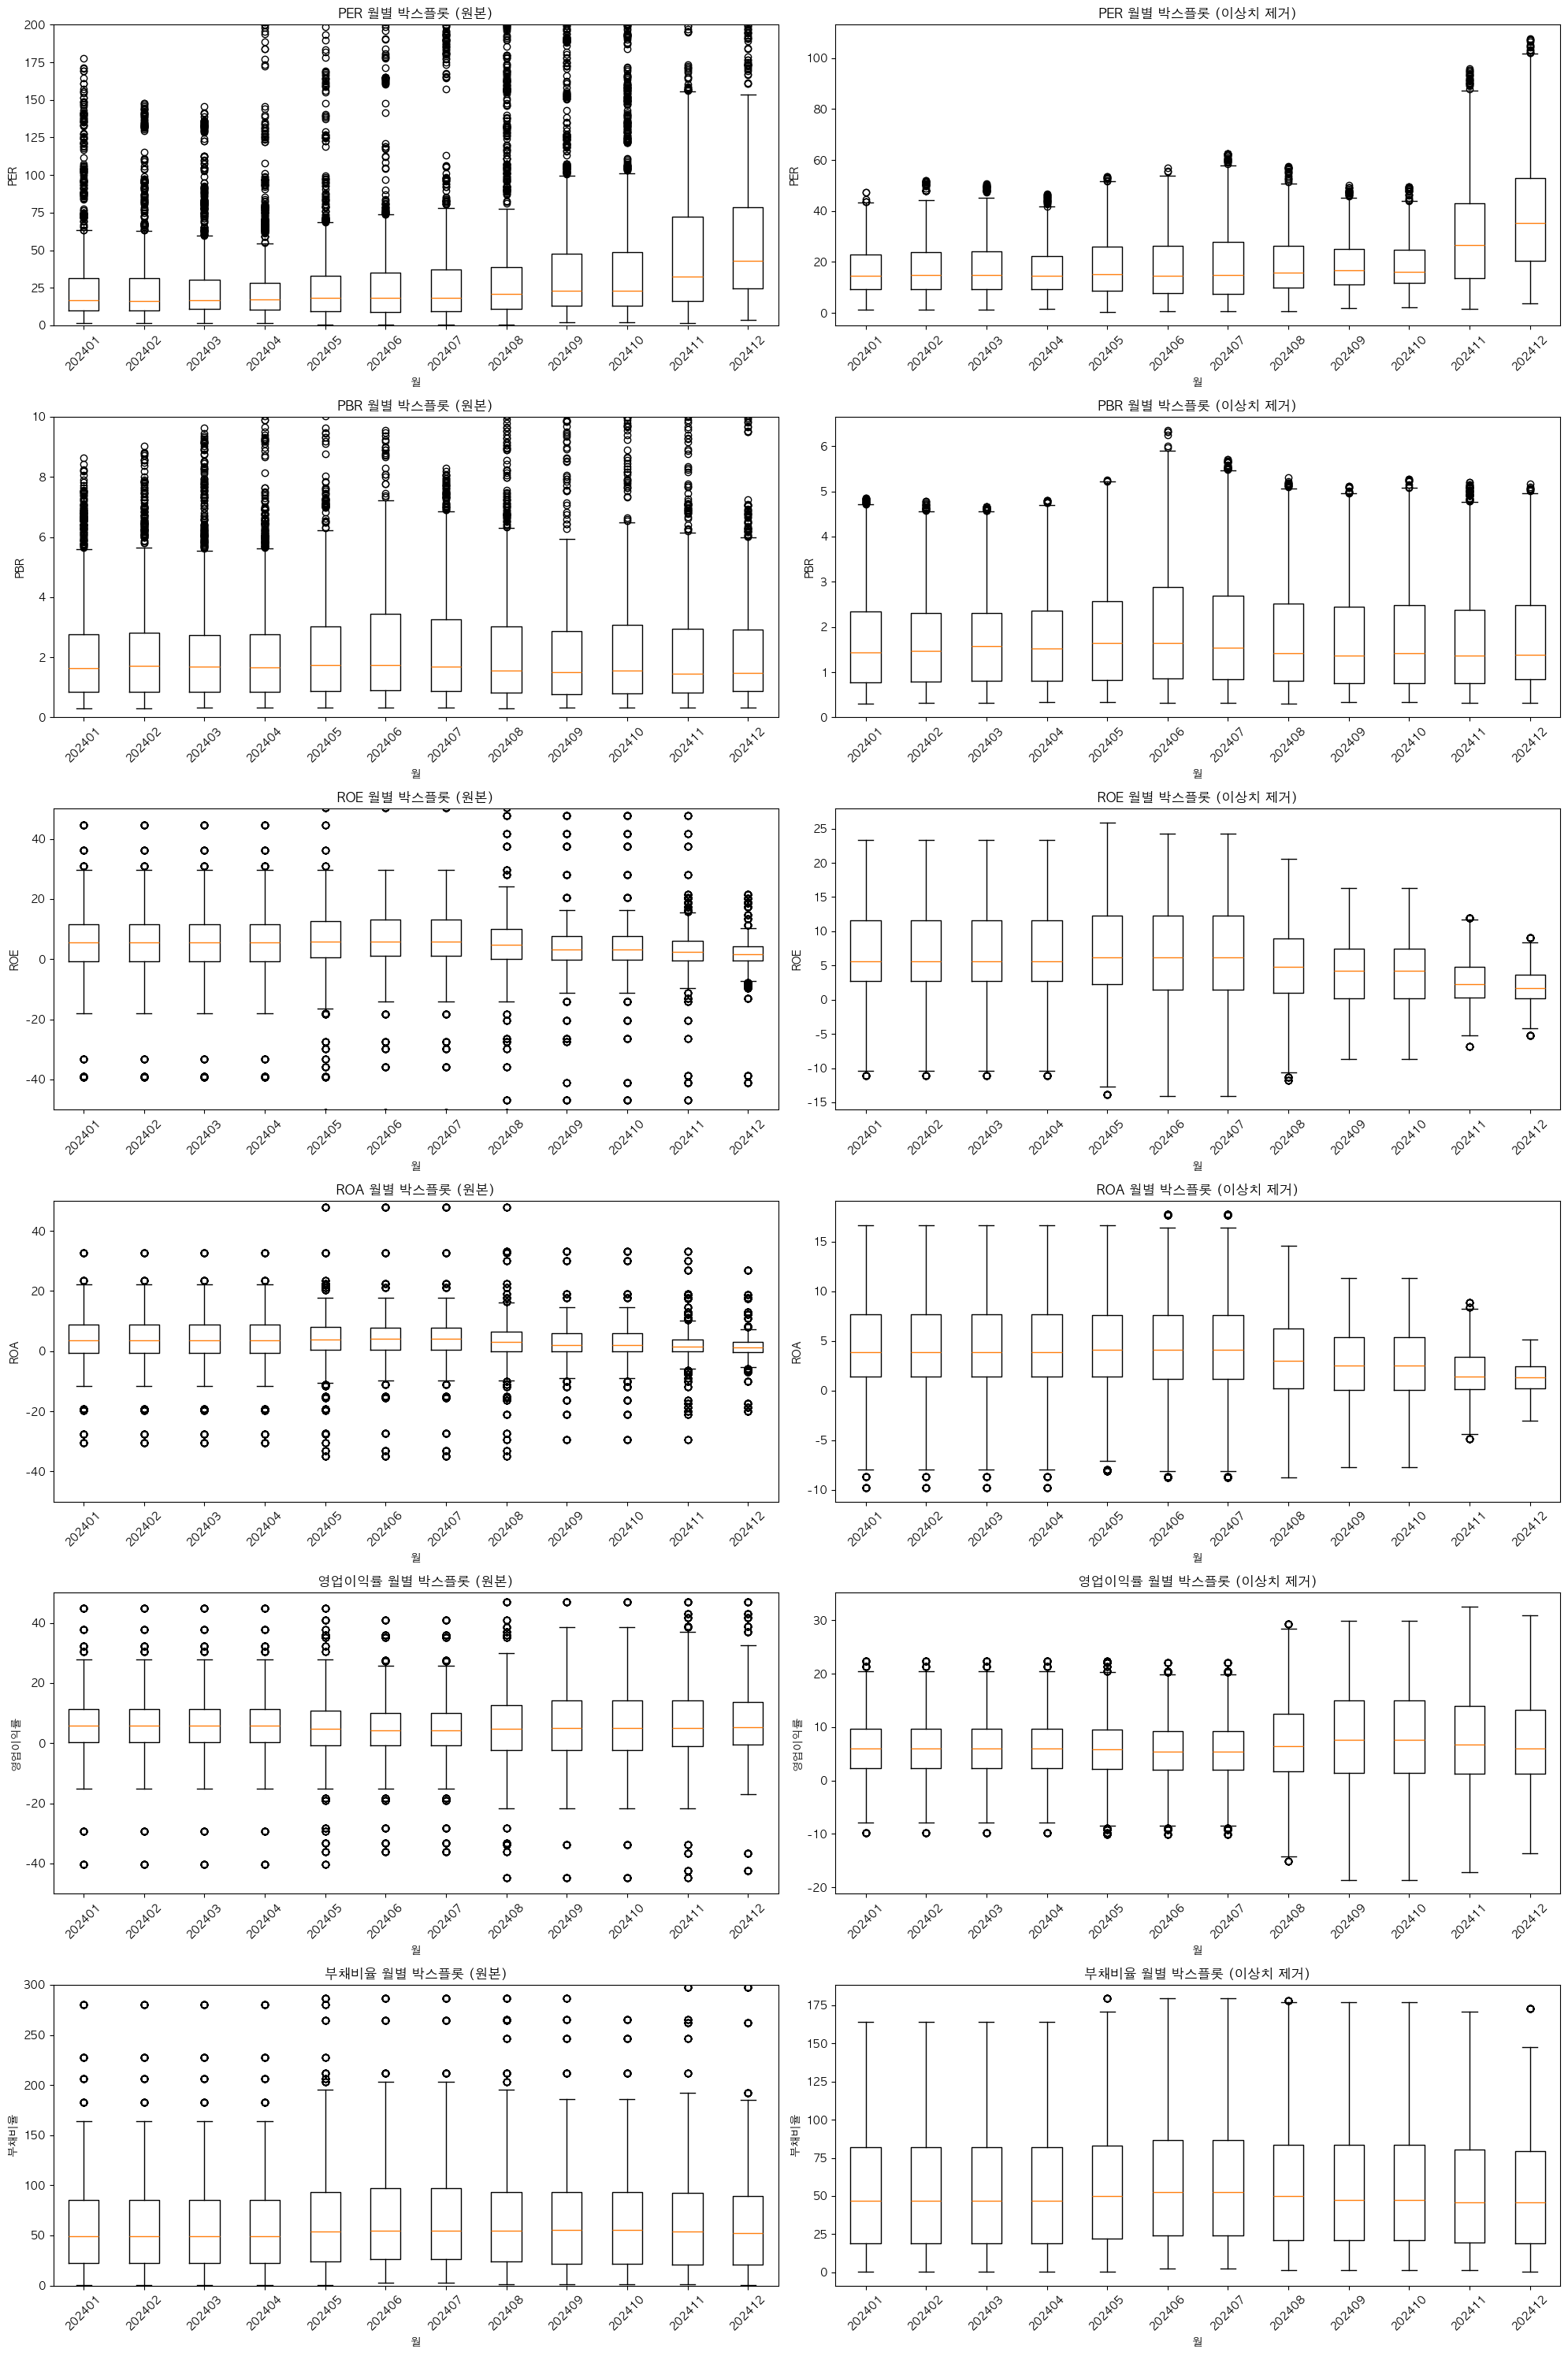


=== 전체 지표 이상치 제거 요약 ===
PER: 2501개 제거 (13.1%)
PBR: 1664개 제거 (6.5%)
ROE: 3075개 제거 (12.0%)
ROA: 2693개 제거 (10.5%)
영업이익률: 3787개 제거 (14.8%)
부채비율: 1463개 제거 (5.7%)

🎯 이상치 제거 후 투자 구간 분석 (매수/매도 지점 참고)
   지표  Lower_Bound  Q1_매수적극  Median_적정  Mean_평균  Q3_매도검토  Upper_Bound  정제데이터수
  PER       -19.80    10.31      17.32    23.32    30.38        60.48   16605
  PBR        -1.82     0.81       1.50     1.88     2.56         5.18   23956
  ROE       -12.64     0.99       4.84     5.19    10.07        23.69   22545
  ROA        -8.55     0.46       3.09     3.46     6.47        15.48   22927
영업이익률       -15.09     1.42       6.05     6.47    12.43        28.94   21833
 부채비율       -72.03    20.91      48.79    57.32    82.88       175.83   24157

📊 투자 구간 해석 가이드:
Lower_Bound ~ Q1     : 🟢 매수 적극 고려 (저평가 구간)
Q1 ~ Median         : 🟡 매수 검토 (적정 하단)
Median ~ Mean       : 🟠 보유/관망 (적정 중간)
Mean ~ Q3           : 🔴 매도 검토 (적정 상단)
Q3 ~ Upper_Bound    : 🔴 매도 적극 고려 (고평가 구간)
Upper_Bound 초과    : ⛔ 투자 금지 (극도 고평가)

💡 실전 활용

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


def remove_outliers_iqr(data, factor=1.5):
    """IQR 방법으로 이상치 제거"""
    if len(data) == 0:
        return data
    
    data_array = np.array(data)
    Q1 = np.percentile(data_array, 25)
    Q3 = np.percentile(data_array, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    filtered_data = [x for x in data_array if lower_bound <= x <= upper_bound]
    return filtered_data

# 모든 지표 리스트
metrics = ['PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율']

# 7행 2열 서브플롯 생성
fig, axes = plt.subplots(6, 2, figsize=(20, 30))

for row, metric in enumerate(metrics):
    print(f"처리 중: {metric}")
    
    # 해당 지표 데이터 추출
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    # 월별 데이터 수집 (원본)
    monthly_data_orig = {}
    for date in date_cols:
        month = date[:6]
        if month not in monthly_data_orig:
            monthly_data_orig[month] = []
        data = metric_data[date].dropna().tolist()
        if len(data) > 0:
            monthly_data_orig[month].extend(data)
    
    # 월별 데이터 수집 (이상치 제거)
    monthly_data_clean = {}
    for date in date_cols:
        month = date[:6]
        if month not in monthly_data_clean:
            monthly_data_clean[month] = []
        data = metric_data[date].dropna().tolist()
        if len(data) > 0:
            clean_data = remove_outliers_iqr(data)
            monthly_data_clean[month].extend(clean_data)
    for month in monthly_data_clean:
        if len(monthly_data_clean[month]) > 0:
            monthly_data_clean[month] = remove_outliers_iqr(monthly_data_clean[month])
    
    months = sorted(monthly_data_orig.keys())
    month_data_orig = [monthly_data_orig[month] for month in months]
    month_data_clean = [monthly_data_clean[month] for month in months]
    
    # 원본 박스플롯 (좌측)
    axes[row, 0].boxplot(month_data_orig, labels=months)
    axes[row, 0].set_title(f'{metric} 월별 박스플롯 (원본)')
    axes[row, 0].set_xlabel('월')
    axes[row, 0].set_ylabel(metric)
    axes[row, 0].tick_params(axis='x', rotation=45)
    
    # Y축 범위 설정 (지표별 조정)
    if metric == 'PER':
        axes[row, 0].set_ylim(0, 200)
    elif metric == 'PBR':
        axes[row, 0].set_ylim(0, 10)
    elif metric in ['ROE', 'ROA']:
        axes[row, 0].set_ylim(-50, 50)
    elif metric == '영업이익률':
        axes[row, 0].set_ylim(-50, 50)
    elif metric == '부채비율':
        axes[row, 0].set_ylim(0, 300)
    
    # 이상치 제거 후 박스플롯 (우측)
    axes[row, 1].boxplot(month_data_clean, labels=months)
    axes[row, 1].set_title(f'{metric} 월별 박스플롯 (이상치 제거)')
    axes[row, 1].set_xlabel('월')
    axes[row, 1].set_ylabel(metric)
    axes[row, 1].tick_params(axis='x', rotation=45)
    
    # 이상치 제거 효과 출력
    print(f"=== {metric} 이상치 제거 효과 ===")
    total_orig = sum(len(data) for data in month_data_orig)
    total_clean = sum(len(data) for data in month_data_clean)
    total_removed = total_orig - total_clean
    print(f"전체: {total_orig}개 → {total_clean}개 ({total_removed}개 제거, {total_removed/total_orig*100:.1f}%)")

plt.tight_layout()
plt.show()

# 전체 요약 통계
print("\n=== 전체 지표 이상치 제거 요약 ===")
for metric in metrics:
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    total_orig = 0
    total_clean = 0
    
    for date in date_cols:
        data = metric_data[date].dropna().tolist()
        if len(data) > 0:
            total_orig += len(data)
            clean_data = remove_outliers_iqr(data)
            total_clean += len(clean_data)
    
    removed = total_orig - total_clean
    if total_orig > 0:
        print(f"{metric}: {removed}개 제거 ({removed/total_orig*100:.1f}%)")

# ============== 여기서부터 추가된 부분 ==============

print("\n" + "="*100)
print("🎯 이상치 제거 후 투자 구간 분석 (매수/매도 지점 참고)")
print("="*100)

# 이상치 제거된 데이터로 투자 구간 분석
investment_analysis = []

for metric in metrics:
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    # 이상치 제거된 전체 데이터 수집
    all_clean_data = []
    for date in date_cols:
        data = metric_data[date].dropna().tolist()
        if len(data) > 0:
            clean_data = remove_outliers_iqr(data)
            all_clean_data.extend(clean_data)
    
    if len(all_clean_data) > 0:
        Q1 = np.percentile(all_clean_data, 25)
        Q3 = np.percentile(all_clean_data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        median = np.median(all_clean_data)
        mean = np.mean(all_clean_data)
        
        investment_analysis.append({
            '지표': metric,
            'Lower_Bound': round(lower_bound, 2),
            'Q1_매수적극': round(Q1, 2),
            'Median_적정': round(median, 2),
            'Mean_평균': round(mean, 2),
            'Q3_매도검토': round(Q3, 2),
            'Upper_Bound': round(upper_bound, 2),
            '정제데이터수': len(all_clean_data)
        })

# 투자 구간 분석 테이블 출력
investment_df = pd.DataFrame(investment_analysis)
print(investment_df.to_string(index=False))

print(f"\n📊 투자 구간 해석 가이드:")
print(f"Lower_Bound ~ Q1     : 🟢 매수 적극 고려 (저평가 구간)")
print(f"Q1 ~ Median         : 🟡 매수 검토 (적정 하단)")  
print(f"Median ~ Mean       : 🟠 보유/관망 (적정 중간)")
print(f"Mean ~ Q3           : 🔴 매도 검토 (적정 상단)")
print(f"Q3 ~ Upper_Bound    : 🔴 매도 적극 고려 (고평가 구간)")
print(f"Upper_Bound 초과    : ⛔ 투자 금지 (극도 고평가)")

# 실전 투자 활용 예시
print(f"\n💡 실전 활용 예시:")
for _, row in investment_df.iterrows():
    metric = row['지표']
    if metric == 'PER':
        print(f"📈 {metric}: {row['Q1_매수적극']}배 이하 매수, {row['Q3_매도검토']}배 이상 매도")
    elif metric == 'PBR':
        print(f"📊 {metric}: {row['Q1_매수적극']}배 이하 매수, {row['Q3_매도검토']}배 이상 매도")
    elif metric == 'ROE':
        print(f"💰 {metric}: {row['Q1_매수적극']}% 이상 선호, {row['Median_적정']}% 적정")

In [385]:
investment_df

,지표,Lower_Bound,Q1_매수적극,Median_적정,Mean_평균,Q3_매도검토,Upper_Bound,정제데이터수
0,PER,-19.80,10.31,17.32,23.32,30.38,60.48,16605
1,PBR,-1.82,0.81,1.50,1.88,2.56,5.18,23956
2,ROE,-12.64,0.99,4.84,5.19,10.07,23.69,22545
3,ROA,-8.55,0.46,3.09,3.46,6.47,15.48,22927
4,영업이익률,-15.09,1.42,6.05,6.47,12.43,28.94,21833
5,부채비율,-72.03,20.91,48.79,57.32,82.88,175.83,24157


## 4. 백테스트 진행

In [20]:
backtest_df = merged_df.filter(
  items=['시장구분_current', '종목명', '종목코드_current', '소속부_current', '시총증감률', '연간수익률', '상장주식수_current']
  ).rename(columns={
    '시장구분_current': '시장구분',
    '종목코드_current': '종목코드',
    '소속부_current': '소속부',
    '시총증감률': '시총_증감률',
    '연간수익률': '주가_수익률',
    '상장주식수_current': '상장주식수'
})

In [23]:
backtest_df_corpcode = pd.merge(backtest_df, 
                  analysis_df[['고유번호', '종목코드']],
                  on='종목코드',
                  how='left')

In [ ]:
def create_session_with_retry():
    """재시도 로직이 포함된 세션 생성"""
    session = requests.Session()
    retry_strategy = Retry(
        total=3,  # 최대 3번 재시도
        backoff_factor=1,  # 재시도 간격
        status_forcelist=[429, 500, 502, 503, 504],  # 재시도할 상태코드
    )
    adapter = HTTPAdapter(max_retries=retry_strategy)
    session.mount("http://", adapter)
    session.mount("https://", adapter)
    return session

def background_task(corp_code, corp_name, max_retries=3):
    """재시도 로직이 포함된 작업 함수"""
    for attempt in range(max_retries):
        try:
            time.sleep(0.5)  # 요청 간 대기시간 증가
            data = get_corp_quarter_data(corp_code, "2024")
            return corp_name, data
        except (requests.exceptions.ConnectionError, 
                requests.exceptions.Timeout,
                Exception) as e:
            if attempt < max_retries - 1:
                wait_time = (2 ** attempt) * 0.5  # 지수 백오프
                print(f"재시도 {attempt + 1}/{max_retries} for {corp_name}, 대기: {wait_time}초")
                print(e)
                time.sleep(wait_time)
            else:
                print(f"최종 실패: {corp_name} - {str(e)}")
                return corp_name, None
with ThreadPoolExecutor(max_workers=2) as executor:
    futures = [
        executor.submit(background_task, row['고유번호'], row['종목명']) 
        for _, row in backtest_df_corpcode.iterrows()
    ]
    
    results = []
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing"):
        results.append(future.result())

# None이 아닌 결과만 필터링
backtest_result_dict = {name: df for name, df in results if df is not None}

In [35]:
def check_accounts_for_zero(df, accounts_to_check):
    """계정과목에서 0이 있는지 확인"""
    quarterly_cols = ['2023_4Q', '2024_1Q', '2024_2Q', '2024_3Q', '2024_4Q']
    
    for account in accounts_to_check:
        account_row = df[df['계정과목'] == account]
        if not account_row.empty:
            for col in quarterly_cols:
                if col in account_row.columns:
                    if (account_row[col] == 0).any():
                        return True
    return False

columns_to_check = ['당기순이익', '자산총계', '자본총계', '부채총계','매출액','영업이익']

zero_stocks = []
for corp_name, df in backtest_result_dict.items():
    if df is not None and not df.empty:
        if check_accounts_for_zero(df, columns_to_check):
            zero_stocks.append(corp_name)

print(f" 0이 포함된 종목 수 {len(zero_stocks)} ,0이 포함된 종목: {zero_stocks}, ")

backtest_filtered_dict = {
    corp_name: df for corp_name, df in backtest_result_dict.items()
    if df is not None and not df.empty and 
    not check_accounts_for_zero(df, columns_to_check)
}

backtest_remaining_stocks = list(backtest_filtered_dict.keys())

# final_summary에서 해당 종목들만 필터링
backtest_filtered_final_summary = backtest_df_corpcode[backtest_df_corpcode['종목명'].isin(backtest_remaining_stocks)]

print(f"원래 final_summary 종목 수: {len(backtest_df_corpcode)}")
print(f"필터링 후 종목 수: {len(backtest_filtered_final_summary)}")
print(f"제거된 종목 수: {len(backtest_df_corpcode) - len(backtest_filtered_final_summary)}")



 0이 포함된 종목 수 92 ,0이 포함된 종목: ['덕성', '지앤비에스 에코', '조이시티', '셀리드', '코아시아', '강스템바이오텍', '샤페론', '팜스토리', '켄코아에어로스페이스', '코아스템켐온', 'LK삼양', '태림포장', 'HLB제넥스', '삼성제약', '엑시콘', '컨텍', '티케이케미칼', '메드팩토', '아티스트유나이티드', 'KEC', '포니링크', '알멕', '한국캐피탈', '웅진씽크빅', '한국정보인증', '글로벌텍스프리', '한화갤러리아', '흥국화재', '이월드', '에브리봇', 'SK증권', '코리아써키트', '브릿지바이오테라퓨틱스', '에이프로젠', '화신', '에치에프알', '동국산업', '마녀공장', '미래에셋벤처투자', '제주은행', '하이비젼시스템', '에어부산', '솔트룩스', '인카금융서비스', '아세아제지', '세경하이테크', '부광약품', '애경산업', '신라젠', '케이엠더블유', '소룩스', '에이프릴바이오', '영진약품', '유일로보틱스', '엔젤로보틱스', '더블유씨피', '큐로셀', '동성화인텍', '한화손해보험', '바이오노트', '바이오다인', '포스코엠텍', '진에어', '삼아알미늄', '가온전선', 'KG스틸', '롯데관광개발', '케이씨텍', '젬백스', '솔루스첨단소재', '우리기술투자', '하나마이크론', '차바이오텍', '동국제약', '동양생명', '녹십자홀딩스', '현대지에프홀딩스', '파두', '대신증권', 'LS머트리얼즈', '중앙첨단소재', 'CJ CGV', '보령', 'SK네트웍스', '이수스페셜티케미컬', '두산퓨얼셀', '원익IPS', '동진쎄미켐', 'HLB생명과학', '에스디바이오센서', '하이트진로', 'DGB금융지주'], 
원래 final_summary 종목 수: 490
필터링 후 종목 수: 374
제거된 종목 수: 116


In [39]:
backtest_sample = pd.merge(backtest_filtered_final_summary, all_data, on=['종목코드', '종목명'], how='inner')
backtest_analysis_df = create_company_analysis_dataframe(backtest_sample, backtest_filtered_dict)
backtest_analysis_df

기업별 분석 데이터 생성: 100%|██████████| 374/374 [00:42<00:00,  8.81it/s]


,종목명,구분,20240102,20240103,20240104,20240105,20240108,20240109,20240110,20240111,...,20241216,20241217,20241218,20241219,20241220,20241223,20241224,20241226,20241227,20241230
0,제이스코홀딩스,종가,1430.000000,1477.000000,1408.000000,1401.000000,1414.000000,1425.000000,1460.000000,1469.000000,...,1854.000000,1871.000000,1825.000000,1847.000000,1744.000000,1725.000000,1739.000000,1702.000000,1626.000000,1693.000000
1,제이스코홀딩스,PER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,제이스코홀딩스,PBR,1.400996,1.447042,1.379442,1.372584,1.385320,1.396097,1.430387,1.439205,...,1.777508,1.793806,1.749704,1.770796,1.672046,1.653830,1.667252,1.631779,1.558914,1.623150
3,제이스코홀딩스,ROE,-38.864932,-38.864932,-38.864932,-38.864932,-38.864932,-38.864932,-38.864932,-38.864932,...,-13.082513,-13.082513,-13.082513,-13.082513,-13.082513,-13.082513,-13.082513,-13.082513,-13.082513,-13.082513
4,제이스코홀딩스,ROA,-19.087926,-19.087926,-19.087926,-19.087926,-19.087926,-19.087926,-19.087926,-19.087926,...,-6.709918,-6.709918,-6.709918,-6.709918,-6.709918,-6.709918,-6.709918,-6.709918,-6.709918,-6.709918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2613,DB하이텍,PBR,1.408008,1.348913,1.336066,1.330928,1.318081,1.333497,1.356621,1.356621,...,0.818124,0.845755,0.834943,0.820527,0.797701,0.807312,0.815721,0.794097,0.761660,0.796499
2614,DB하이텍,ROE,14.767488,14.767488,14.767488,14.767488,14.767488,14.767488,14.767488,14.767488,...,3.324123,3.324123,3.324123,3.324123,3.324123,3.324123,3.324123,3.324123,3.324123,3.324123
2615,DB하이텍,ROA,12.771267,12.771267,12.771267,12.771267,12.771267,12.771267,12.771267,12.771267,...,2.930445,2.930445,2.930445,2.930445,2.930445,2.930445,2.930445,2.930445,2.930445,2.930445
2616,DB하이텍,영업이익률,24.258087,24.258087,24.258087,24.258087,24.258087,24.258087,24.258087,24.258087,...,17.773675,17.773675,17.773675,17.773675,17.773675,17.773675,17.773675,17.773675,17.773675,17.773675


In [41]:
def get_rebalancing_dates(df):
    """
    2024년 월말 리밸런싱 날짜들을 생성하는 함수
    
    Parameters:
    - df: analysis_df 데이터프레임
    
    Returns:
    - list: 월말 리밸런싱 날짜 리스트
    
    기능:
    1. 데이터에 있는 모든 거래일 추출
    2. 각 월의 마지막 거래일 찾기
    3. 월별 리밸런싱 날짜 리스트 반환
    """
    # 날짜 컬럼들 추출 (YYYYMMDD 형태)
    date_cols = [col for col in df.columns if col.isdigit() and len(col) == 8]
    date_cols.sort()
    
    # 월별 마지막 거래일 찾기
    monthly_dates = {}
    for date in date_cols:
        month = date[:6]  # YYYYMM
        monthly_dates[month] = date  # 덮어쓰면서 마지막 날짜가 저장됨
    
    # 리밸런싱 날짜 리스트
    rebalancing_dates = list(monthly_dates.values())
    
    print(f"📅 월별 리밸런싱 날짜 ({len(rebalancing_dates)}개월):")
    for i, date in enumerate(rebalancing_dates, 1):
        month_name = f"{date[4:6]}월"
        print(f"   {i:2d}. {month_name}: {date}")
    
    return rebalancing_dates

# 테스트 실행
rebalancing_dates = get_rebalancing_dates(analysis_df)

📅 월별 리밸런싱 날짜 (12개월):
    1. 01월: 20240131
    2. 02월: 20240229
    3. 03월: 20240329
    4. 04월: 20240430
    5. 05월: 20240531
    6. 06월: 20240628
    7. 07월: 20240731
    8. 08월: 20240830
    9. 09월: 20240930
   10. 10월: 20241031
   11. 11월: 20241129
   12. 12월: 20241230


In [42]:
def get_fundamentals_at_date(df, target_date, metrics=['PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율']):
    """
    특정 날짜의 재무지표 데이터를 추출하는 함수
    
    Parameters:
    - df: analysis_df 데이터프레임
    - target_date: 추출할 날짜 (예: '20240131')
    - metrics: 추출할 재무지표 리스트
    
    Returns:
    - DataFrame: 종목별 재무지표 데이터 (종목명이 인덱스)
    
    기능:
    1. 지정된 날짜에서 각 재무지표 값을 추출
    2. 결측치가 너무 많은 종목 제외
    3. 종목별로 정리된 DataFrame 반환
    """
    # 해당 날짜가 데이터에 있는지 확인
    if target_date not in df.columns:
        # 가장 가까운 이전 날짜 찾기
        available_dates = [col for col in df.columns if col.isdigit() and col <= target_date]
        if not available_dates:
            print(f"❌ {target_date} 이전 데이터가 없습니다.")
            return pd.DataFrame()
        target_date = max(available_dates)
        print(f"📅 {target_date} 데이터 사용")
    
    fundamentals = {}
    
    for metric in metrics:
        # 해당 구분의 데이터 추출
        metric_data = df[df['구분'] == metric]
        
        if not metric_data.empty:
            # 종목명을 키로, 해당 날짜 값을 밸류로 하는 딕셔너리
            metric_values = metric_data.set_index('종목명')[target_date].to_dict()
            fundamentals[metric] = metric_values
    
    # DataFrame으로 변환
    fund_df = pd.DataFrame(fundamentals)
    
    # 결측치가 너무 많은 종목 제외 (최소 절반 이상 데이터 있어야 함)
    min_data_count = len(metrics) // 2
    fund_df = fund_df.dropna(thresh=min_data_count)
    
    print(f"📊 {target_date} 재무지표 추출 완료:")
    print(f"   대상 종목: {len(fund_df)}개")
    print(f"   추출 지표: {list(fund_df.columns)}")
    
    # 간단한 통계 출력
    for metric in fund_df.columns:
        valid_count = fund_df[metric].notna().sum()
        print(f"   {metric}: {valid_count}개 종목 데이터 보유")
    
    return fund_df

# 테스트 실행
test_fundamentals = get_fundamentals_at_date(analysis_df, '20240131')
print(f"\n샘플 데이터:")
print(test_fundamentals.head())

📊 20240131 재무지표 추출 완료:
   대상 종목: 361개
   추출 지표: ['PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율']
   PER: 246개 종목 데이터 보유
   PBR: 361개 종목 데이터 보유
   ROE: 361개 종목 데이터 보유
   ROA: 361개 종목 데이터 보유
   영업이익률: 361개 종목 데이터 보유
   부채비율: 361개 종목 데이터 보유

샘플 데이터:
                PER       PBR        ROE        ROA       영업이익률        부채비율
제이스코홀딩스         NaN  1.256977 -38.864932 -19.087926  -15.078510  103.610031
퀀타매트릭스          NaN  2.431799 -61.125367 -54.429416 -621.977175   12.302081
삼익악기      21.806563  0.481821   2.209523   1.421021    7.154776   55.488374
샌즈랩      396.224658  4.279610   1.080097   0.946301   -7.538690   14.138823
화일약품      39.471867  0.874097   2.214480   2.076995    1.670788    6.619433


In [43]:
def screen_stocks_monthly(fund_df, screening_criteria=None):
    """
    재무지표 기준으로 종목을 스크리닝하는 함수
    
    Parameters:
    - fund_df: get_fundamentals_at_date()에서 반환된 재무지표 DataFrame
    - screening_criteria: 스크리닝 기준 딕셔너리
    
    Returns:
    - list: 스크리닝을 통과한 종목명 리스트
    
    기능:
    1. 이상치 제거된 기준으로 종목 필터링
    2. 모든 조건을 만족하는 종목만 선별
    3. 스크리닝 결과 상세 리포트
    """
    if screening_criteria is None:
        # 이전에 설정한 이상치 제거된 기준 사용
        screening_criteria = {
            'PER': (10.31, 60.48),        # Q1 ~ Upper_Bound
            'PBR': (0.81, 5.18),         # Q1 ~ Upper_Bound  
            'ROE': (0.99, 23.69),        # Q1 ~ Upper_Bound (양수 수익성)
            'ROA': (0.46, 15.48),        # Q1 ~ Upper_Bound (양수 수익성)
            '영업이익률': (1.42, 28.94),   # Q1 ~ Upper_Bound (양수 마진)
            '부채비율': (0, 175.83)       # 0 ~ Upper_Bound (건전성)
        }
    
    print(f"🎯 종목 스크리닝 시작 (총 {len(fund_df)}개 종목)")
    print(f"📋 스크리닝 기준:")
    for metric, (min_val, max_val) in screening_criteria.items():
        print(f"   {metric}: {min_val:.2f} ~ {max_val:.2f}")
    
    selected_stocks = []
    screening_results = {}
    
    for stock in fund_df.index:
        passed = True
        stock_results = {}
        
        for metric, (min_val, max_val) in screening_criteria.items():
            if metric not in fund_df.columns:
                continue
                
            value = fund_df.loc[stock, metric]
            
            # 결측치 체크
            if pd.isna(value):
                passed = False
                stock_results[metric] = f"결측치"
                break
            
            # 기준 체크
            if value < min_val or value > max_val:
                passed = False
                stock_results[metric] = f"{value:.2f} (범위초과)"
                break
            else:
                stock_results[metric] = f"{value:.2f} (통과)"
        
        screening_results[stock] = {
            'passed': passed,
            'details': stock_results
        }
        
        if passed:
            selected_stocks.append(stock)
    
    # 결과 출력
    print(f"\n✅ 스크리닝 결과:")
    print(f"   통과 종목: {len(selected_stocks)}개")
    print(f"   탈락 종목: {len(fund_df) - len(selected_stocks)}개")
    print(f"   통과율: {len(selected_stocks)/len(fund_df)*100:.1f}%")
    
    # 통과 종목 상위 5개 출력
    if len(selected_stocks) > 0:
        print(f"\n📈 통과 종목 예시 (상위 5개):")
        for i, stock in enumerate(selected_stocks[:5], 1):
            print(f"   {i}. {stock}")
            for metric in ['PER', 'PBR', 'ROE']:
                if metric in fund_df.columns:
                    value = fund_df.loc[stock, metric]
                    print(f"      {metric}: {value:.2f}")
    
    # 주요 탈락 사유 분석
    rejection_reasons = {}
    for stock, result in screening_results.items():
        if not result['passed']:
            for metric, detail in result['details'].items():
                if '범위초과' in detail or '결측치' in detail:
                    if metric not in rejection_reasons:
                        rejection_reasons[metric] = 0
                    rejection_reasons[metric] += 1
                    break  # 첫 번째 탈락 사유만 카운트
    
    if rejection_reasons:
        print(f"\n📊 주요 탈락 사유:")
        for metric, count in sorted(rejection_reasons.items(), key=lambda x: x[1], reverse=True):
            print(f"   {metric}: {count}개 종목")
    
    return selected_stocks

# 테스트 실행
if 'test_fundamentals' in locals() and not test_fundamentals.empty:
    selected_stocks = screen_stocks_monthly(test_fundamentals)
else:
    print("먼저 get_fundamentals_at_date() 함수를 실행해주세요.")

🎯 종목 스크리닝 시작 (총 361개 종목)
📋 스크리닝 기준:
   PER: 10.31 ~ 60.48
   PBR: 0.81 ~ 5.18
   ROE: 0.99 ~ 23.69
   ROA: 0.46 ~ 15.48
   영업이익률: 1.42 ~ 28.94
   부채비율: 0.00 ~ 175.83

✅ 스크리닝 결과:
   통과 종목: 96개
   탈락 종목: 265개
   통과율: 26.6%

📈 통과 종목 예시 (상위 5개):
   1. 화일약품
      PER: 39.47
      PBR: 0.87
      ROE: 2.21
   2. 대원미디어
      PER: 28.84
      PBR: 1.95
      ROE: 6.77
   3. CJ씨푸드
      PER: 23.37
      PBR: 1.29
      ROE: 5.51
   4. 셀바스헬스케어
      PER: 32.81
      PBR: 2.64
      ROE: 8.04
   5. 에이텍모빌리티
      PER: 32.94
      PBR: 1.73
      ROE: 5.24

📊 주요 탈락 사유:
   PER: 205개 종목
   PBR: 28개 종목
   영업이익률: 22개 종목
   부채비율: 6개 종목
   ROE: 3개 종목
   ROA: 1개 종목


In [45]:
def calculate_factor_scores_and_portfolio(fund_df, selected_stocks, top_n=20):
    """
    스크리닝 통과 종목들의 팩터 스코어를 계산하고 포트폴리오를 구성하는 함수
    
    Parameters:
    - fund_df: 재무지표 DataFrame
    - selected_stocks: 스크리닝 통과 종목 리스트
    - top_n: 포트폴리오에 포함할 종목 수
    
    Returns:
    - DataFrame: 상위 종목들의 팩터 스코어 정보
    
    기능:
    1. Value, Quality, Momentum 팩터 스코어 계산
    2. 종합 점수로 순위 매기기  
    3. 상위 N개 종목 선별
    4. 포트폴리오 구성 및 가중치 결정
    """
    if len(selected_stocks) == 0:
        print("❌ 스크리닝 통과 종목이 없습니다.")
        return pd.DataFrame()
    
    print(f"🏆 팩터 스코어 계산 시작 ({len(selected_stocks)}개 종목)")
    
    scores = []
    
    for stock in selected_stocks:
        try:
            # 재무지표 추출
            per = fund_df.loc[stock, 'PER'] if 'PER' in fund_df.columns else np.nan
            pbr = fund_df.loc[stock, 'PBR'] if 'PBR' in fund_df.columns else np.nan
            roe = fund_df.loc[stock, 'ROE'] if 'ROE' in fund_df.columns else np.nan
            roa = fund_df.loc[stock, 'ROA'] if 'ROA' in fund_df.columns else np.nan
            profit_margin = fund_df.loc[stock, '영업이익률'] if '영업이익률' in fund_df.columns else np.nan
            
            # 결측치 체크
            if pd.isna(per) or pd.isna(pbr) or pd.isna(roe):
                continue
            
            # 팩터 스코어 계산
            # Value Score (낮을수록 좋음 → 역수 사용)
            value_score = (1/per + 1/pbr) * 50  # 스케일링
            
            # Quality Score (높을수록 좋음)
            quality_components = [roe, roa, profit_margin]
            quality_values = [x for x in quality_components if pd.notna(x)]
            quality_score = np.mean(quality_values) if quality_values else 0
            
            # Momentum Score (현재는 ROE로 대체, 실제로는 주가 모멘텀 사용)
            momentum_score = roe  # 간단히 ROE 사용
            
            # 종합 점수 (가중평균)
            total_score = (value_score * 0.3 + 
                          quality_score * 0.4 + 
                          momentum_score * 0.3)
            
            scores.append({
                '종목명': stock,
                'PER': per,
                'PBR': pbr,
                'ROE': roe,
                'ROA': roa if pd.notna(roa) else 0,
                '영업이익률': profit_margin if pd.notna(profit_margin) else 0,
                'Value점수': value_score,
                'Quality점수': quality_score,
                'Momentum점수': momentum_score,
                '종합점수': total_score
            })
            
        except Exception as e:
            print(f"⚠️ {stock} 계산 오류: {e}")
            continue
    
    if not scores:
        print("❌ 팩터 스코어 계산 가능한 종목이 없습니다.")
        return pd.DataFrame()
    
    # DataFrame 생성 및 정렬
    score_df = pd.DataFrame(scores)
    score_df = score_df.sort_values('종합점수', ascending=False)
    
    # 상위 N개 종목 선별
    top_stocks = score_df.head(top_n)
    
    # 결과 출력
    print(f"\n📊 팩터 스코어 계산 완료:")
    print(f"   계산 완료: {len(score_df)}개 종목")
    print(f"   포트폴리오: 상위 {len(top_stocks)}개 종목 선별")
    
    print(f"\n🏆 이번 달 포트폴리오 TOP 10:")
    for i, (_, row) in enumerate(top_stocks.head(10).iterrows(), 1):
        print(f"   {i:2d}. {row['종목명']:<12} | 종합점수: {row['종합점수']:6.2f} | PER: {row['PER']:5.1f} | ROE: {row['ROE']:5.1f}%")
    
    # 포트폴리오 가중치 (동일가중)
    portfolio_weights = {}
    weight_per_stock = 1.0 / len(top_stocks)
    
    for _, row in top_stocks.iterrows():
        portfolio_weights[row['종목명']] = weight_per_stock
    
    print(f"\n💼 포트폴리오 구성:")
    print(f"   종목당 비중: {weight_per_stock*100:.2f}%")
    print(f"   총 비중: {sum(portfolio_weights.values())*100:.1f}%")
    
    # 추가 정보를 DataFrame에 포함
    top_stocks = top_stocks.copy()
    top_stocks['포트폴리오_비중'] = weight_per_stock
    
    return top_stocks

# 테스트 실행
if 'selected_stocks' in locals() and 'test_fundamentals' in locals():
    portfolio = calculate_factor_scores_and_portfolio(test_fundamentals, selected_stocks, top_n=20)
    print(f"\n포트폴리오 구성 완료: {len(portfolio)}개 종목")
else:
    print("먼저 이전 함수들을 실행해주세요.")

🏆 팩터 스코어 계산 시작 (96개 종목)

📊 팩터 스코어 계산 완료:
   계산 완료: 96개 종목
   포트폴리오: 상위 20개 종목 선별

🏆 이번 달 포트폴리오 TOP 10:
    1. 수산아이앤티       | 종합점수:  26.35 | PER:  14.4 | ROE:   5.6%
    2. 뉴파워프라즈마      | 종합점수:  23.11 | PER:  10.5 | ROE:  10.0%
    3. 아가방컴퍼니       | 종합점수:  22.24 | PER:  11.8 | ROE:   8.6%
    4. 한국경제TV       | 종합점수:  21.54 | PER:  17.3 | ROE:   5.1%
    5. 비츠로셀         | 종합점수:  21.45 | PER:  11.2 | ROE:  15.7%
    6. 에스에이엠티       | 종합점수:  21.33 | PER:  11.4 | ROE:   8.7%
    7. 보광산업         | 종합점수:  21.09 | PER:  11.0 | ROE:  17.4%
    8. 아이디스         | 종합점수:  21.07 | PER:  12.2 | ROE:   8.7%
    9. 휴메딕스         | 종합점수:  20.93 | PER:  12.6 | ROE:  12.5%
   10. 파트론          | 종합점수:  20.27 | PER:  13.9 | ROE:   7.2%

💼 포트폴리오 구성:
   종목당 비중: 5.00%
   총 비중: 100.0%

포트폴리오 구성 완료: 20개 종목


In [46]:
def calculate_monthly_returns(stock_data, portfolio_stocks, start_date, end_date):
    """
    포트폴리오의 월별 수익률을 계산하는 함수
    
    Parameters:
    - stock_data: analysis_df 데이터프레임
    - portfolio_stocks: 포트폴리오 종목 딕셔너리 {종목명: 비중}
    - start_date: 시작 날짜 (매수일)
    - end_date: 종료 날짜 (매도일)
    
    Returns:
    - dict: 포트폴리오 수익률 정보
    
    기능:
    1. 각 종목의 월별 수익률 계산
    2. 가중평균으로 포트폴리오 수익률 산출
    3. 개별 종목 기여도 분석
    """
    # 종가 데이터 추출
    price_data = stock_data[stock_data['구분'] == '종가'].set_index('종목명')
    
    portfolio_return = 0
    stock_returns = {}
    valid_stocks = 0
    
    print(f"📊 {start_date} → {end_date} 수익률 계산")
    
    for stock, weight in portfolio_stocks.items():
        try:
            # 시작가와 종료가 추출
            start_price = price_data.loc[stock, start_date]
            end_price = price_data.loc[stock, end_date]
            
            # 결측치 체크
            if pd.isna(start_price) or pd.isna(end_price) or start_price <= 0:
                print(f"   ⚠️ {stock}: 가격 데이터 없음")
                continue
            
            # 개별 종목 수익률
            stock_return = (end_price - start_price) / start_price * 100
            stock_returns[stock] = stock_return
            
            # 포트폴리오 기여도 (수익률 × 비중)
            contribution = stock_return * weight
            portfolio_return += contribution
            valid_stocks += 1
            
            print(f"   📈 {stock:<12}: {stock_return:6.2f}% (비중: {weight*100:4.1f}%, 기여: {contribution:5.2f}%)")
            
        except Exception as e:
            print(f"   ❌ {stock}: 계산 오류 - {e}")
            continue
    
    # 결과 정리
    result = {
        'portfolio_return': portfolio_return,
        'stock_returns': stock_returns,
        'valid_stocks': valid_stocks,
        'total_stocks': len(portfolio_stocks),
        'period': f"{start_date}-{end_date}"
    }
    
    print(f"\n💼 포트폴리오 월간 성과:")
    print(f"   수익률: {portfolio_return:6.2f}%")
    print(f"   유효 종목: {valid_stocks}/{len(portfolio_stocks)}개")
    
    if stock_returns:
        best_stock = max(stock_returns.items(), key=lambda x: x[1])
        worst_stock = min(stock_returns.items(), key=lambda x: x[1])
        print(f"   최고 종목: {best_stock[0]} (+{best_stock[1]:.2f}%)")
        print(f"   최저 종목: {worst_stock[0]} ({worst_stock[1]:.2f}%)")
    
    return result

# 테스트용 포트폴리오 생성
if 'portfolio' in locals() and not portfolio.empty:
    # 포트폴리오 딕셔너리로 변환
    test_portfolio = {}
    for _, row in portfolio.iterrows():
        test_portfolio[row['종목명']] = row['포트폴리오_비중']
    
    # 1월 수익률 테스트 계산
    jan_returns = calculate_monthly_returns(
        analysis_df, 
        test_portfolio, 
        '20240131',  # 1월 말 매수
        '20240229'   # 2월 말 매도
    )
else:
    print("먼저 포트폴리오 구성 함수를 실행해주세요.")

📊 20240131 → 20240229 수익률 계산
   📈 수산아이앤티      :   3.35% (비중:  5.0%, 기여:  0.17%)
   📈 뉴파워프라즈마     :  -4.42% (비중:  5.0%, 기여: -0.22%)
   📈 아가방컴퍼니      :  24.04% (비중:  5.0%, 기여:  1.20%)
   📈 한국경제TV      :  -1.65% (비중:  5.0%, 기여: -0.08%)
   📈 비츠로셀        :  -3.30% (비중:  5.0%, 기여: -0.16%)
   📈 에스에이엠티      :   3.17% (비중:  5.0%, 기여:  0.16%)
   📈 보광산업        :   7.92% (비중:  5.0%, 기여:  0.40%)
   📈 아이디스        :  -5.58% (비중:  5.0%, 기여: -0.28%)
   📈 휴메딕스        :   1.44% (비중:  5.0%, 기여:  0.07%)
   📈 파트론         :  -1.63% (비중:  5.0%, 기여: -0.08%)
   📈 화승인더        :  -4.01% (비중:  5.0%, 기여: -0.20%)
   📈 모나리자        :   0.88% (비중:  5.0%, 기여:  0.04%)
   📈 KTcs        :   4.53% (비중:  5.0%, 기여:  0.23%)
   📈 교촌에프앤비      :   3.13% (비중:  5.0%, 기여:  0.16%)
   📈 진성티이씨       :  -4.09% (비중:  5.0%, 기여: -0.20%)
   📈 토비스         :   7.69% (비중:  5.0%, 기여:  0.38%)
   📈 화일약품        : -10.00% (비중:  5.0%, 기여: -0.50%)
   📈 이녹스첨단소재     :  15.51% (비중:  5.0%, 기여:  0.78%)
   📈 유니셈         :  -1.35% (비중:  5.0%, 기여: -0.07%)
  

In [47]:
def run_monthly_rebalancing_backtest(df, initial_capital=10000000, top_n=20):
    """
    월별 리밸런싱 백테스트를 실행하는 메인 함수
    
    Parameters:
    - df: analysis_df 데이터프레임
    - initial_capital: 초기 투자금액 (1천만원)
    - top_n: 포트폴리오 종목 수 (20개)
    
    Returns:
    - dict: 백테스트 결과 종합
    
    기능:
    1. 매월 말 리밸런싱 실행
    2. 누적 수익률 및 성과 지표 계산
    3. 월별 상세 결과 기록
    4. 최종 성과 분석
    """
    print("🚀 월별 리밸런싱 백테스트 시작!")
    print("="*60)
    
    # 리밸런싱 날짜 생성
    rebalancing_dates = get_rebalancing_dates(df)
    
    # 백테스트 결과 저장
    backtest_results = {
        'monthly_returns': [],
        'monthly_portfolios': [],
        'cumulative_returns': [],
        'total_capital': [initial_capital]
    }
    
    current_capital = initial_capital
    
    print(f"💰 초기 자본: {initial_capital:,}원")
    print(f"📅 백테스트 기간: {len(rebalancing_dates)}개월")
    print(f"🎯 월별 포트폴리오: {top_n}개 종목\n")
    
    for i, current_date in enumerate(rebalancing_dates):
        month_num = i + 1
        print(f"{'='*20} {month_num}월차 ({current_date}) {'='*20}")
        
        try:
            # 1단계: 해당 월의 재무지표 추출
            fundamentals = get_fundamentals_at_date(df, current_date)
            if fundamentals.empty:
                print(f"❌ {month_num}월: 재무지표 데이터 없음")
                continue
            
            # 2단계: 종목 스크리닝
            selected_stocks = screen_stocks_monthly(fundamentals)
            if len(selected_stocks) < top_n:
                print(f"⚠️ {month_num}월: 선별 종목 부족 ({len(selected_stocks)}개)")
                # 가능한 종목 수로 조정
                current_top_n = min(len(selected_stocks), top_n)
            else:
                current_top_n = top_n
            
            # 3단계: 포트폴리오 구성
            portfolio = calculate_factor_scores_and_portfolio(
                fundamentals, selected_stocks, top_n=current_top_n
            )
            
            if portfolio.empty:
                print(f"❌ {month_num}월: 포트폴리오 구성 실패")
                continue
            
            # 4단계: 다음 월까지의 수익률 계산
            if i < len(rebalancing_dates) - 1:
                next_date = rebalancing_dates[i + 1]
                
                # 포트폴리오 딕셔너리 생성
                current_portfolio = {}
                for _, row in portfolio.iterrows():
                    current_portfolio[row['종목명']] = row['포트폴리오_비중']
                
                # 월별 수익률 계산
                monthly_result = calculate_monthly_returns(
                    df, current_portfolio, current_date, next_date
                )
                
                # 자본 업데이트
                monthly_return_pct = monthly_result['portfolio_return']
                current_capital = current_capital * (1 + monthly_return_pct / 100)
                
                # 결과 저장
                backtest_results['monthly_returns'].append(monthly_return_pct)
                backtest_results['monthly_portfolios'].append(current_portfolio)
                backtest_results['total_capital'].append(current_capital)
                
                # 누적 수익률 계산
                cumulative_return = (current_capital - initial_capital) / initial_capital * 100
                backtest_results['cumulative_returns'].append(cumulative_return)
                
                print(f"💼 {month_num}월 성과: {monthly_return_pct:+6.2f}% | 누적: {cumulative_return:+6.2f}% | 자산: {current_capital:,.0f}원")
            
            else:
                print(f"📊 {month_num}월: 마지막 월 (수익률 계산 없음)")
                
        except Exception as e:
            print(f"❌ {month_num}월 처리 중 오류: {e}")
            continue
        
        print()  # 월별 구분선
    
    # 최종 성과 계산
    final_return = (current_capital - initial_capital) / initial_capital * 100
    
    print("🏁 백테스트 완료!")
    print("="*60)
    print(f"📊 최종 성과:")
    print(f"   초기 자본: {initial_capital:,}원")
    print(f"   최종 자본: {current_capital:,.0f}원")
    print(f"   총 수익률: {final_return:+6.2f}%")
    
    if backtest_results['monthly_returns']:
        monthly_returns = backtest_results['monthly_returns']
        avg_monthly = np.mean(monthly_returns)
        volatility = np.std(monthly_returns)
        
        print(f"   월평균 수익률: {avg_monthly:6.2f}%")
        print(f"   월간 변동성: {volatility:6.2f}%")
        print(f"   샤프비율 추정: {avg_monthly/volatility:.2f}" if volatility > 0 else "   샤프비율: 계산불가")
        
        # 최고/최저 월 성과
        best_month = max(monthly_returns)
        worst_month = min(monthly_returns)
        print(f"   최고 월간수익: {best_month:+6.2f}%")
        print(f"   최저 월간수익: {worst_month:+6.2f}%")
    
    # 결과 딕셔너리에 최종 정보 추가
    backtest_results.update({
        'initial_capital': initial_capital,
        'final_capital': current_capital,
        'total_return': final_return,
        'rebalancing_dates': rebalancing_dates
    })
    
    return backtest_results

# 백테스트 실행
print("백테스트를 실행하시겠습니까? (Y/N)")
print("참고: 전체 실행에는 몇 분이 소요될 수 있습니다.")

# 실제 실행
backtest_results = run_monthly_rebalancing_backtest(analysis_df, initial_capital=10000000, top_n=10)

백테스트를 실행하시겠습니까? (Y/N)
참고: 전체 실행에는 몇 분이 소요될 수 있습니다.
🚀 월별 리밸런싱 백테스트 시작!
📅 월별 리밸런싱 날짜 (12개월):
    1. 01월: 20240131
    2. 02월: 20240229
    3. 03월: 20240329
    4. 04월: 20240430
    5. 05월: 20240531
    6. 06월: 20240628
    7. 07월: 20240731
    8. 08월: 20240830
    9. 09월: 20240930
   10. 10월: 20241031
   11. 11월: 20241129
   12. 12월: 20241230
💰 초기 자본: 10,000,000원
📅 백테스트 기간: 12개월
🎯 월별 포트폴리오: 10개 종목

==================== 1월차 (20240131) ====================
📊 20240131 재무지표 추출 완료:
   대상 종목: 361개
   추출 지표: ['PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율']
   PER: 246개 종목 데이터 보유
   PBR: 361개 종목 데이터 보유
   ROE: 361개 종목 데이터 보유
   ROA: 361개 종목 데이터 보유
   영업이익률: 361개 종목 데이터 보유
   부채비율: 361개 종목 데이터 보유
🎯 종목 스크리닝 시작 (총 361개 종목)
📋 스크리닝 기준:
   PER: 10.31 ~ 60.48
   PBR: 0.81 ~ 5.18
   ROE: 0.99 ~ 23.69
   ROA: 0.46 ~ 15.48
   영업이익률: 1.42 ~ 28.94
   부채비율: 0.00 ~ 175.83

✅ 스크리닝 결과:
   통과 종목: 96개
   탈락 종목: 265개
   통과율: 26.6%

📈 통과 종목 예시 (상위 5개):
   1. 화일약품
      PER: 39.47
      PBR: 0.87
      ROE: 2.21
   2. 

백테스트를 실행하시겠습니까? (Y/N)
참고: 전체 실행에는 몇 분이 소요될 수 있습니다.
🚀 월별 리밸런싱 백테스트 시작!
📅 월별 리밸런싱 날짜 (12개월):
    1. 01월: 20240131
    2. 02월: 20240229
    3. 03월: 20240329
    4. 04월: 20240430
    5. 05월: 20240531
    6. 06월: 20240628
    7. 07월: 20240731
    8. 08월: 20240830
    9. 09월: 20240930
   10. 10월: 20241031
   11. 11월: 20241129
   12. 12월: 20241230
💰 초기 자본: 10,000,000원
📅 백테스트 기간: 12개월
🎯 월별 포트폴리오: 10개 종목

==================== 1월차 (20240131) ====================
📊 20240131 재무지표 추출 완료:
   대상 종목: 361개
   추출 지표: ['PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율']
   PER: 246개 종목 데이터 보유
   PBR: 361개 종목 데이터 보유
   ROE: 361개 종목 데이터 보유
   ROA: 361개 종목 데이터 보유
   영업이익률: 361개 종목 데이터 보유
   부채비율: 361개 종목 데이터 보유
🎯 종목 스크리닝 시작 (총 361개 종목)
📋 스크리닝 기준:
   PER: 10.31 ~ 60.48
   PBR: 0.81 ~ 5.18
   ROE: 0.99 ~ 23.69
   ROA: 0.46 ~ 15.48
   영업이익률: 1.42 ~ 28.94
   부채비율: 0.00 ~ 175.83

✅ 스크리닝 결과:
   통과 종목: 96개
   탈락 종목: 265개
   통과율: 26.6%

📈 통과 종목 예시 (상위 5개):
   1. 화일약품
      PER: 39.47
      PBR: 0.87
      ROE: 2.21
   2. 

/var/folders/cj/3sbgdsnd177fymhmpd4_c7b80000gn/T/ipykernel_65897/2814428880.py:267: UserWarning: Glyph 50613 (\N{HANGUL SYLLABLE EOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cj/3sbgdsnd177fymhmpd4_c7b80000gn/T/ipykernel_65897/2814428880.py:267: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/cj/3sbgdsnd177fymhmpd4_c7b80000gn/T/ipykernel_65897/2814428880.py:267: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/kknaks/git/quantus-test/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50613 (\N{HANGUL SYLLABLE EOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kknaks/git/quantus-test/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.prin

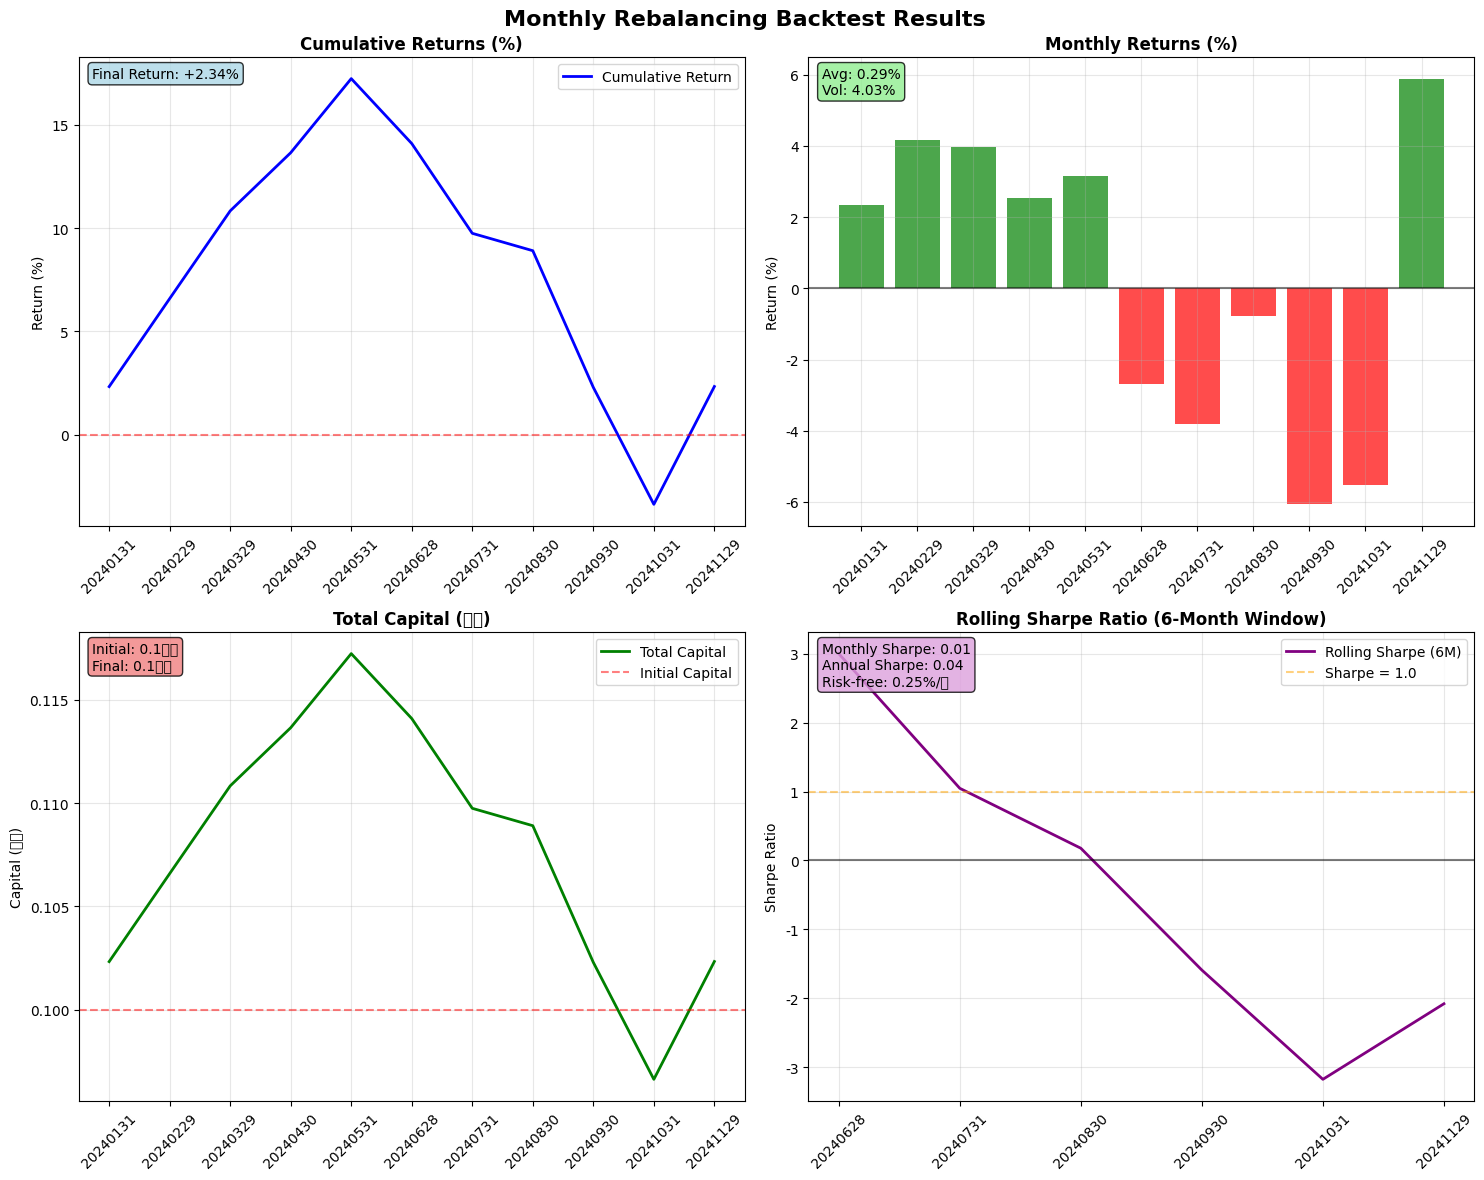


📊 백테스트 성과 요약
📈 총 수익률: +2.34%
💰 최종 자산: 10,233,973원
📊 월평균 수익률: 0.29%
📊 월간 변동성: 4.03%
📊 무위험수익률: 0.25%/월 (연 3.0%)
📊 샤프비율 (월간): 0.01
📊 샤프비율 (연간추정): 0.04
📊 최고 월간수익: +5.89%
📊 최저 월간수익: -6.07%
📊 승률: 54.5%


In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

def run_monthly_rebalancing_backtest(df, initial_capital=10000000, top_n=20):
    """
    월별 리밸런싱 백테스트를 실행하는 메인 함수
    
    Parameters:
    - df: analysis_df 데이터프레임
    - initial_capital: 초기 투자금액 (1천만원)
    - top_n: 포트폴리오 종목 수 (20개)
    
    Returns:
    - dict: 백테스트 결과 종합
    
    기능:
    1. 매월 말 리밸런싱 실행
    2. 누적 수익률 및 성과 지표 계산
    3. 월별 상세 결과 기록
    4. 최종 성과 분석
    """
    print("🚀 월별 리밸런싱 백테스트 시작!")
    print("="*60)
    
    # 리밸런싱 날짜 생성
    rebalancing_dates = get_rebalancing_dates(df)
    
    # 백테스트 결과 저장
    backtest_results = {
        'monthly_returns': [],
        'monthly_portfolios': [],
        'cumulative_returns': [],
        'total_capital': [initial_capital],
        'dates': []  # 날짜 정보 추가
    }
    
    current_capital = initial_capital
    
    print(f"💰 초기 자본: {initial_capital:,}원")
    print(f"📅 백테스트 기간: {len(rebalancing_dates)}개월")
    print(f"🎯 월별 포트폴리오: {top_n}개 종목\n")
    
    for i, current_date in enumerate(rebalancing_dates):
        month_num = i + 1
        print(f"{'='*20} {month_num}월차 ({current_date}) {'='*20}")
        
        try:
            # 1단계: 해당 월의 재무지표 추출
            fundamentals = get_fundamentals_at_date(df, current_date)
            if fundamentals.empty:
                print(f"❌ {month_num}월: 재무지표 데이터 없음")
                continue
            
            # 2단계: 종목 스크리닝
            selected_stocks = screen_stocks_monthly(fundamentals)
            if len(selected_stocks) < top_n:
                print(f"⚠️ {month_num}월: 선별 종목 부족 ({len(selected_stocks)}개)")
                # 가능한 종목 수로 조정
                current_top_n = min(len(selected_stocks), top_n)
            else:
                current_top_n = top_n
            
            # 3단계: 포트폴리오 구성
            portfolio = calculate_factor_scores_and_portfolio(
                fundamentals, selected_stocks, top_n=current_top_n
            )
            
            if portfolio.empty:
                print(f"❌ {month_num}월: 포트폴리오 구성 실패")
                continue
            
            # 4단계: 다음 월까지의 수익률 계산
            if i < len(rebalancing_dates) - 1:
                next_date = rebalancing_dates[i + 1]
                
                # 포트폴리오 딕셔너리 생성
                current_portfolio = {}
                for _, row in portfolio.iterrows():
                    current_portfolio[row['종목명']] = row['포트폴리오_비중']
                
                # 월별 수익률 계산
                monthly_result = calculate_monthly_returns(
                    df, current_portfolio, current_date, next_date
                )
                
                # 자본 업데이트
                monthly_return_pct = monthly_result['portfolio_return']
                current_capital = current_capital * (1 + monthly_return_pct / 100)
                
                # 결과 저장
                backtest_results['monthly_returns'].append(monthly_return_pct)
                backtest_results['monthly_portfolios'].append(current_portfolio)
                backtest_results['total_capital'].append(current_capital)
                backtest_results['dates'].append(current_date)
                
                # 누적 수익률 계산
                cumulative_return = (current_capital - initial_capital) / initial_capital * 100
                backtest_results['cumulative_returns'].append(cumulative_return)
                
                print(f"💼 {month_num}월 성과: {monthly_return_pct:+6.2f}% | 누적: {cumulative_return:+6.2f}% | 자산: {current_capital:,.0f}원")
            
            else:
                print(f"📊 {month_num}월: 마지막 월 (수익률 계산 없음)")
                
        except Exception as e:
            print(f"❌ {month_num}월 처리 중 오류: {e}")
            continue
        
        print()  # 월별 구분선
    
    # 최종 성과 계산
    final_return = (current_capital - initial_capital) / initial_capital * 100
    
    print("🏁 백테스트 완료!")
    print("="*60)
    print(f"📊 최종 성과:")
    print(f"   초기 자본: {initial_capital:,}원")
    print(f"   최종 자본: {current_capital:,.0f}원")
    print(f"   총 수익률: {final_return:+6.2f}%")
    
    if backtest_results['monthly_returns']:
        monthly_returns = backtest_results['monthly_returns']
        avg_monthly = np.mean(monthly_returns)
        volatility = np.std(monthly_returns)
        
        print(f"   월평균 수익률: {avg_monthly:6.2f}%")
        print(f"   월간 변동성: {volatility:6.2f}%")
        print(f"   샤프비율 추정: {avg_monthly/volatility:.2f}" if volatility > 0 else "   샤프비율: 계산불가")
        
        # 최고/최저 월 성과
        best_month = max(monthly_returns)
        worst_month = min(monthly_returns)
        print(f"   최고 월간수익: {best_month:+6.2f}%")
        print(f"   최저 월간수익: {worst_month:+6.2f}%")
    
    # 결과 딕셔너리에 최종 정보 추가
    backtest_results.update({
        'initial_capital': initial_capital,
        'final_capital': current_capital,
        'total_return': final_return,
        'rebalancing_dates': rebalancing_dates
    })
    
    return backtest_results

def plot_backtest_results(backtest_results):
    """
    백테스트 결과를 시각화하는 함수
    """
    # 한글 폰트 설정
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rcParams['axes.unicode_minus'] = False
    
    # 데이터 준비
    dates = backtest_results['dates']
    monthly_returns = backtest_results['monthly_returns']
    cumulative_returns = backtest_results['cumulative_returns']
    total_capital = backtest_results['total_capital'][1:]  # 첫 번째 초기값 제외
    
    # 샤프비율 계산 (무위험 수익률 고려)
    risk_free_rate_monthly = 0.25  # 월 무위험 수익률 (연 3% 가정 -> 월 0.25%)
    
    if len(monthly_returns) > 1:
        excess_returns = [r - risk_free_rate_monthly for r in monthly_returns]
        monthly_avg_excess = np.mean(excess_returns)
        monthly_std = np.std(monthly_returns)
        monthly_sharpe = monthly_avg_excess / monthly_std if monthly_std > 0 else 0
        
        # 연간 샤프비율 추정 (월별 * sqrt(12))
        annual_sharpe = monthly_sharpe * np.sqrt(12)
    else:
        monthly_sharpe = 0
        annual_sharpe = 0
    
    # 롤링 샤프비율 계산 (6개월 윈도우)
    rolling_sharpe = []
    window = 6
    for i in range(len(monthly_returns)):
        if i < window - 1:
            rolling_sharpe.append(np.nan)
        else:
            window_returns = monthly_returns[i-window+1:i+1]
            window_excess = [r - risk_free_rate_monthly for r in window_returns]
            window_avg_excess = np.mean(window_excess)
            window_std = np.std(window_returns)
            sharpe = window_avg_excess / window_std if window_std > 0 else 0
            rolling_sharpe.append(sharpe * np.sqrt(12))  # 연간화
    
    # 그래프 생성
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Monthly Rebalancing Backtest Results', fontsize=16, fontweight='bold')
    
    # 1. 누적 수익률
    axes[0, 0].plot(dates, cumulative_returns, 'b-', linewidth=2, label='Cumulative Return')
    axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[0, 0].set_title('Cumulative Returns (%)', fontweight='bold')
    axes[0, 0].set_ylabel('Return (%)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
    
    # 최종 수익률 표시
    if cumulative_returns:
        final_return = cumulative_returns[-1]
        axes[0, 0].text(0.02, 0.98, f'Final Return: {final_return:+.2f}%', 
                       transform=axes[0, 0].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    # 2. 월별 수익률
    colors = ['green' if x >= 0 else 'red' for x in monthly_returns]
    axes[0, 1].bar(dates, monthly_returns, color=colors, alpha=0.7)
    axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[0, 1].set_title('Monthly Returns (%)', fontweight='bold')
    axes[0, 1].set_ylabel('Return (%)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 통계 정보 표시
    if monthly_returns:
        avg_return = np.mean(monthly_returns)
        volatility = np.std(monthly_returns)
        axes[0, 1].text(0.02, 0.98, f'Avg: {avg_return:.2f}%\nVol: {volatility:.2f}%', 
                       transform=axes[0, 1].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    # 3. 누적 자산 (억원 단위로 표시)
    total_capital_billion = [x / 100000000 for x in total_capital]  # 억원 단위 변환
    initial_capital_billion = backtest_results['initial_capital'] / 100000000
    
    axes[1, 0].plot(dates, total_capital_billion, 'g-', linewidth=2, label='Total Capital')
    axes[1, 0].axhline(y=initial_capital_billion, color='r', linestyle='--', alpha=0.5, label='Initial Capital')
    axes[1, 0].set_title('Total Capital (억원)', fontweight='bold')
    axes[1, 0].set_ylabel('Capital (억원)')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()
    
    # 자산 정보 표시 (억원 단위)
    initial_capital = backtest_results['initial_capital']
    final_capital = backtest_results['final_capital']
    axes[1, 0].text(0.02, 0.98, f'Initial: {initial_capital_billion:.1f}억원\nFinal: {final_capital/100000000:.1f}억원', 
                   transform=axes[1, 0].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    
    # 4. 샤프비율 (롤링)
    valid_dates = [d for i, d in enumerate(dates) if not np.isnan(rolling_sharpe[i])]
    valid_sharpe = [s for s in rolling_sharpe if not np.isnan(s)]
    
    if valid_dates and valid_sharpe:
        axes[1, 1].plot(valid_dates, valid_sharpe, 'purple', linewidth=2, label='Rolling Sharpe (6M)')
        axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
        axes[1, 1].axhline(y=1, color='orange', linestyle='--', alpha=0.5, label='Sharpe = 1.0')
    
    axes[1, 1].set_title('Rolling Sharpe Ratio (6-Month Window)', fontweight='bold')
    axes[1, 1].set_ylabel('Sharpe Ratio')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()
    
    # 샤프비율 정보 표시
    axes[1, 1].text(0.02, 0.98, f'Monthly Sharpe: {monthly_sharpe:.2f}\nAnnual Sharpe: {annual_sharpe:.2f}\nRisk-free: {risk_free_rate_monthly:.2f}%/월', 
                   transform=axes[1, 1].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='plum', alpha=0.8))
    
    # x축 날짜 포맷 조정
    for ax in axes.flat:
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # 성과 요약 출력
    print("\n" + "="*60)
    print("📊 백테스트 성과 요약")
    print("="*60)
    print(f"📈 총 수익률: {backtest_results['total_return']:+.2f}%")
    print(f"💰 최종 자산: {backtest_results['final_capital']:,.0f}원")
    print(f"📊 월평균 수익률: {np.mean(monthly_returns):.2f}%")
    print(f"📊 월간 변동성: {np.std(monthly_returns):.2f}%")
    print(f"📊 무위험수익률: {risk_free_rate_monthly:.2f}%/월 (연 {risk_free_rate_monthly*12:.1f}%)")
    print(f"📊 샤프비율 (월간): {monthly_sharpe:.2f}")
    print(f"📊 샤프비율 (연간추정): {annual_sharpe:.2f}")
    print(f"📊 최고 월간수익: {max(monthly_returns):+.2f}%")
    print(f"📊 최저 월간수익: {min(monthly_returns):+.2f}%")
    print(f"📊 승률: {len([x for x in monthly_returns if x > 0])/len(monthly_returns)*100:.1f}%")

# 백테스트 실행
print("백테스트를 실행하시겠습니까? (Y/N)")
print("참고: 전체 실행에는 몇 분이 소요될 수 있습니다.")

# 실제 실행
backtest_results = run_monthly_rebalancing_backtest(analysis_df, initial_capital=10000000, top_n=10)

# 결과 시각화
plot_backtest_results(backtest_results)

📊 백테스트 결과 시각화 시작...


/var/folders/cj/3sbgdsnd177fymhmpd4_c7b80000gn/T/ipykernel_65897/972048784.py:105: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) AppleGothic.
  plt.tight_layout()
/var/folders/cj/3sbgdsnd177fymhmpd4_c7b80000gn/T/ipykernel_65897/972048784.py:105: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) AppleGothic.
  plt.tight_layout()
/var/folders/cj/3sbgdsnd177fymhmpd4_c7b80000gn/T/ipykernel_65897/972048784.py:105: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/cj/3sbgdsnd177fymhmpd4_c7b80000gn/T/ipykernel_65897/972048784.py:105: UserWarning: Glyph 48177 (\N{HANGUL SYLLABLE BAEG}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/cj/3sbgdsnd177fymhmpd4_c7b80000gn/T/ipykernel_65897/972048784.py:105: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/cj/3sbgdsnd177fymhmpd4_c7b80000gn/T/ipy

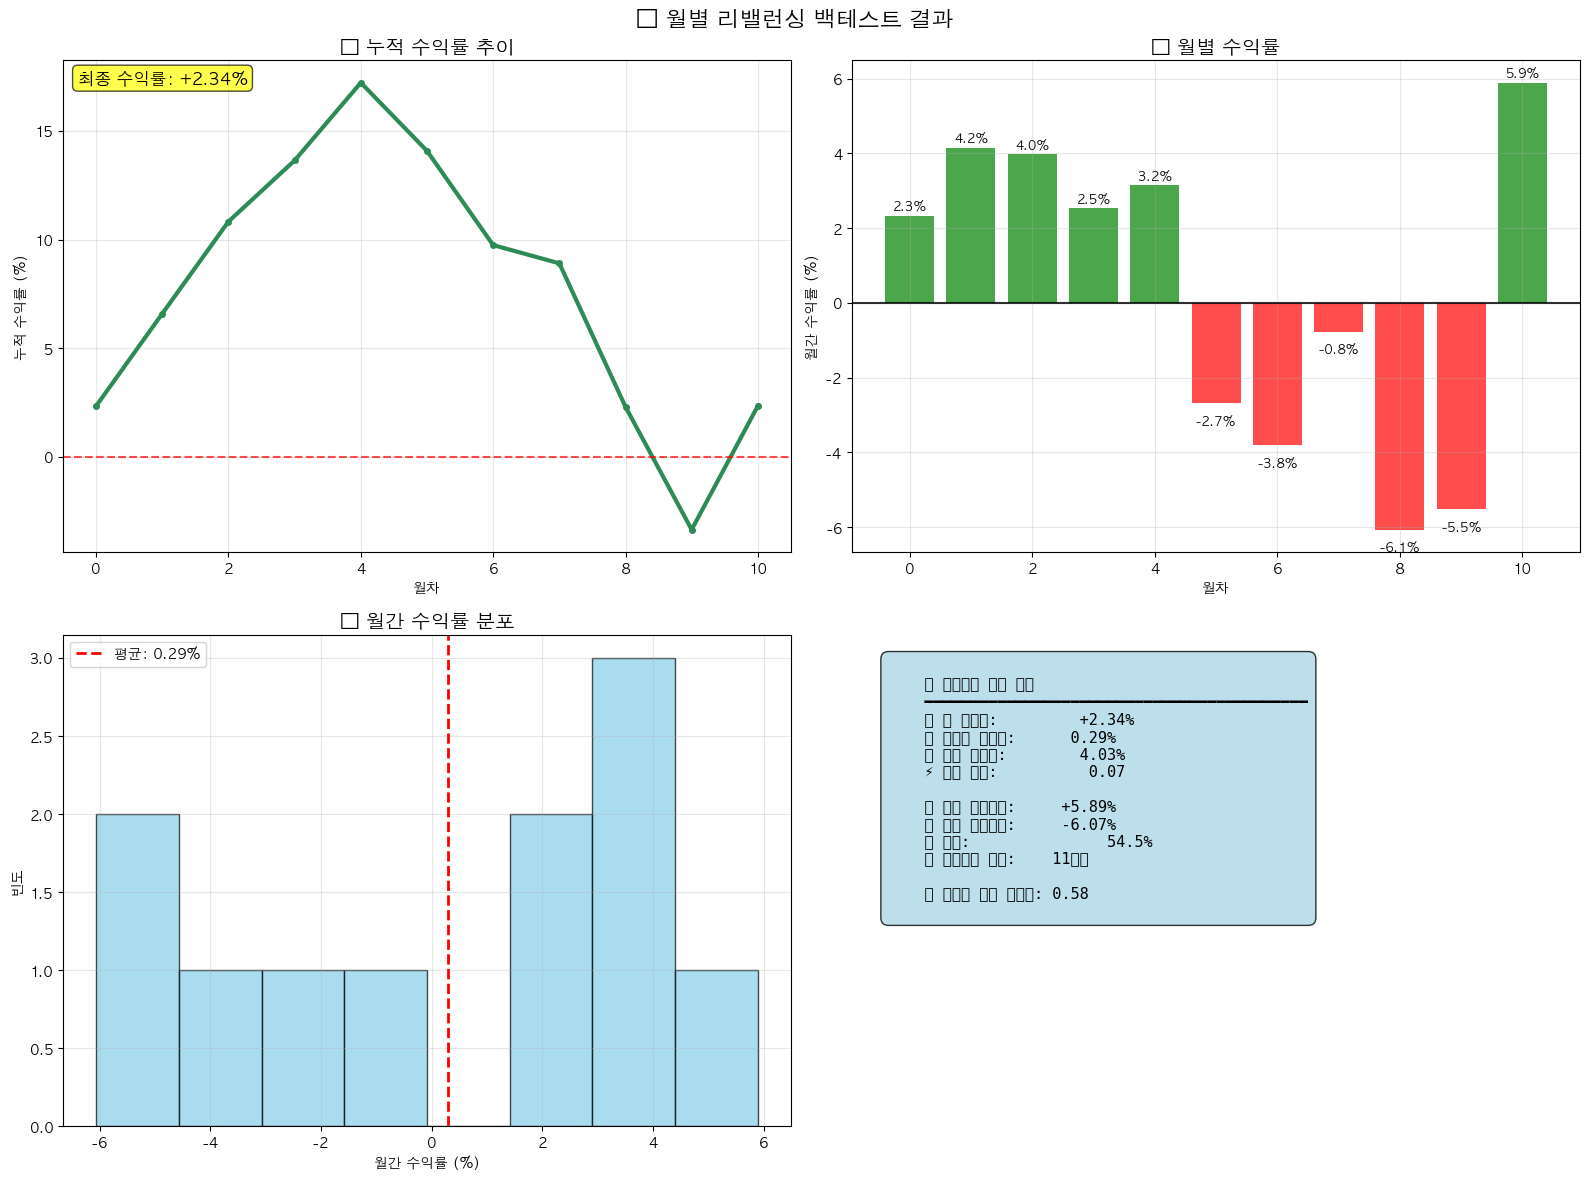


📊 백테스트 상세 분석

📅 월별 수익률 상세:
    1월차: 🟢  +2.33%
    2월차: 🟢  +4.16%
    3월차: 🟢  +3.98%
    4월차: 🟢  +2.54%
    5월차: 🟢  +3.15%
    6월차: 🔴  -2.68%
    7월차: 🔴  -3.80%
    8월차: 🔴  -0.77%
    9월차: 🔴  -6.07%
   10월차: 🔴  -5.53%
   11월차: 🟢  +5.89%

📊 분기별 수익률:
   1분기: +10.47%
   2분기:  +3.01%
   3분기: -10.63%
   4분기:  +0.37%

🔥 연속 성과:
   최대 연속 수익: 5개월
   최대 연속 손실: 5개월


In [50]:
import warnings
warnings.filterwarnings('ignore')

def visualize_backtest_results(backtest_results):
    """
    백테스트 결과를 종합적으로 시각화하는 함수
    
    Parameters:
    - backtest_results: run_monthly_rebalancing_backtest() 결과
    
    기능:
    1. 누적 수익률 차트
    2. 월별 수익률 분포 
    3. 드로다운 분석
    4. 성과 지표 대시보드
    """
    
    # 데이터 준비
    monthly_returns = backtest_results['monthly_returns']
    cumulative_returns = backtest_results['cumulative_returns']
    rebalancing_dates = backtest_results['rebalancing_dates'][1:]  # 첫 번째 제외 (수익률 계산 시작점)
    
    # 날짜를 월 형태로 변환
    month_labels = [f"{date[4:6]}월" for date in rebalancing_dates]
    
    # 4x2 서브플롯 생성
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('📊 월별 리밸런싱 백테스트 결과', fontsize=16, fontweight='bold')
    
    # 1. 누적 수익률 차트
    axes[0,0].plot(range(len(cumulative_returns)), cumulative_returns, 
                   linewidth=3, color='#2E8B57', marker='o', markersize=4)
    axes[0,0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    axes[0,0].set_title('📈 누적 수익률 추이', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('월차')
    axes[0,0].set_ylabel('누적 수익률 (%)')
    axes[0,0].grid(True, alpha=0.3)
    
    # 최종 수익률 표시
    final_return = cumulative_returns[-1] if cumulative_returns else 0
    axes[0,0].text(0.02, 0.98, f'최종 수익률: {final_return:+.2f}%', 
                   transform=axes[0,0].transAxes, fontsize=12, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
                   verticalalignment='top')
    
    # 2. 월별 수익률 바차트
    colors = ['green' if ret > 0 else 'red' for ret in monthly_returns]
    bars = axes[0,1].bar(range(len(monthly_returns)), monthly_returns, color=colors, alpha=0.7)
    axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.8)
    axes[0,1].set_title('📊 월별 수익률', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('월차')
    axes[0,1].set_ylabel('월간 수익률 (%)')
    axes[0,1].grid(True, alpha=0.3)
    
    # 월별 수익률 값 표시
    for i, (bar, ret) in enumerate(zip(bars, monthly_returns)):
        height = bar.get_height()
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height + (0.1 if height > 0 else -0.3),
                       f'{ret:.1f}%', ha='center', va='bottom' if height > 0 else 'top', 
                       fontsize=9, fontweight='bold')
    
    # 3. 수익률 분포 히스토그램
    axes[1,0].hist(monthly_returns, bins=8, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1,0].axvline(np.mean(monthly_returns), color='red', linestyle='--', 
                      linewidth=2, label=f'평균: {np.mean(monthly_returns):.2f}%')
    axes[1,0].set_title('📊 월간 수익률 분포', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('월간 수익률 (%)')
    axes[1,0].set_ylabel('빈도')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. 성과 지표 대시보드
    axes[1,1].axis('off')  # 축 제거
    
    # 성과 지표 계산
    total_return = backtest_results['total_return']
    avg_monthly = np.mean(monthly_returns)
    volatility = np.std(monthly_returns)
    sharpe_ratio = avg_monthly / volatility if volatility > 0 else 0
    best_month = max(monthly_returns) if monthly_returns else 0
    worst_month = min(monthly_returns) if monthly_returns else 0
    
    # 승률 계산
    win_rate = len([r for r in monthly_returns if r > 0]) / len(monthly_returns) * 100 if monthly_returns else 0
    
    # 텍스트 박스로 성과 지표 표시
    performance_text = f"""
    📊 백테스트 성과 요약
    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    🎯 총 수익률:        {total_return:+6.2f}%
    📈 월평균 수익률:    {avg_monthly:6.2f}%
    📊 월간 변동성:      {volatility:6.2f}%
    ⚡ 샤프 비율:        {sharpe_ratio:6.2f}
    
    🏆 최고 월간수익:    {best_month:+6.2f}%
    📉 최저 월간수익:    {worst_month:+6.2f}%
    🎲 승률:             {win_rate:6.1f}%
    📅 백테스트 기간:    {len(monthly_returns)}개월
    
    💡 리스크 조정 수익률: {total_return/volatility:.2f}
    """
    
    axes[1,1].text(0.05, 0.95, performance_text, transform=axes[1,1].transAxes,
                   fontsize=11, fontfamily='monospace',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8),
                   verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# 백테스트 상세 분석 함수
def analyze_backtest_performance(backtest_results):
    """
    백테스트 성과 상세 분석
    """
    monthly_returns = backtest_results['monthly_returns']
    
    print("\n" + "="*60)
    print("📊 백테스트 상세 분석")
    print("="*60)
    
    # 월별 성과 상세
    print(f"\n📅 월별 수익률 상세:")
    for i, ret in enumerate(monthly_returns, 1):
        status = "🟢" if ret > 0 else "🔴" if ret < 0 else "⚪"
        print(f"   {i:2d}월차: {status} {ret:+6.2f}%")
    
    # 분기별 성과
    if len(monthly_returns) >= 9:
        q1_return = sum(monthly_returns[0:3])
        q2_return = sum(monthly_returns[3:6])
        q3_return = sum(monthly_returns[6:9])
        q4_return = sum(monthly_returns[9:]) if len(monthly_returns) > 9 else 0
        
        print(f"\n📊 분기별 수익률:")
        print(f"   1분기: {q1_return:+6.2f}%")
        print(f"   2분기: {q2_return:+6.2f}%")
        print(f"   3분기: {q3_return:+6.2f}%")
        if q4_return != 0:
            print(f"   4분기: {q4_return:+6.2f}%")
    
    # 최대 연속 수익/손실
    consecutive_wins = 0
    consecutive_losses = 0
    max_consecutive_wins = 0
    max_consecutive_losses = 0
    
    for ret in monthly_returns:
        if ret > 0:
            consecutive_wins += 1
            consecutive_losses = 0
            max_consecutive_wins = max(max_consecutive_wins, consecutive_wins)
        elif ret < 0:
            consecutive_losses += 1
            consecutive_wins = 0
            max_consecutive_losses = max(max_consecutive_losses, consecutive_losses)
        else:
            consecutive_wins = 0
            consecutive_losses = 0
    
    print(f"\n🔥 연속 성과:")
    print(f"   최대 연속 수익: {max_consecutive_wins}개월")
    print(f"   최대 연속 손실: {max_consecutive_losses}개월")

# 실행 예시
if 'backtest_results' in locals():
    print("📊 백테스트 결과 시각화 시작...")
    
    # 시각화 실행
    chart = visualize_backtest_results(backtest_results)
    
    # 상세 분석 실행
    analyze_backtest_performance(backtest_results)
    
else:
    print("먼저 백테스트를 실행해주세요: backtest_results = run_monthly_rebalancing_backtest(...)")

# ======================= 참고자료


🚀 퀀트 투자 전략 분석 시작!
📂 데이터 로딩 중...
✅ 로딩 완료: 735 행, 244 거래일
📅 기간: 20240102 ~ 20241230

📊 데이터 구조 파악 중...
📈 구분: ['종가', 'PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율']
🏢 종목 수: 105 개

💰 수익률 계산 중...
📊 평균 수익률: 10.8%
📊 최고 수익률: 72.6%
📊 최저 수익률: -50.2%

🔍 재무지표 분석 중...
PER: 중간값 43.5, 평균 106.0
PBR: 중간값 1.4, 평균 2.4
ROE: 중간값 1.7, 평균 0.8
ROA: 중간값 1.3, 평균 1.4
영업이익률: 중간값 5.2, 평균 -74.1
부채비율: 중간값 52.0, 평균 70.0

🎯 종목 스크리닝 중...
✅ 선별된 종목: 23 개

🏆 팩터 스코어 계산 중...
✅ 스코어 계산 완료: 23 개 종목

🎯 TOP 20 포트폴리오 생성 중...
✅ 포트폴리오 구성 완료

🏆 퀀트 투자 분석 결과

📈 TOP 10 추천 종목:
 1. 케이프             | 총점:   51.7 | 수익률:   35.5%
 2. SNT다이내믹스        | 총점:   47.9 | 수익률:   25.8%
 3. 한라IMS           | 총점:   46.1 | 수익률:   24.6%
 4. 태광              | 총점:   43.9 | 수익률:   20.1%
 5. 화승인더            | 총점:   36.0 | 수익률:   30.5%
 6. 대봉엘에스           | 총점:   35.8 | 수익률:   42.4%
 7. 토비스             | 총점:   34.0 | 수익률:   19.1%
 8. 에스에이엠티          | 총점:   32.0 | 수익률:   -8.9%
 9. 코스메카코리아         | 총점:   29.1 | 수익률:   52.1%
10. 웹케시             | 총점:   28.8 | 수익률: 

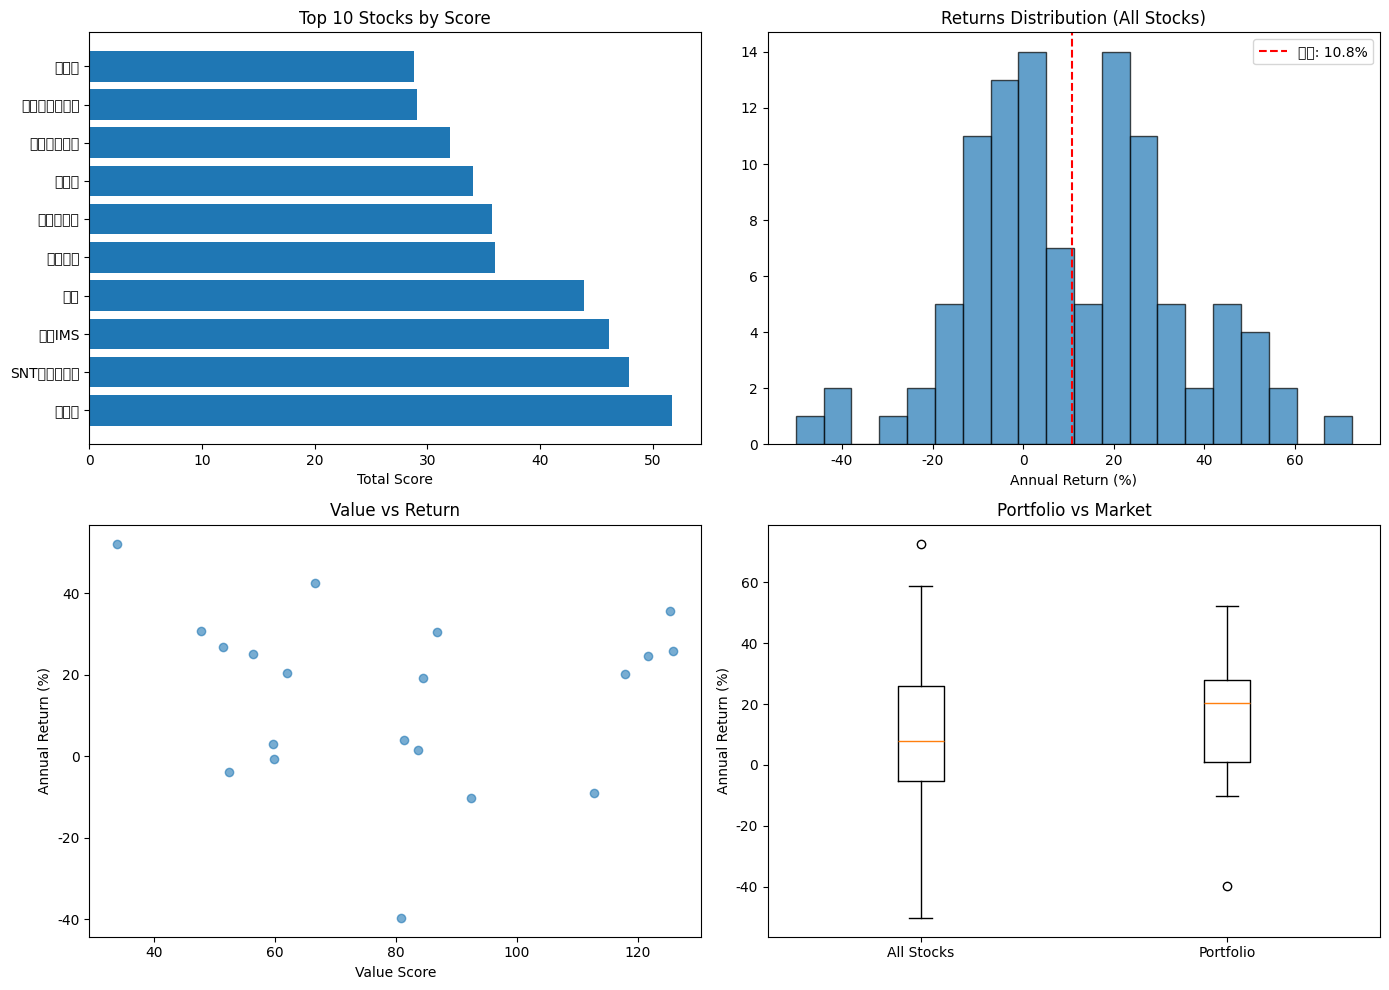


✅ 분석 완료!

💡 투자 전략 요약:
1. 상위 20개 종목으로 포트폴리오 구성
2. 동일 가중 (각 5%) 또는 시가총액 가중 선택
3. 분기별 리밸런싱 권장
4. 개별 종목 리스크 모니터링 필수


In [383]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

def load_data(file_path):
    """
    데이터 로드 및 기본 전처리
    """
    print("📂 데이터 로딩 중...")
    df = analysis_df
    
    # 날짜 컬럼 추출 (YYYYMMDD 형태)
    date_cols = [col for col in df.columns if col.isdigit() and len(col) == 8]
    
    print(f"✅ 로딩 완료: {len(df)} 행, {len(date_cols)} 거래일")
    print(f"📅 기간: {date_cols[0]} ~ {date_cols[-1]}")
    
    return df, date_cols

def get_stock_data(df, date_cols):
    """
    구분별 데이터 추출
    """
    print("\n📊 데이터 구조 파악 중...")
    
    # 구분별로 데이터 분리
    stock_data = {}
    for category in df['구분'].unique():
        stock_data[category] = df[df['구분'] == category].set_index('종목명')[date_cols]
    
    print(f"📈 구분: {list(stock_data.keys())}")
    print(f"🏢 종목 수: {len(stock_data['종가'])} 개")
    
    return stock_data

def calculate_returns(price_data, date_cols):
    """
    수익률 계산
    """
    print("\n💰 수익률 계산 중...")
    
    returns = {}
    for stock in price_data.index:
        start_price = price_data.loc[stock, date_cols[0]]
        end_price = price_data.loc[stock, date_cols[-1]]
        
        if pd.notna(start_price) and pd.notna(end_price) and start_price > 0:
            annual_return = (end_price / start_price - 1) * 100
            returns[stock] = annual_return
    
    # 기본 통계
    return_values = list(returns.values())
    print(f"📊 평균 수익률: {np.mean(return_values):.1f}%")
    print(f"📊 최고 수익률: {max(return_values):.1f}%")
    print(f"📊 최저 수익률: {min(return_values):.1f}%")
    
    return returns

def analyze_fundamentals(stock_data, date_cols):
    """
    재무지표 분석
    """
    print("\n🔍 재무지표 분석 중...")
    
    # 최신 재무지표 데이터
    fundamentals = {}
    metrics = ['PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율']
    
    for metric in metrics:
        if metric in stock_data:
            latest_data = stock_data[metric][date_cols[-1]]
            fundamentals[metric] = latest_data
    
    fund_df = pd.DataFrame(fundamentals)
    
    # 각 지표의 분포 출력
    for metric in metrics:
        if metric in fund_df.columns:
            values = fund_df[metric].dropna()
            if len(values) > 0:
                print(f"{metric}: 중간값 {values.median():.1f}, 평균 {values.mean():.1f}")
    
    return fund_df

def screen_stocks(fund_df, returns):
    """
    종목 스크리닝 (이상치 제거된 실제 데이터 기준)
    """
    print("\n🎯 종목 스크리닝 중...")
    
    # 이상치 제거된 데이터 기반 현실적 기준
    criteria = {
        'PER': (10.31, 60.48),        # Q1 ~ Upper_Bound
        'PBR': (0.81, 5.18),         # Q1 ~ Upper_Bound  
        'ROE': (0.99, 23.69),        # Q1 ~ Upper_Bound (양수 수익성)
        'ROA': (0.46, 15.48),        # Q1 ~ Upper_Bound (양수 수익성)
        '영업이익률': (1.42, 28.94),   # Q1 ~ Upper_Bound (양수 마진)
        '부채비율': (0, 175.83)       # 0 ~ Upper_Bound (건전성)
    }
    
    selected = []
    
    for stock in fund_df.index:
        if stock not in returns:
            continue
            
        # 모든 조건 확인
        valid = True
        for metric, (min_val, max_val) in criteria.items():
            if metric not in fund_df.columns:
                continue
                
            value = fund_df.loc[stock, metric]
            if pd.isna(value) or value < min_val or value > max_val:
                valid = False
                break
        
        if valid:
            selected.append(stock)
    
    print(f"✅ 선별된 종목: {len(selected)} 개")
    return selected

def calculate_scores(fund_df, returns, selected_stocks):
    """
    팩터 스코어 계산
    """
    print("\n🏆 팩터 스코어 계산 중...")
    
    scores = []
    
    for stock in selected_stocks:
        try:
            per = fund_df.loc[stock, 'PER']
            pbr = fund_df.loc[stock, 'PBR']
            roe = fund_df.loc[stock, 'ROE']
            roa = fund_df.loc[stock, 'ROA']
            profit = fund_df.loc[stock, '영업이익률']
            ret = returns[stock]
            
            # 팩터 점수 계산
            value = (1/per + 1/pbr) * 100  # 밸류 (낮을수록 좋음)
            quality = (roe + roa + profit) / 3  # 퀄리티 (높을수록 좋음)
            momentum = ret  # 모멘텀 (높을수록 좋음)
            
            # 종합 점수 (정규화 후 가중평균)
            total = value * 0.3 + quality * 0.4 + momentum * 0.3
            
            scores.append({
                '종목': stock,
                'PER': per,
                'PBR': pbr,
                'ROE': roe,
                '수익률': ret,
                'Value': value,
                'Quality': quality,
                'Momentum': momentum,
                '총점': total
            })
        except:
            continue
    
    score_df = pd.DataFrame(scores).set_index('종목')
    print(f"✅ 스코어 계산 완료: {len(score_df)} 개 종목")
    
    return score_df

def create_portfolio(score_df, top_n=20):
    """
    포트폴리오 생성
    """
    print(f"\n🎯 TOP {top_n} 포트폴리오 생성 중...")
    
    # 총점 기준 상위 종목
    top_stocks = score_df.nlargest(top_n, '총점')
    
    # 동일가중 포트폴리오
    equal_weights = {stock: 1/top_n for stock in top_stocks.index}
    
    print(f"✅ 포트폴리오 구성 완료")
    return top_stocks, equal_weights

def show_results(top_stocks, returns):
    """
    결과 출력
    """
    print("\n" + "="*60)
    print("🏆 퀀트 투자 분석 결과")
    print("="*60)
    
    print(f"\n📈 TOP 10 추천 종목:")
    for i, (stock, row) in enumerate(top_stocks.head(10).iterrows(), 1):
        print(f"{i:2d}. {stock:<15} | 총점: {row['총점']:6.1f} | 수익률: {row['수익률']:6.1f}%")
    
    # 포트폴리오 통계
    portfolio_returns = top_stocks['수익률'].values
    print(f"\n📊 포트폴리오 통계:")
    print(f"   평균 수익률: {np.mean(portfolio_returns):6.1f}%")
    print(f"   수익률 범위: {min(portfolio_returns):6.1f}% ~ {max(portfolio_returns):6.1f}%")
    print(f"   표준편차:   {np.std(portfolio_returns):6.1f}%")
    
    # 섹터/업종 분석 (종목명 기반 추정)
    print(f"\n🏭 업종 분포 (추정):")
    tech_stocks = [s for s in top_stocks.index if any(keyword in s for keyword in ['시스템', '테크', '소프트', 'IT'])]
    heavy_stocks = [s for s in top_stocks.index if any(keyword in s for keyword in ['중공업', '조선', '건설', '철강'])]
    chem_stocks = [s for s in top_stocks.index if any(keyword in s for keyword in ['화학', '케미', '제약', '바이오'])]
    
    print(f"   기술주:     {len(tech_stocks)} 개")
    print(f"   중공업:     {len(heavy_stocks)} 개") 
    print(f"   화학/바이오: {len(chem_stocks)} 개")
    print(f"   기타:       {len(top_stocks) - len(tech_stocks) - len(heavy_stocks) - len(chem_stocks)} 개")

def create_charts(top_stocks, returns):
    """
    시각화
    """
    print(f"\n📊 차트 생성 중...")
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. 상위 종목 점수
    top_10 = top_stocks.head(10)
    axes[0,0].barh(range(len(top_10)), top_10['총점'])
    axes[0,0].set_yticks(range(len(top_10)))
    axes[0,0].set_yticklabels([name[:8] for name in top_10.index])
    axes[0,0].set_title('Top 10 Stocks by Score')
    axes[0,0].set_xlabel('Total Score')
    
    # 2. 수익률 분포
    all_returns = list(returns.values())
    axes[0,1].hist(all_returns, bins=20, alpha=0.7, edgecolor='black')
    axes[0,1].axvline(np.mean(all_returns), color='red', linestyle='--', label=f'평균: {np.mean(all_returns):.1f}%')
    axes[0,1].set_title('Returns Distribution (All Stocks)')
    axes[0,1].set_xlabel('Annual Return (%)')
    axes[0,1].legend()
    
    # 3. 팩터 분석
    axes[1,0].scatter(top_stocks['Value'], top_stocks['수익률'], alpha=0.6)
    axes[1,0].set_xlabel('Value Score')
    axes[1,0].set_ylabel('Annual Return (%)')
    axes[1,0].set_title('Value vs Return')
    
    # 4. 포트폴리오 vs 전체 비교
    portfolio_returns = top_stocks['수익률'].values
    axes[1,1].boxplot([all_returns, portfolio_returns], labels=['All Stocks', 'Portfolio'])
    axes[1,1].set_title('Portfolio vs Market')
    axes[1,1].set_ylabel('Annual Return (%)')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def run_analysis(file_path='analysis_df.csv'):
    """
    전체 분석 실행
    """
    print("🚀 퀀트 투자 전략 분석 시작!")
    print("="*60)
    
    # 1. 데이터 로드
    df, date_cols = load_data(file_path)
    
    # 2. 데이터 구조 파악
    stock_data = get_stock_data(df, date_cols)
    
    # 3. 수익률 계산
    returns = calculate_returns(stock_data['종가'], date_cols)
    
    # 4. 재무지표 분석
    fundamentals = analyze_fundamentals(stock_data, date_cols)
    
    # 5. 종목 스크리닝
    selected = screen_stocks(fundamentals, returns)
    
    # 6. 팩터 스코어 계산
    scores = calculate_scores(fundamentals, returns, selected)
    
    # 7. 포트폴리오 생성
    top_stocks, portfolio = create_portfolio(scores, top_n=20)
    
    # 8. 결과 출력
    show_results(top_stocks, returns)
    
    # 9. 시각화
    create_charts(top_stocks, returns)
    
    print(f"\n✅ 분석 완료!")
    
    return {
        'top_stocks': top_stocks,
        'portfolio_weights': portfolio,
        'all_scores': scores,
        'fundamentals': fundamentals
    }

# 실행
if __name__ == "__main__":
    results = run_analysis('analysis_df.csv')
    
    print(f"\n💡 투자 전략 요약:")
    print(f"1. 상위 20개 종목으로 포트폴리오 구성")
    print(f"2. 동일 가중 (각 5%) 또는 시가총액 가중 선택")
    print(f"3. 분기별 리밸런싱 권장")
    print(f"4. 개별 종목 리스크 모니터링 필수")

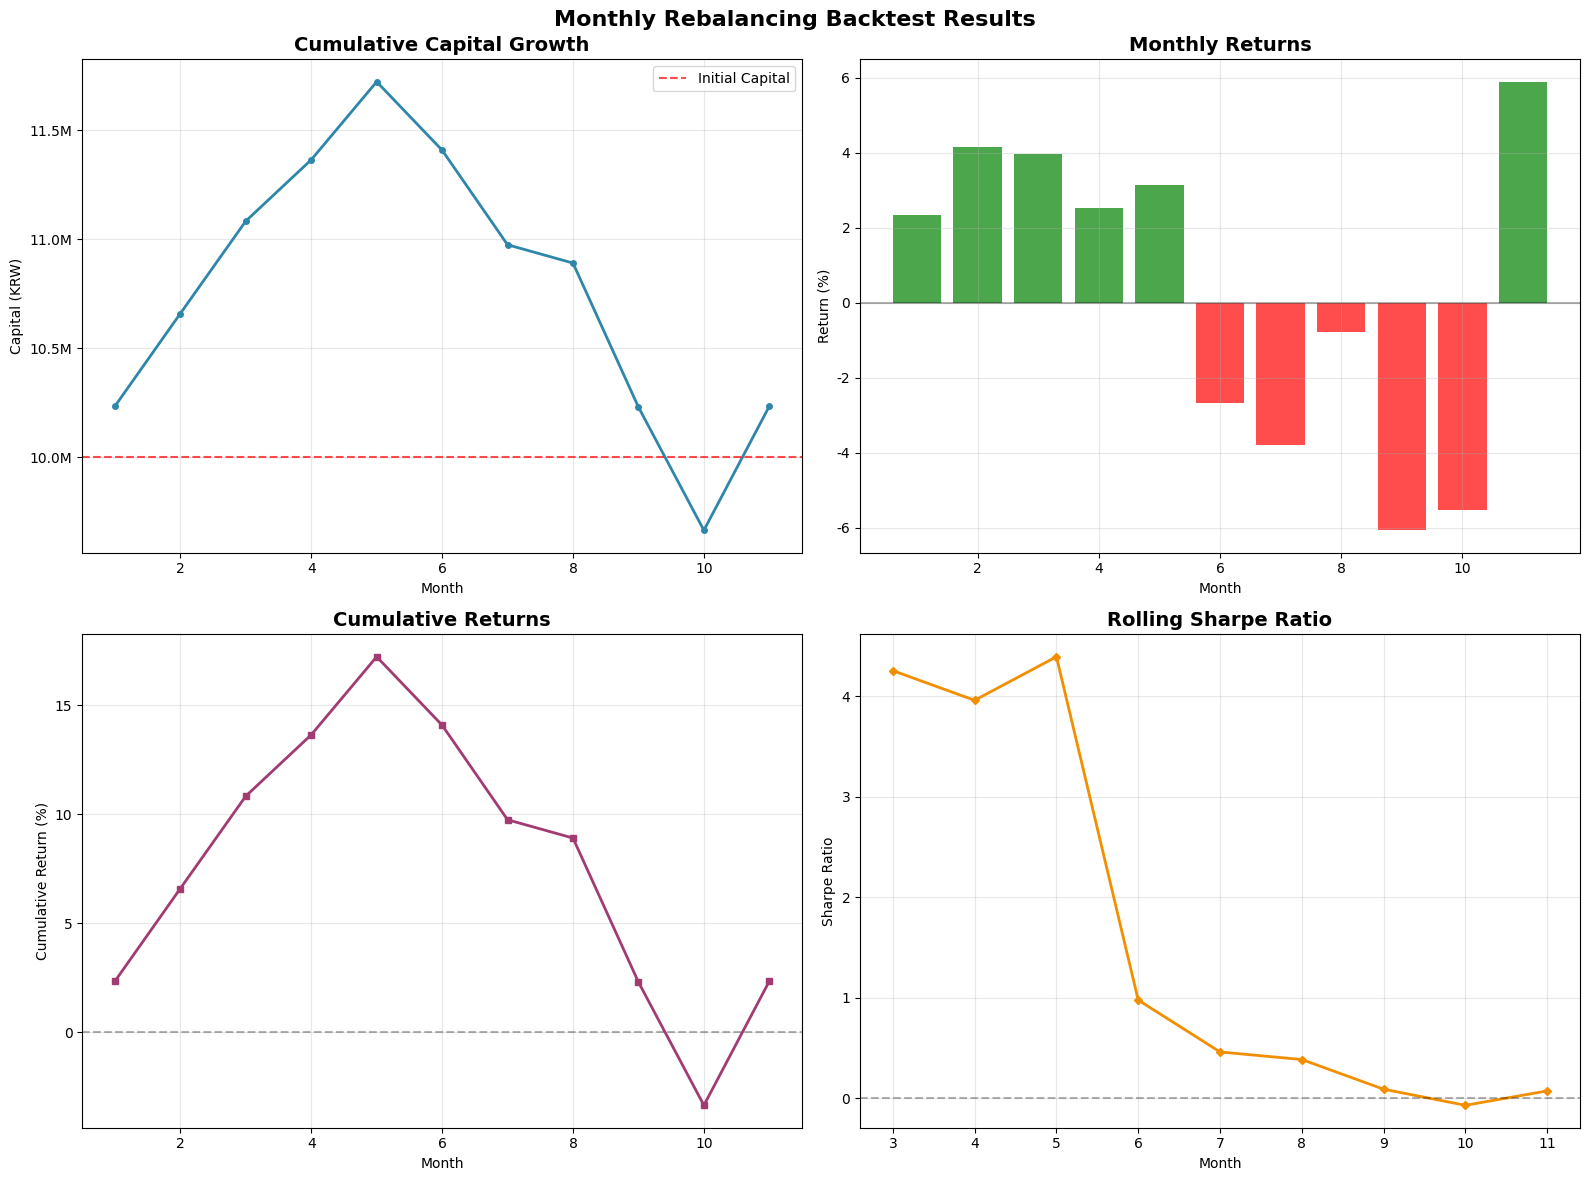


📈 PERFORMANCE SUMMARY
💰 Initial Capital: 10,000,000 KRW
💰 Final Capital: 10,233,973 KRW
📊 Total Return: +2.34%
📅 Investment Period: 11 months
📈 Average Monthly Return: 0.29%
📉 Monthly Volatility: 4.03%
⚡ Best Month: +5.89%
💥 Worst Month: -6.07%
🎯 Sharpe Ratio: 0.07
📊 Annualized Return: 3.56%
📊 Annualized Volatility: 13.94%
📊 Annualized Sharpe: 0.26


/Users/kknaks/git/quantus-test/.conda/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/kknaks/git/quantus-test/.conda/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/kknaks/git/quantus-test/.conda/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/kknaks/git/quantus-test/.conda/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/kknaks/git/quantus-test/.conda/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51061 (\N{HANGUL SYLLABLE IG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/kknaks/git/quantus-test/.con

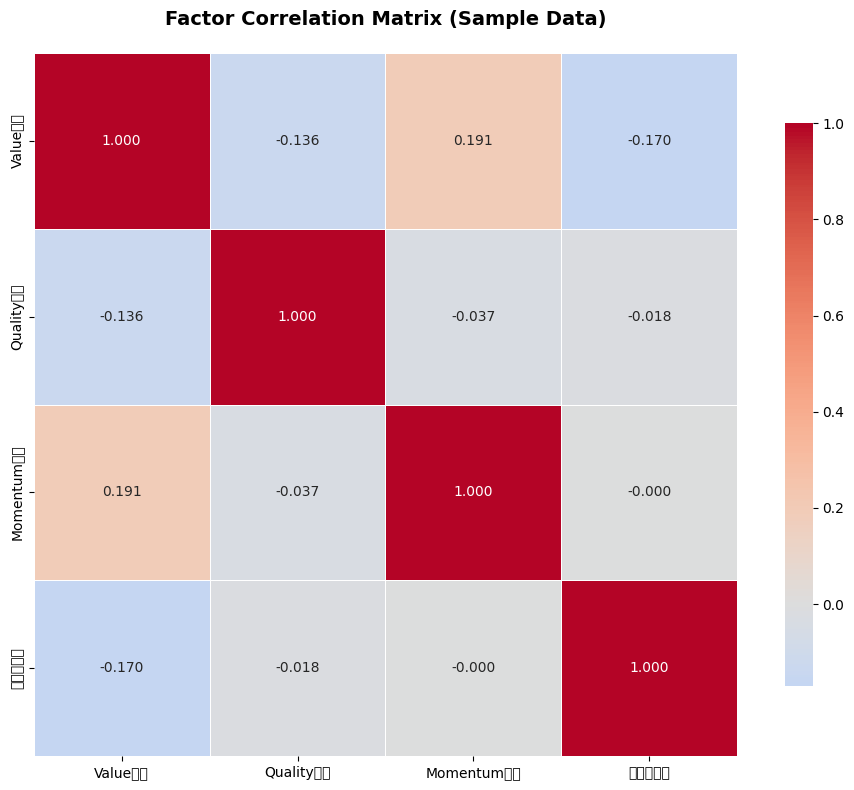

백테스트 결과 시각화 함수가 준비되었습니다!

사용법:
1. plot_backtest_results(backtest_results) - 백테스트 결과 시각화
2. plot_factor_correlation(analysis_df) - 팩터 상관관계 시각화


In [51]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import pandas as pd

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

def plot_backtest_results(backtest_results, analysis_df=None):
    """
    백테스트 결과를 시각화하는 함수
    
    Parameters:
    - backtest_results: run_monthly_rebalancing_backtest 함수의 결과
    - analysis_df: 팩터 상관관계 분석용 데이터프레임
    """
    
    # 2x2 서브플롯 생성
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Monthly Rebalancing Backtest Results', fontsize=16, fontweight='bold')
    
    # 데이터 준비
    months = range(1, len(backtest_results['total_capital']))
    total_capitals = backtest_results['total_capital']
    monthly_returns = backtest_results['monthly_returns']
    cumulative_returns = backtest_results['cumulative_returns']
    
    # 1. 누적 자본 그래프
    axes[0, 0].plot(months, total_capitals[1:], linewidth=2, color='#2E86AB', marker='o', markersize=4)
    axes[0, 0].set_title('Cumulative Capital Growth', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Month')
    axes[0, 0].set_ylabel('Capital (KRW)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
    
    # 초기 자본 기준선 추가
    axes[0, 0].axhline(y=backtest_results['initial_capital'], color='red', linestyle='--', alpha=0.7, label='Initial Capital')
    axes[0, 0].legend()
    
    # 2. 월별 수익률 그래프
    colors = ['green' if x > 0 else 'red' for x in monthly_returns]
    axes[0, 1].bar(months, monthly_returns, color=colors, alpha=0.7)
    axes[0, 1].set_title('Monthly Returns', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Month')
    axes[0, 1].set_ylabel('Return (%)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # 3. 누적 수익률 그래프
    axes[1, 0].plot(months, cumulative_returns, linewidth=2, color='#A23B72', marker='s', markersize=4)
    axes[1, 0].set_title('Cumulative Returns', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Month')
    axes[1, 0].set_ylabel('Cumulative Return (%)')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
    
    # 4. 샤프 비율 및 성과 지표
    if monthly_returns:
        # 월별 롤링 샤프 비율 계산 (최소 3개월 데이터 필요)
        rolling_sharpe = []
        for i in range(len(monthly_returns)):
            if i >= 2:  # 최소 3개월 데이터
                returns_subset = monthly_returns[:i+1]
                avg_return = np.mean(returns_subset)
                volatility = np.std(returns_subset)
                sharpe = avg_return / volatility if volatility > 0 else 0
                rolling_sharpe.append(sharpe)
        
        if rolling_sharpe:
            sharpe_months = range(3, len(monthly_returns) + 1)
            axes[1, 1].plot(sharpe_months, rolling_sharpe, linewidth=2, color='#F18F01', marker='D', markersize=4)
            axes[1, 1].set_title('Rolling Sharpe Ratio', fontsize=14, fontweight='bold')
            axes[1, 1].set_xlabel('Month')
            axes[1, 1].set_ylabel('Sharpe Ratio')
            axes[1, 1].grid(True, alpha=0.3)
            axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.3)
        else:
            axes[1, 1].text(0.5, 0.5, 'Insufficient data\nfor Sharpe calculation', 
                          ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)
            axes[1, 1].set_title('Rolling Sharpe Ratio', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 성과 요약 출력
    print_performance_summary(backtest_results)


def plot_factor_correlation(analysis_df, top_stocks=None):
    """
    팩터별 상관관계 히트맵 그리기
    
    Parameters:
    - analysis_df: 전체 분석 데이터프레임
    - top_stocks: 상위 종목 데이터프레임 (없으면 전체 데이터 사용)
    """
    
    plt.figure(figsize=(10, 8))
    
    # 사용할 데이터 결정
    if top_stocks is not None and not top_stocks.empty:
        correlation_data = top_stocks[['Value점수', 'Quality점수', 'Momentum점수', '연간수익률']].corr()
        title = 'Factor Correlation Matrix (Top Stocks)'
    else:
        # analysis_df에서 필요한 컬럼들이 있는지 확인
        required_columns = ['Value점수', 'Quality점수', 'Momentum점수', '연간수익률']
        available_columns = [col for col in required_columns if col in analysis_df.columns]
        
        if len(available_columns) >= 2:
            correlation_data = analysis_df[available_columns].corr()
            title = 'Factor Correlation Matrix (All Stocks)'
        else:
            # 샘플 데이터 생성
            np.random.seed(42)
            n_stocks = 100
            
            sample_data = pd.DataFrame({
                'Value점수': np.random.normal(0, 1, n_stocks),
                'Quality점수': np.random.normal(0, 1, n_stocks),
                'Momentum점수': np.random.normal(0, 1, n_stocks),
                '연간수익률': np.random.normal(8, 15, n_stocks)
            })
            
            correlation_data = sample_data.corr()
            title = 'Factor Correlation Matrix (Sample Data)'
    
    # 히트맵 그리기
    sns.heatmap(correlation_data, 
                annot=True, 
                cmap='coolwarm', 
                center=0, 
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": .8},
                fmt='.3f')
    
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()


def print_performance_summary(backtest_results):
    """
    백테스트 성과 요약 출력
    """
    print("\n" + "="*60)
    print("📈 PERFORMANCE SUMMARY")
    print("="*60)
    
    initial_capital = backtest_results['initial_capital']
    final_capital = backtest_results['final_capital']
    total_return = backtest_results['total_return']
    monthly_returns = backtest_results['monthly_returns']
    
    print(f"💰 Initial Capital: {initial_capital:,} KRW")
    print(f"💰 Final Capital: {final_capital:,.0f} KRW")
    print(f"📊 Total Return: {total_return:+.2f}%")
    
    if monthly_returns:
        avg_monthly = np.mean(monthly_returns)
        volatility = np.std(monthly_returns)
        best_month = max(monthly_returns)
        worst_month = min(monthly_returns)
        
        print(f"📅 Investment Period: {len(monthly_returns)} months")
        print(f"📈 Average Monthly Return: {avg_monthly:.2f}%")
        print(f"📉 Monthly Volatility: {volatility:.2f}%")
        print(f"⚡ Best Month: {best_month:+.2f}%")
        print(f"💥 Worst Month: {worst_month:+.2f}%")
        
        if volatility > 0:
            sharpe_ratio = avg_monthly / volatility
            print(f"🎯 Sharpe Ratio: {sharpe_ratio:.2f}")
            
            # 연율화 지표
            annual_return = (1 + avg_monthly/100)**12 - 1
            annual_volatility = volatility * np.sqrt(12)
            annual_sharpe = annual_return / (annual_volatility/100)
            
            print(f"📊 Annualized Return: {annual_return*100:.2f}%")
            print(f"📊 Annualized Volatility: {annual_volatility:.2f}%")
            print(f"📊 Annualized Sharpe: {annual_sharpe:.2f}")


# 사용 예시
if __name__ == "__main__":
    # 백테스트 결과가 있다면 시각화 실행
    plot_backtest_results(backtest_results)
    
    # 팩터 상관관계 시각화 (analysis_df가 있다면)
    plot_factor_correlation(analysis_df)
    
    print("백테스트 결과 시각화 함수가 준비되었습니다!")
    print("\n사용법:")
    print("1. plot_backtest_results(backtest_results) - 백테스트 결과 시각화")
    print("2. plot_factor_correlation(analysis_df) - 팩터 상관관계 시각화")

In [314]:
target_stock_name = analysis_df['종목명'].iloc[0]
excluded_metrics = ['PER', 'PBR']
df_stock = analysis_df[
    (analysis_df['종목명'] == target_stock_name) &
    (~analysis_df['구분'].isin(excluded_metrics))
].copy()

# 3.2. 날짜 컬럼명 추출
date_cols = [col for col in df_stock.columns if col not in ['종목명', '구분']]

# 3.3. '구분' 컬럼을 인덱스로 설정하고, 날짜 컬럼을 피벗 (전치)
df_pivot = df_stock.set_index('구분')[date_cols].T
df_pivot.columns.name = None
df_pivot.index.name = '날짜'

# 날짜 인덱스를 datetime 형식으로 변환
df_pivot.index = pd.to_datetime(df_pivot.index)

print(f"\n재구조화된 '{target_stock_name}' 데이터프레임 (PER, PBR 제외) head:")
print(df_pivot.head())
print("\ndf_pivot info:")
df_pivot.info()


재구조화된 '제이스코홀딩스' 데이터프레임 (PER, PBR 제외) head:
                종가        ROE        ROA     영업이익률        부채비율
날짜                                                            
2024-01-02  1430.0 -38.864932 -19.087926 -15.07851  103.610031
2024-01-03  1477.0 -38.864932 -19.087926 -15.07851  103.610031
2024-01-04  1408.0 -38.864932 -19.087926 -15.07851  103.610031
2024-01-05  1401.0 -38.864932 -19.087926 -15.07851  103.610031
2024-01-08  1414.0 -38.864932 -19.087926 -15.07851  103.610031

df_pivot info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2024-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   종가      244 non-null    float64
 1   ROE     244 non-null    float64
 2   ROA     244 non-null    float64
 3   영업이익률   244 non-null    float64
 4   부채비율    244 non-null    float64
dtypes: float64(5)
memory usage: 11.4 KB


In [315]:
print("\n결측치 처리 전 df_pivot의 결측치 개수:")
print(df_pivot.isnull().sum())

# 4.1. 모든 NaN 값을 0으로 대체
df_filled_zero = df_pivot.fillna(0)

print("\nNaN을 0으로 채운 후 df_filled_zero의 결측치 개수:")
print(df_filled_zero.isnull().sum()) # 모든 결측치가 0이 되었음을 확인할 수 있습니다.
print("\nNaN을 0으로 채운 후 df_filled_zero head:")
print(df_filled_zero.head())
print("\ndf_filled_zero info:")
df_filled_zero.info()


결측치 처리 전 df_pivot의 결측치 개수:
종가       0
ROE      0
ROA      0
영업이익률    0
부채비율     0
dtype: int64

NaN을 0으로 채운 후 df_filled_zero의 결측치 개수:
종가       0
ROE      0
ROA      0
영업이익률    0
부채비율     0
dtype: int64

NaN을 0으로 채운 후 df_filled_zero head:
                종가        ROE        ROA     영업이익률        부채비율
날짜                                                            
2024-01-02  1430.0 -38.864932 -19.087926 -15.07851  103.610031
2024-01-03  1477.0 -38.864932 -19.087926 -15.07851  103.610031
2024-01-04  1408.0 -38.864932 -19.087926 -15.07851  103.610031
2024-01-05  1401.0 -38.864932 -19.087926 -15.07851  103.610031
2024-01-08  1414.0 -38.864932 -19.087926 -15.07851  103.610031

df_filled_zero info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2024-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   종가      244 non-null    float64
 1   ROE     244 non-null    float64
 2   ROA     244 non-null  


상관관계 매트릭스 (PER, PBR 제외, NaN은 0으로 처리):
             종가       ROE       ROA     영업이익률      부채비율
종가     1.000000  0.270580  0.253226 -0.440476 -0.202563
ROE    0.270580  1.000000  0.999674 -0.917341 -0.988374
ROA    0.253226  0.999674  1.000000 -0.908697 -0.990979
영업이익률 -0.440476 -0.917341 -0.908697  1.000000  0.846506
부채비율  -0.202563 -0.988374 -0.990979  0.846506  1.000000


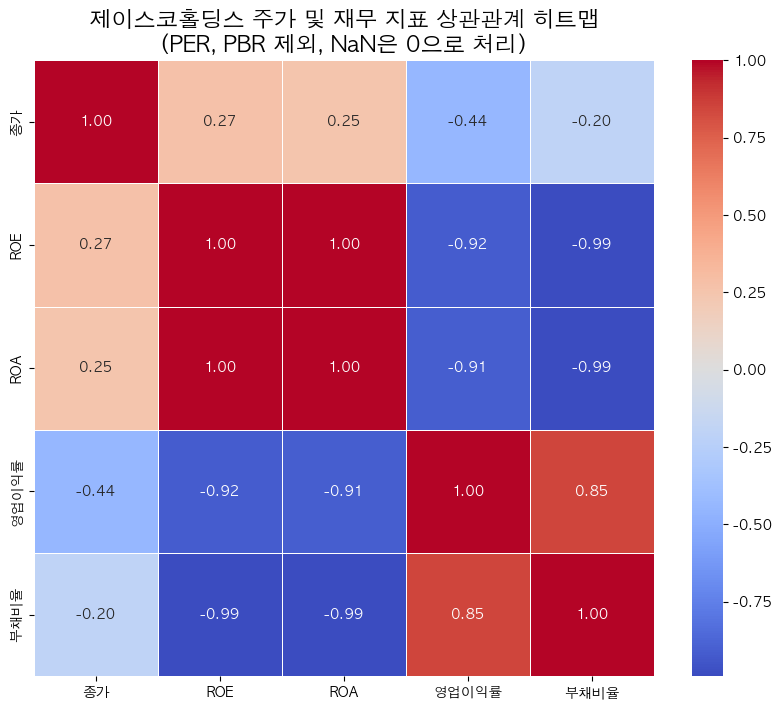

In [319]:
# 6.1. 상관관계 매트릭스 계산
# 이제 df_filled_zero를 사용합니다.
correlation_matrix = df_filled_zero.corr()

print("\n상관관계 매트릭스 (PER, PBR 제외, NaN은 0으로 처리):")
print(correlation_matrix)

# 6.2. Seaborn 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=.5)
plt.title(f'{target_stock_name} 주가 및 재무 지표 상관관계 히트맵\n(PER, PBR 제외, NaN은 0으로 처리)', fontsize=16)
plt.show()

In [320]:
# 3.1. '제이 스코 홀딩스' 종목 필터링 (PER, PBR 포함된 원본 상태로)
target_stock_name = analysis_df['종목명'].iloc[0]
# 여기서는 모든 지표를 가져옵니다. (PER, PBR 포함)
df_stock_original = analysis_df[analysis_df['종목명'] == target_stock_name].copy()

# 3.2. 날짜 컬럼명 추출
date_cols_original = [col for col in df_stock_original.columns if col not in ['종목명', '구분']]

# 3.3. '구분' 컬럼을 인덱스로 설정하고, 날짜 컬럼을 피벗 (전치)
df_pivot_original = df_stock_original.set_index('구분')[date_cols_original].T
df_pivot_original.columns.name = None
df_pivot_original.index.name = '날짜'

# 날짜 인덱스를 datetime 형식으로 변환
df_pivot_original.index = pd.to_datetime(df_pivot_original.index)

print(f"\n재구조화된 '{target_stock_name}' 데이터프레임 (모든 지표 포함) head:")
print(df_pivot_original.head())
print("\ndf_pivot_original info:")
df_pivot_original.info()

print("\n영업이익률 컬럼의 결측치 개수 (NaN 처리 전):")
print(df_pivot_original['영업이익률'].isnull().sum())
print("\n영업이익률 컬럼의 고유 값 (NaN 포함):")
print(df_pivot_original['영업이익률'].unique())


재구조화된 '제이스코홀딩스' 데이터프레임 (모든 지표 포함) head:
                종가  PER       PBR        ROE        ROA     영업이익률        부채비율
날짜                                                                           
2024-01-02  1430.0  NaN  1.400996 -38.864932 -19.087926 -15.07851  103.610031
2024-01-03  1477.0  NaN  1.447042 -38.864932 -19.087926 -15.07851  103.610031
2024-01-04  1408.0  NaN  1.379442 -38.864932 -19.087926 -15.07851  103.610031
2024-01-05  1401.0  NaN  1.372584 -38.864932 -19.087926 -15.07851  103.610031
2024-01-08  1414.0  NaN  1.385320 -38.864932 -19.087926 -15.07851  103.610031

df_pivot_original info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2024-01-02 to 2024-12-30
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   종가      244 non-null    float64
 1   PER     60 non-null     float64
 2   PBR     244 non-null    float64
 3   ROE     244 non-null    float64
 4   ROA     244 non-null    float64
 5   영

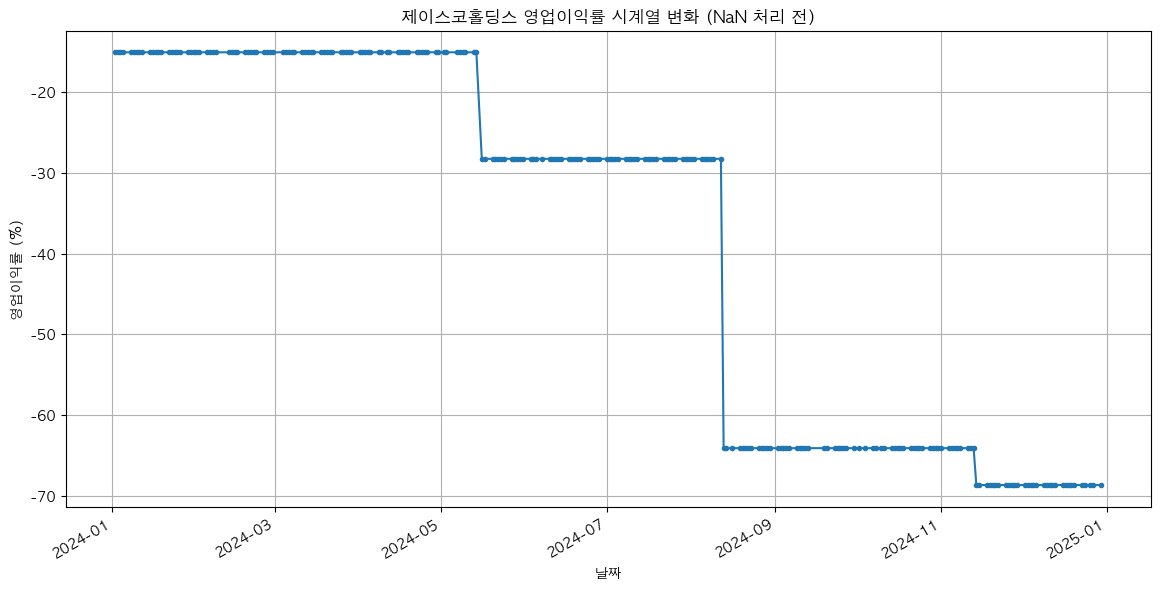

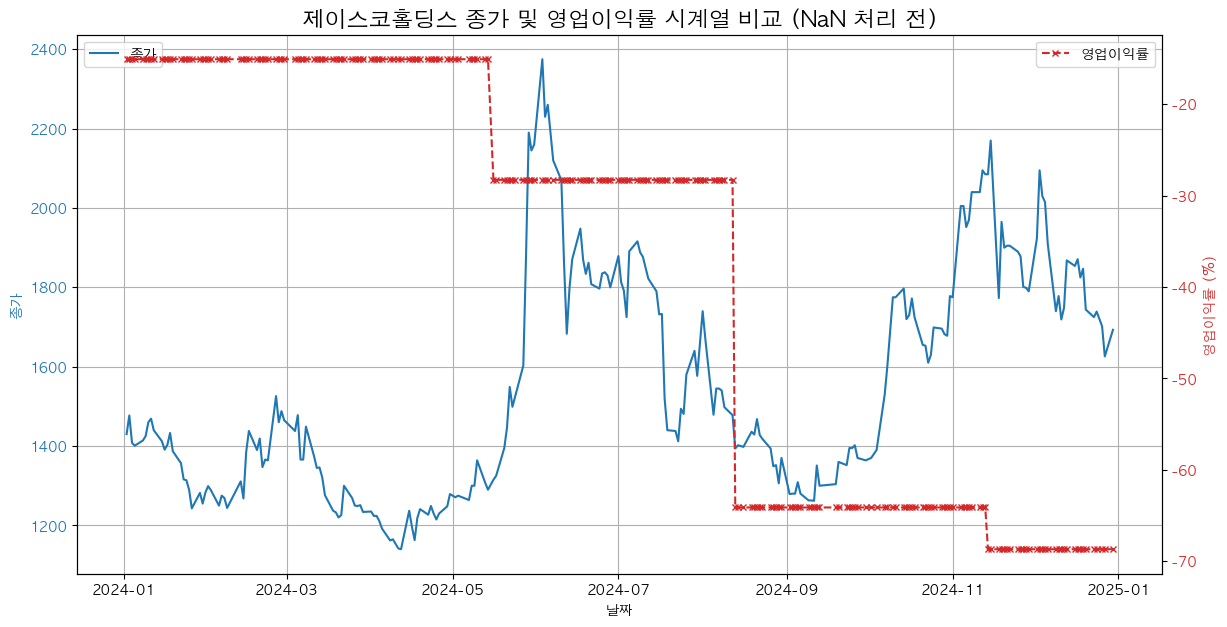

In [321]:
plt.figure(figsize=(14, 7))
# plot() 함수는 NaN 값을 자동으로 건너뛰고 그래프를 그립니다.
df_pivot_original['영업이익률'].plot(title=f'{target_stock_name} 영업이익률 시계열 변화 (NaN 처리 전)',
                                    grid=True,
                                    linestyle='-',
                                    marker='o', # 데이터 포인트 표시
                                    markersize=3)
plt.ylabel('영업이익률 (%)')
plt.xlabel('날짜')
plt.show()

# 추가적으로, 종가와 영업이익률을 함께 그려보는 것도 좋습니다.
# 종가의 스케일이 다르므로, 2개의 Y축을 사용합니다.
fig, ax1 = plt.subplots(figsize=(14, 7))

# 첫 번째 Y축: 종가
color = 'tab:blue'
ax1.set_xlabel('날짜')
ax1.set_ylabel('종가', color=color)
ax1.plot(df_pivot_original['종가'], color=color, label='종가', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.grid(True)

# 두 번째 Y축: 영업이익률
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('영업이익률 (%)', color=color)
ax2.plot(df_pivot_original['영업이익률'], color=color, label='영업이익률', linestyle='--', marker='x', markersize=4)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title(f'{target_stock_name} 종가 및 영업이익률 시계열 비교 (NaN 처리 전)', fontsize=16)
plt.show()

In [322]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [323]:
# analysis_df가 이미 로드되어 있다고 가정합니다.
# 만약 이 셀에서 'analysis_df is not defined' 에러가 발생한다면,
# 이전 대화에서 analysis_df를 로드하는 코드를 다시 실행해주세요.
# 예: analysis_df = pd.read_csv('your_data.csv')

# --- '제이 스코 홀딩스' 데이터 재구조화 및 NaN 0 처리 과정 ---
# 이 부분은 이전 단계에서 이미 실행했지만, 코드의 연속성을 위해 다시 명시합니다.

target_stock_name = analysis_df['종목명'].iloc[0]
excluded_metrics = ['PER', 'PBR']

# '제이 스코 홀딩스' 종목 필터링 및 PER, PBR 제외
df_stock = analysis_df[
    (analysis_df['종목명'] == target_stock_name) &
    (~analysis_df['구분'].isin(excluded_metrics))
].copy()

# 날짜 컬럼명 추출
date_cols = [col for col in df_stock.columns if col not in ['종목명', '구분']]

# '구분' 컬럼을 인덱스로 설정하고, 날짜 컬럼을 피벗 (전치)
df_pivot = df_stock.set_index('구분')[date_cols].T
df_pivot.columns.name = None
df_pivot.index.name = '날짜'

# 날짜 인덱스를 datetime 형식으로 변환
df_pivot.index = pd.to_datetime(df_pivot.index)

# 모든 NaN 값을 0으로 대체
df_filled_zero = df_pivot.fillna(0)

print("\n회귀 분석에 사용될 '제이 스코 홀딩스' 데이터프레임 (df_filled_zero) head:")
print(df_filled_zero.head())
print("\ndf_filled_zero info:")
df_filled_zero.info()

# 특징(X)과 타겟(y) 분리
X = df_filled_zero[['ROE', 'ROA', '영업이익률', '부채비율']]
y = df_filled_zero['종가']

print("\nFeatures (X) head:")
print(X.head())
print("\nTarget (y) head:")
print(y.head())


회귀 분석에 사용될 '제이 스코 홀딩스' 데이터프레임 (df_filled_zero) head:
                종가        ROE        ROA     영업이익률        부채비율
날짜                                                            
2024-01-02  1430.0 -38.864932 -19.087926 -15.07851  103.610031
2024-01-03  1477.0 -38.864932 -19.087926 -15.07851  103.610031
2024-01-04  1408.0 -38.864932 -19.087926 -15.07851  103.610031
2024-01-05  1401.0 -38.864932 -19.087926 -15.07851  103.610031
2024-01-08  1414.0 -38.864932 -19.087926 -15.07851  103.610031

df_filled_zero info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2024-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   종가      244 non-null    float64
 1   ROE     244 non-null    float64
 2   ROA     244 non-null    float64
 3   영업이익률   244 non-null    float64
 4   부채비율    244 non-null    float64
dtypes: float64(5)
memory usage: 11.4 KB

Features (X) head:
                  ROE        ROA     영업이

In [324]:
# 훈련 세트와 테스트 세트 비율 설정 (예: 80% 훈련, 20% 테스트)
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"\n훈련 세트 크기: {len(X_train)} 개")
print(f"테스트 세트 크기: {len(X_test)} 개")


훈련 세트 크기: 195 개
테스트 세트 크기: 49 개


In [325]:
scaler = StandardScaler()

# 훈련 데이터에 fit_transform 적용
X_train_scaled = scaler.fit_transform(X_train)
# 테스트 데이터에 transform 적용 (훈련 데이터의 스케일링 기준 사용)
X_test_scaled = scaler.transform(X_test)

# 스케일링된 데이터를 다시 DataFrame으로 변환 (분석 용이성을 위해)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("\n스케일링된 훈련 데이터 (X_train_scaled) head:")
print(X_train_scaled.head())


스케일링된 훈련 데이터 (X_train_scaled) head:
                 ROE       ROA     영업이익률      부채비율
날짜                                                
2024-01-02 -0.712841 -0.695838  0.790654  0.701335
2024-01-03 -0.712841 -0.695838  0.790654  0.701335
2024-01-04 -0.712841 -0.695838  0.790654  0.701335
2024-01-05 -0.712841 -0.695838  0.790654  0.701335
2024-01-08 -0.712841 -0.695838  0.790654  0.701335


In [326]:
model = LinearRegression()

# 모델 학습
model.fit(X_train_scaled, y_train)

print("\n선형 회귀 모델 학습 완료.")


선형 회귀 모델 학습 완료.


In [327]:
# 테스트 세트에 대한 예측
y_pred = model.predict(X_test_scaled)

# 모델 성능 평가
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Root Mean Squared Error
r2 = r2_score(y_test, y_pred) # R-squared

print(f"\n모델 성능 평가 (테스트 세트):")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2 Score): {r2:.2f}")

# 회귀 계수 확인 (각 지표의 영향력)
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
print("\n각 지표의 회귀 계수:")
print(coefficients.sort_values(by='Coefficient', ascending=False))

# 절편 (intercept) 확인
print(f"\n모델 절편 (Intercept): {model.intercept_:.2f}")


모델 성능 평가 (테스트 세트):
Mean Squared Error (MSE): 3301959.92
Root Mean Squared Error (RMSE): 1817.13
R-squared (R2 Score): -156.54

각 지표의 회귀 계수:
  Feature  Coefficient
3    부채비율   586.466465
0     ROE  -312.434876
1     ROA  -716.190362
2   영업이익률 -1640.353989

모델 절편 (Intercept): 1477.58


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/Users/kknaks/git/quantus-test/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kknaks/git/quantus-test/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/Users/kknaks/git/quantus-test/.conda/lib/python3.11/site-

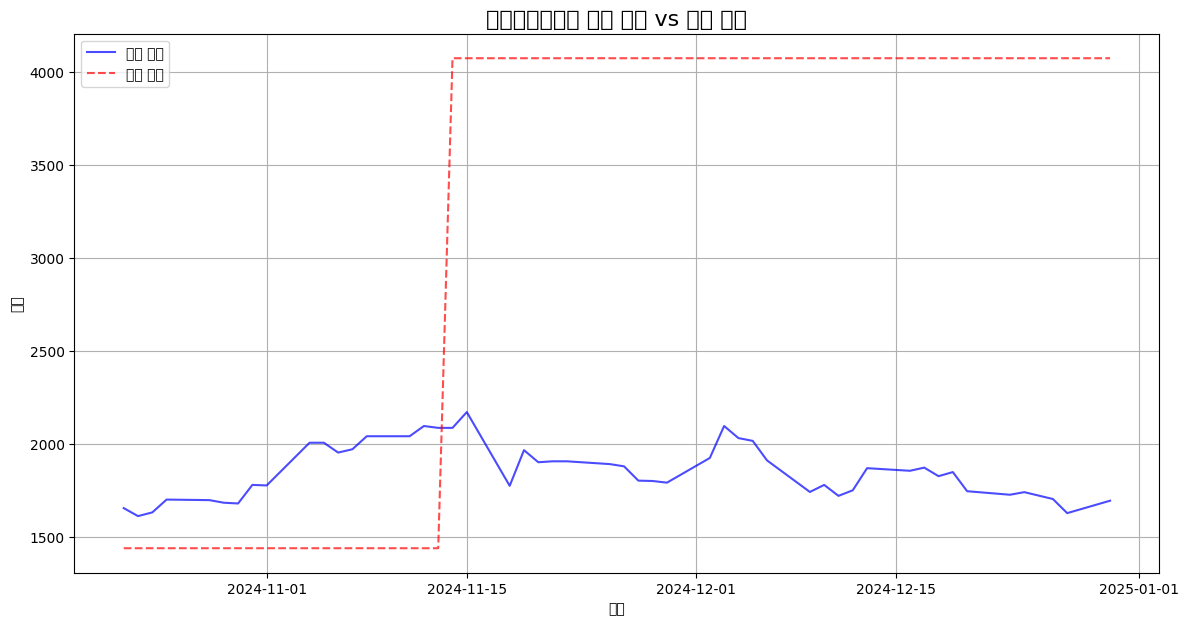

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/Users/kknaks/git/quantus-test/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kknaks/git/quantus-test/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: 

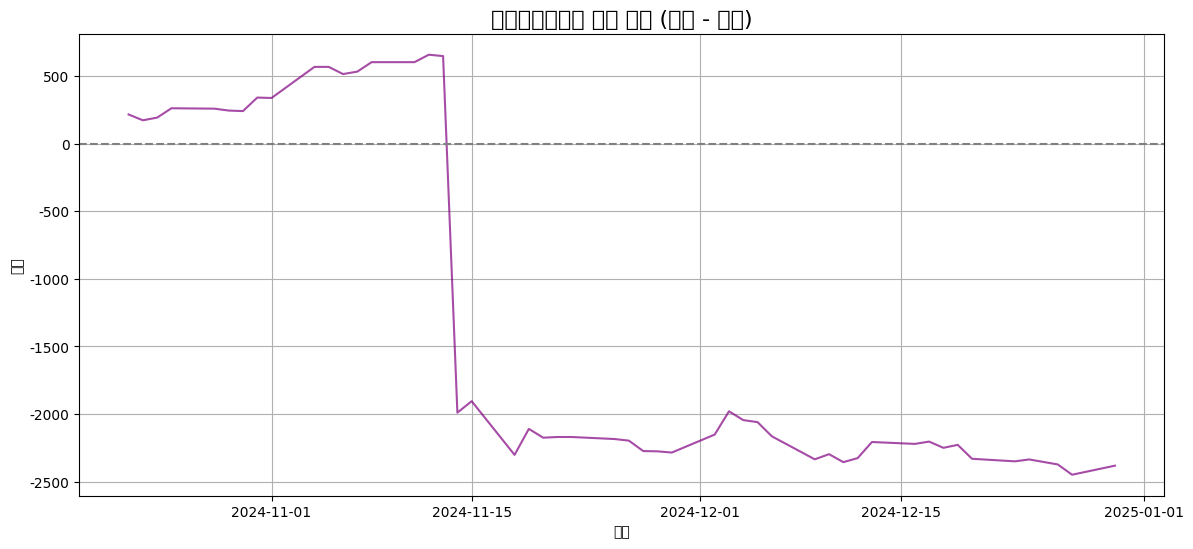

In [328]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='실제 종가', color='blue', alpha=0.7)
plt.plot(y_test.index, y_pred, label='예측 종가', color='red', linestyle='--', alpha=0.7)
plt.title(f'{target_stock_name} 실제 종가 vs 예측 종가', fontsize=16)
plt.xlabel('날짜')
plt.ylabel('종가')
plt.legend()
plt.grid(True)
plt.show()

# 잔차(Residual) 분석
residuals = y_test - y_pred
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, residuals, color='purple', alpha=0.7)
plt.axhline(y=0, color='gray', linestyle='--')
plt.title(f'{target_stock_name} 예측 잔차 (실제 - 예측)', fontsize=16)
plt.xlabel('날짜')
plt.ylabel('잔차')
plt.grid(True)
plt.show()

In [330]:
import pandas as pd
import numpy as np

# analysis_df가 이미 로드되어 있다고 가정합니다.
# 만약 이 셀에서 'analysis_df is not defined' 에러가 발생한다면,
# 이전 대화에서 analysis_df를 로드하는 코드를 다시 실행해주세요.
# 예: analysis_df = pd.read_csv('your_data.csv')

# --- 1. analysis_df의 날짜 컬럼을 모두 찾기 ---
# '종목명'과 '구분'을 제외한 모든 컬럼이 날짜 컬럼입니다.
date_cols = [col for col in analysis_df.columns if col not in ['종목명', '구분']]

# --- 2. Long Format으로 변환 (stack) ---
# 모든 날짜 컬럼을 하나의 '날짜' 컬럼으로 쌓아 올립니다.
df_long = analysis_df.set_index(['종목명', '구분'])[date_cols].stack().reset_index()
df_long.columns = ['종목명', '구분', '날짜', '값'] # 컬럼명 변경

# '날짜' 컬럼을 datetime 형식으로 변환
df_long['날짜'] = pd.to_datetime(df_long['날짜'])

print("Long Format으로 변환된 데이터 (df_long) head:")
print(df_long.head())
print("\ndf_long info:")
df_long.info()

# --- 3. Wide Format으로 변환 (unstack/pivot) ---
# '구분' 컬럼의 값(종가, PER 등)을 새로운 컬럼으로 만듭니다.
# '날짜'와 '종목명'을 기준으로 피벗합니다.
df_wide = df_long.pivot_table(index=['날짜', '종목명'], columns='구분', values='값')

# 컬럼명 정리
df_wide = df_wide.reset_index()
df_wide.columns.name = None # 컬럼명 인덱스 이름 제거

# 데이터프레임 컬럼 순서 조정 (보기 좋게)
# 모든 지표가 다 있을 경우의 컬럼 순서 지정
all_metrics = ['종가', 'PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율']
# 실제 df_wide에 있는 컬럼만 사용하여 순서 조정
ordered_cols = ['날짜', '종목명'] + [metric for metric in all_metrics if metric in df_wide.columns]
df_wide = df_wide[ordered_cols]

print("\nWide Format으로 재구조화된 데이터 (df_wide) head:")
print(df_wide.head())
print("\ndf_wide info:")
df_wide.info()

# --- 4. PER, PBR 컬럼 제외 및 NaN 0 처리 ---
# 이제 모든 종목에 대해 일괄적으로 적용합니다.
# 제외할 지표 리스트
metrics_to_exclude = ['PER', 'PBR']

# 해당 지표 컬럼이 존재하면 제외
for metric in metrics_to_exclude:
    if metric in df_wide.columns:
        df_wide = df_wide.drop(columns=[metric])
        print(f"'{metric}' 컬럼이 제거되었습니다.")

# 나머지 모든 숫자 컬럼에 대해 NaN 값을 0으로 채웁니다.
# '날짜'와 '종목명' 컬럼은 제외하고 숫자형 컬럼에만 적용
numeric_cols = df_wide.select_dtypes(include=np.number).columns
df_final = df_wide.copy() # 원본 보존을 위해 복사본 생성
df_final[numeric_cols] = df_final[numeric_cols].fillna(0)

print("\nPER, PBR 제외 및 NaN 0 처리 후 최종 데이터 (df_final) head:")
print(df_final.head())
print("\ndf_final info:")
df_final.info()
print("\ndf_final의 결측치 확인:")
print(df_final.isnull().sum())
df_final

Long Format으로 변환된 데이터 (df_long) head:
       종목명  구분         날짜       값
0  제이스코홀딩스  종가 2024-01-02  1430.0
1  제이스코홀딩스  종가 2024-01-03  1477.0
2  제이스코홀딩스  종가 2024-01-04  1408.0
3  제이스코홀딩스  종가 2024-01-05  1401.0
4  제이스코홀딩스  종가 2024-01-08  1414.0

df_long info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212936 entries, 0 to 212935
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   종목명     212936 non-null  object        
 1   구분      212936 non-null  object        
 2   날짜      212936 non-null  datetime64[ns]
 3   값       212936 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 6.5+ MB

Wide Format으로 재구조화된 데이터 (df_wide) head:
          날짜      종목명       종가        PER       PBR        ROE        ROA  \
0 2024-01-02   CJ CGV   5900.0        NaN  1.554476 -23.737762  -7.604703   
1 2024-01-02    CJ씨푸드   2920.0  23.654689  1.302636   5.506881   3.102180   
2 2024-01-02  DGB금융지

,날짜,종목명,종가,ROE,ROA,영업이익률,부채비율
0,2024-01-02,CJ CGV,5900.0,-23.737762,-7.604703,1.107799,212.145826
1,2024-01-02,CJ씨푸드,2920.0,5.506881,3.102180,2.790275,77.516472
2,2024-01-02,DGB금융지주,8410.0,5.416470,4.086800,0.000000,32.535720
3,2024-01-02,DI동일,28500.0,2.237577,1.540144,0.282837,45.283650
4,2024-01-02,GST,27750.0,19.431283,16.625184,16.140677,16.878605
...,...,...,...,...,...,...,...
32691,2024-12-30,화승인더,4450.0,2.673919,1.372287,2.218714,94.851288
32692,2024-12-30,휴니드,7710.0,3.304813,2.132344,6.741814,54.984981
32693,2024-12-30,휴메딕스,42250.0,4.197535,3.859098,24.748460,8.769847
32694,2024-12-30,흥구석유,12490.0,0.678986,0.585999,0.639497,15.868206


In [331]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [332]:
# df_final 데이터프레임이 이미 메모리에 있다고 가정합니다.
# 만약 이 셀에서 'df_final is not defined' 에러가 발생한다면,
# 이전 대화에서 df_final을 생성하는 코드를 다시 실행해주세요.
# (단계 1: 데이터 재구조화 부분)
print("종목별 상관관계 분석을 위한 df_final head:")
print(df_final.head())
print("\ndf_final info:")
df_final.info()

종목별 상관관계 분석을 위한 df_final head:
          날짜      종목명       종가        ROE        ROA      영업이익률        부채비율
0 2024-01-02   CJ CGV   5900.0 -23.737762  -7.604703   1.107799  212.145826
1 2024-01-02    CJ씨푸드   2920.0   5.506881   3.102180   2.790275   77.516472
2 2024-01-02  DGB금융지주   8410.0   5.416470   4.086800   0.000000   32.535720
3 2024-01-02     DI동일  28500.0   2.237577   1.540144   0.282837   45.283650
4 2024-01-02      GST  27750.0  19.431283  16.625184  16.140677   16.878605

df_final info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32696 entries, 0 to 32695
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   날짜      32696 non-null  datetime64[ns]
 1   종목명     32696 non-null  object        
 2   종가      32696 non-null  float64       
 3   ROE     32696 non-null  float64       
 4   ROA     32696 non-null  float64       
 5   영업이익률   32696 non-null  float64       
 6   부채비율    32696 non-null  float64 

In [333]:
all_stocks = df_final['종목명'].unique()
print(f"\n분석할 총 종목 수: {len(all_stocks)}")
print(f"분석할 종목 리스트: {all_stocks[:5]} ... (일부만 표시)") # 너무 많으면 일부만 출력


분석할 총 종목 수: 134
분석할 종목 리스트: ['CJ CGV' 'CJ씨푸드' 'DGB금융지주' 'DI동일' 'GST'] ... (일부만 표시)



모든 종목의 '종가'와 재무 지표 간 상관관계 요약 (df_correlations):
              ROE       ROA     영업이익률      부채비율
종목명                                            
CJ CGV   0.123979  0.131485  0.101368 -0.169293
CJ씨푸드    0.382087  0.382364  0.072856  0.201170
DGB금융지주  0.382986  0.381847       NaN -0.418849
DI동일    -0.595786 -0.599495 -0.076860 -0.032618
GST      0.731868  0.730299 -0.370937 -0.323995

총 134개 종목의 상관관계가 계산되었습니다.


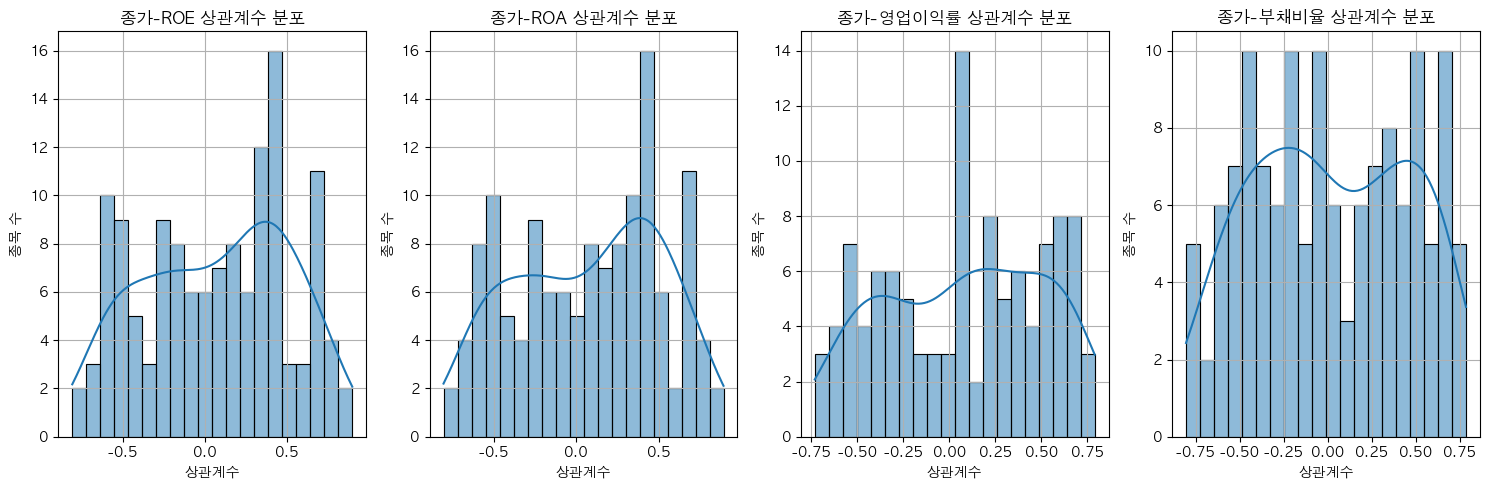

In [336]:
# 상관관계 결과를 저장할 딕셔너리
correlation_results = {}

# 분석할 지표들 (종가를 제외한 특징 지표)
features = ['ROE', 'ROA', '영업이익률', '부채비율']
target = '종가'

# 각 종목별로 반복
for stock_name in all_stocks:
    # 해당 종목의 데이터만 필터링
    df_stock = df_final[df_final['종목명'] == stock_name].copy()

    # 상관관계 계산을 위한 숫자형 컬럼만 선택
    # 종가와 특징 지표가 모두 있는지 확인 (결측치 처리 후 데이터가 부족할 수 있음)
    cols_for_corr = [target] + [f for f in features if f in df_stock.columns]

    if len(df_stock) > 1 and all(col in df_stock.columns for col in cols_for_corr): # 데이터가 최소 2개 이상이고 필요한 컬럼이 있는지 확인
        # 상관관계 매트릭스 계산
        corr_matrix = df_stock[cols_for_corr].corr()

        # '종가'와 각 지표 간의 상관계수만 추출
        if target in corr_matrix.index and len(corr_matrix.columns) > 1:
            stock_corr = corr_matrix.loc[target, features].to_dict()
            correlation_results[stock_name] = stock_corr
        else:
            print(f"주의: '{stock_name}' 종목은 상관관계를 계산하기에 충분한 데이터가 없거나, '종가' 컬럼이 없습니다. 건너뜁니다.")
    else:
        print(f"주의: '{stock_name}' 종목은 데이터 포인트가 부족하여 상관관계를 계산할 수 없습니다. (데이터 수: {len(df_stock)})")

# 결과를 DataFrame으로 변환하여 보기 쉽게 만듭니다.
df_correlations = pd.DataFrame.from_dict(correlation_results, orient='index')
df_correlations.index.name = '종목명'

print("\n모든 종목의 '종가'와 재무 지표 간 상관관계 요약 (df_correlations):")
print(df_correlations.head())
print(f"\n총 {len(df_correlations)}개 종목의 상관관계가 계산되었습니다.")

# 각 상관관계 분포를 시각화하여 대략적인 경향 파악 (선택 사항)
plt.figure(figsize=(15, 5))
for i, feature in enumerate(features):
    plt.subplot(1, len(features), i + 1)
    sns.histplot(df_correlations[feature].dropna(), bins=20, kde=True)
    plt.title(f'종가-{feature} 상관계수 분포')
    plt.xlabel('상관계수')
    plt.ylabel('종목 수')
    plt.grid(True)
plt.tight_layout()
plt.show()

In [337]:
# 신뢰 종목을 추출할 기준 정의
# 여기서는 예시로 'ROE'와 '종가'의 상관계수가 특정 값 이상인 경우를 기준으로 합니다.
# 여러 지표를 조합하여 복합적인 기준을 만들 수도 있습니다.

# 예시 기준: 종가와 ROE 간의 상관계수가 0.3 이상인 종목
# (0.3은 임의의 값이며, 실제 분석에서 조정 필요)
threshold_roe_corr = 0.3
reliable_stocks_roe = df_correlations[
    (df_correlations['ROE'].abs() >= threshold_roe_corr) & # 상관계수 절대값이 임계값 이상
    (df_correlations['ROE'] > 0) # 양의 상관관계만 고려할 경우
].copy()

# 예시 기준: 종가와 영업이익률 간의 상관계수가 -0.4 이하인 종목 (음의 상관관계가 강한 종목)
threshold_op_profit_corr = -0.4
reliable_stocks_op_profit = df_correlations[
    (df_correlations['영업이익률'].abs() >= abs(threshold_op_profit_corr)) &
    (df_correlations['영업이익률'] < 0) # 음의 상관관계만 고려할 경우
].copy()

# 모든 기준을 만족하는 종목 (AND 조건)
# 예: ROE 상관계수 0.3 이상 AND 부채비율 상관계수 -0.2 이하인 종목
threshold_debt_ratio_corr = -0.2
highly_reliable_stocks = df_correlations[
    (df_correlations['ROE'] >= threshold_roe_corr) &
    (df_correlations['부채비율'] <= threshold_debt_ratio_corr)
].copy()


print(f"\n신뢰도 기준 1 (종가-ROE 상관계수 >= {threshold_roe_corr}) 만족 종목:")
print(reliable_stocks_roe)
print(f"\n신뢰도 기준 2 (종가-영업이익률 상관계수 <= {threshold_op_profit_corr}) 만족 종목:")
print(reliable_stocks_op_profit)
print(f"\n신뢰도 기준 3 (종가-ROE 상관계수 >= {threshold_roe_corr} AND 종가-부채비율 상관계수 <= {threshold_debt_ratio_corr}) 만족 종목:")
print(highly_reliable_stocks)

# 각 종목의 상관관계 값들을 한눈에 보기 쉽게 저장 (CSV 등으로 저장 가능)
# df_correlations.to_csv('stock_correlations.csv')


신뢰도 기준 1 (종가-ROE 상관계수 >= 0.3) 만족 종목:
                 ROE       ROA     영업이익률      부채비율
종목명                                               
CJ씨푸드       0.382087  0.382364  0.072856  0.201170
DGB금융지주     0.382986  0.381847       NaN -0.418849
GST         0.731868  0.730299 -0.370937 -0.323995
HJ중공업       0.338858  0.366839  0.557554 -0.621225
LS에코에너지     0.703607  0.703524       NaN  0.617711
LX인터내셔널     0.655542  0.654604 -0.277367  0.658213
SNT다이내믹스    0.455247  0.468045  0.679559 -0.156040
광무          0.670297  0.667862  0.103641 -0.686112
국제약품        0.401385  0.401007  0.359085 -0.275590
그린케미칼       0.441704  0.447192 -0.363143  0.110621
네오셈         0.334461  0.364083 -0.023412 -0.548572
녹십자웰빙       0.351015  0.377893  0.289961 -0.446666
대영포장        0.504407  0.503103  0.510619  0.094365
대화제약        0.360345  0.372585  0.357891  0.323570
동국산업        0.390227  0.420177  0.028363 -0.338800
동국제약        0.456561  0.450632       NaN  0.243953
동방          0.439246  0.454988 -0.250219 -0.

In [338]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression # 회귀 모델
from sklearn.preprocessing import StandardScaler # 스케일링
import matplotlib.pyplot as plt
import seaborn as sns

In [339]:
# df_final 데이터프레임이 이미 메모리에 있다고 가정합니다.
# 이전 단계에서 생성된 df_final이 없다면, '단계 1: 데이터 재구조화' 코드를 다시 실행해주세요.
print("계수 분석을 위한 df_final head:")
print(df_final.head())
print("\ndf_final info:")
df_final.info()

계수 분석을 위한 df_final head:
          날짜      종목명       종가        ROE        ROA      영업이익률        부채비율
0 2024-01-02   CJ CGV   5900.0 -23.737762  -7.604703   1.107799  212.145826
1 2024-01-02    CJ씨푸드   2920.0   5.506881   3.102180   2.790275   77.516472
2 2024-01-02  DGB금융지주   8410.0   5.416470   4.086800   0.000000   32.535720
3 2024-01-02     DI동일  28500.0   2.237577   1.540144   0.282837   45.283650
4 2024-01-02      GST  27750.0  19.431283  16.625184  16.140677   16.878605

df_final info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32696 entries, 0 to 32695
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   날짜      32696 non-null  datetime64[ns]
 1   종목명     32696 non-null  object        
 2   종가      32696 non-null  float64       
 3   ROE     32696 non-null  float64       
 4   ROA     32696 non-null  float64       
 5   영업이익률   32696 non-null  float64       
 6   부채비율    32696 non-null  float64       

In [340]:
# 계수 결과를 저장할 딕셔너리
coefficient_results = {}

# 분석할 특징 지표들
features = ['ROE', 'ROA', '영업이익률', '부채비율']
target = '종가'

# 모든 고유 종목명 가져오기
all_stocks = df_final['종목명'].unique()

# 각 종목별로 반복
for stock_name in all_stocks:
    # 해당 종목의 데이터만 필터링
    df_stock = df_final[df_final['종목명'] == stock_name].copy()

    # 종속변수(y)와 독립변수(X) 설정
    X = df_stock[features]
    y = df_stock[target]

    # 결측치 확인 및 처리 (NaN은 이미 0으로 처리되어 있으므로 추가적인 NaN 없음)
    # 하지만 특정 컬럼의 값이 모두 같거나 데이터가 부족하면 모델 학습 불가
    # 최소한 독립변수 개수 + 1 만큼의 데이터 포인트가 있어야 함
    if len(X) <= len(features):
        print(f"경고: '{stock_name}' 종목은 데이터 포인트({len(X)}개)가 너무 적어 계수 분석을 건너_입니다.")
        continue

    # 독립변수들 중 분산이 0인 (모든 값이 동일한) 컬럼 확인 및 제거 (스케일링 시 에러 발생 방지)
    # 예를 들어 ROE, ROA 등 재무 지표는 특정 기간 동안 값이 동일하게 유지되는 경우가 많습니다.
    # 이런 컬럼은 회귀 분석에 유의미하지 않으므로 제거하거나 처리해야 합니다.
    # 여기서는 모두 동일한 값을 가지는 컬럼을 제거합니다.
    # 하지만, 재무 지표가 분기/연 업데이트이므로 값이 같을 수 있습니다.
    # 이 경우 해당 컬럼을 제거하지 않고 스케일링 시에 `with_std=False` 옵션을 주거나,
    # 아니면 해당 종목의 계수 분석을 건너뛰는 방법을 사용해야 합니다.
    # 여기서는 모든 값이 동일한 컬럼은 스케일링에서 제외하고 계수도 0으로 처리하는 방식으로 진행합니다.

    # 스케일링을 위한 유효한 컬럼만 선택
    valid_features = []
    for col in features:
        if X[col].nunique() > 1: # 고유한 값이 1개보다 많아야 (즉, 모든 값이 동일하지 않아야) 분산을 가짐
            valid_features.append(col)
        else:
            print(f"정보: '{stock_name}' 종목의 '{col}' 컬럼은 모든 값이 동일하여 계수 분석에서 제외됩니다.")

    if not valid_features:
        print(f"경고: '{stock_name}' 종목은 분석 가능한 독립 변수가 없어 계수 분석을 건너뜁니다.")
        continue

    X_valid = X[valid_features]

    # 데이터 스케일링 (StandardScaler 사용)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_valid)

    # 스케일링된 데이터를 DataFrame으로 변환 (컬럼명 유지를 위해)
    X_scaled_df = pd.DataFrame(X_scaled, columns=valid_features, index=X.index)

    # 선형 회귀 모델 학습
    model = LinearRegression()
    model.fit(X_scaled_df, y)

    # 계수 추출
    stock_coefficients = model.coef_
    intercept = model.intercept_

    # 결과를 딕셔너리에 저장
    coefficients = {feature: coef for feature, coef in zip(valid_features, stock_coefficients)}
    coefficients['_Intercept'] = intercept # 절편도 함께 저장
    coefficient_results[stock_name] = coefficients

# 결과를 DataFrame으로 변환하여 보기 쉽게 만듭니다.
df_coefficients = pd.DataFrame.from_dict(coefficient_results, orient='index')
df_coefficients.index.name = '종목명'

print("\n모든 종목의 회귀 계수 (df_coefficients) head:")
print(df_coefficients.head())
print(f"\n총 {len(df_coefficients)}개 종목의 계수가 분석되었습니다.")

정보: 'DGB금융지주' 종목의 '영업이익률' 컬럼은 모든 값이 동일하여 계수 분석에서 제외됩니다.
정보: 'HLB생명과학' 종목의 'ROE' 컬럼은 모든 값이 동일하여 계수 분석에서 제외됩니다.
정보: 'HLB생명과학' 종목의 'ROA' 컬럼은 모든 값이 동일하여 계수 분석에서 제외됩니다.
정보: 'LS에코에너지' 종목의 '영업이익률' 컬럼은 모든 값이 동일하여 계수 분석에서 제외됩니다.
정보: '넥슨게임즈' 종목의 '영업이익률' 컬럼은 모든 값이 동일하여 계수 분석에서 제외됩니다.
정보: '동국제약' 종목의 '영업이익률' 컬럼은 모든 값이 동일하여 계수 분석에서 제외됩니다.
정보: '동양생명' 종목의 '영업이익률' 컬럼은 모든 값이 동일하여 계수 분석에서 제외됩니다.
정보: '바이오다인' 종목의 '영업이익률' 컬럼은 모든 값이 동일하여 계수 분석에서 제외됩니다.
정보: '삼성제약' 종목의 '영업이익률' 컬럼은 모든 값이 동일하여 계수 분석에서 제외됩니다.
정보: '샤페론' 종목의 '영업이익률' 컬럼은 모든 값이 동일하여 계수 분석에서 제외됩니다.
정보: '세경하이테크' 종목의 '영업이익률' 컬럼은 모든 값이 동일하여 계수 분석에서 제외됩니다.
정보: '에브리봇' 종목의 '영업이익률' 컬럼은 모든 값이 동일하여 계수 분석에서 제외됩니다.
정보: '에스디바이오센서' 종목의 '영업이익률' 컬럼은 모든 값이 동일하여 계수 분석에서 제외됩니다.
정보: '에이프릴바이오' 종목의 '영업이익률' 컬럼은 모든 값이 동일하여 계수 분석에서 제외됩니다.
정보: '영진약품' 종목의 '영업이익률' 컬럼은 모든 값이 동일하여 계수 분석에서 제외됩니다.
정보: '올릭스' 종목의 '영업이익률' 컬럼은 모든 값이 동일하여 계수 분석에서 제외됩니다.
정보: '우리기술투자' 종목의 '영업이익률' 컬럼은 모든 값이 동일하여 계수 분석에서 제외됩니다.
정보: '웹케시' 종목의 '영업이익률' 컬럼은 모든 값이 동일하여 계수 분석에서 제외됩니다.
정보: '인카금융서비스' 종목의 '영업이익률' 컬럼

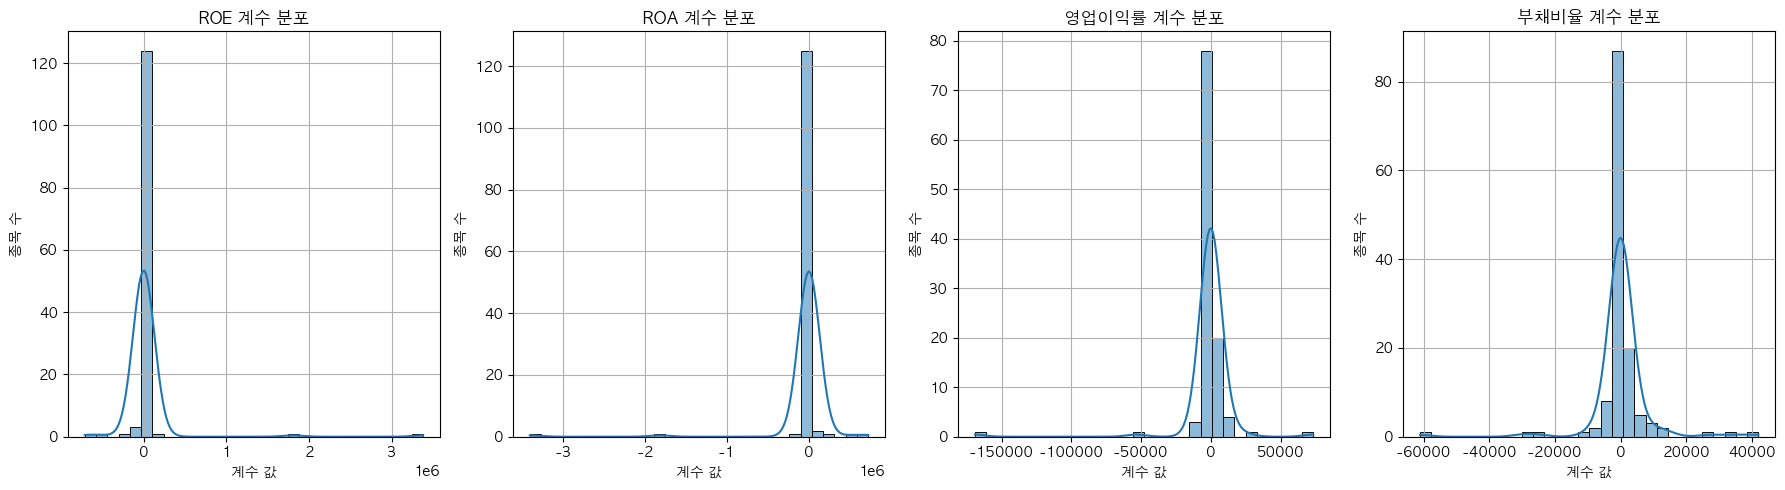


각 지표별 회귀 계수의 평균 및 표준편차:
                ROE            ROA         영업이익률         부채비율
mean   29652.977924  -29866.627660  -1030.359579   161.516222
std   342476.596553  345631.888581  18956.456236  8795.741640

ROE 계수가 높은 상위 10개 종목:
                    ROE           ROA          영업이익률          부채비율  \
종목명                                                                  
바이오다인      3.377345e+06 -3.409758e+06            NaN  34717.233096   
제주은행       1.807133e+06 -1.822763e+06            NaN -61120.273676   
인카금융서비스    2.213869e+05 -2.226109e+05            NaN   -241.639855   
에이프릴바이오    6.864419e+04 -6.407403e+04            NaN   2090.497050   
이수스페셜티케미컬  6.353991e+04  5.911711e+04 -169146.897915 -29970.311386   
넥슨게임즈      4.125121e+04 -4.293850e+04            NaN   -470.373842   
세경하이테크     3.864266e+04 -2.426778e+04            NaN  14133.060561   
웹케시        3.533529e+04 -3.497558e+04            NaN     83.393047   
삼성제약       1.970177e+04 -1.958490e+04            NaN    557.002996

In [341]:
# 계수들의 분포를 시각화 (히스토그램)
plt.figure(figsize=(18, 5)) # 그래프 크기 조정

for i, feature in enumerate(features):
    if feature in df_coefficients.columns: # 해당 특징의 계수 컬럼이 존재하는 경우에만
        plt.subplot(1, len(features), i + 1)
        sns.histplot(df_coefficients[feature].dropna(), bins=30, kde=True)
        plt.title(f'{feature} 계수 분포', fontsize=12)
        plt.xlabel('계수 값')
        plt.ylabel('종목 수')
        plt.grid(True)
    else:
        # 해당 특징의 계수 컬럼이 아예 없는 경우 (예: 모든 종목에서 해당 컬럼의 값이 동일했거나)
        plt.subplot(1, len(features), i + 1)
        plt.title(f'{feature} 계수 분포 (데이터 부족)', fontsize=12)
        plt.text(0.5, 0.5, '계수 데이터 없음', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.grid(True)


plt.tight_layout()
plt.show()

# 각 지표별 계수의 평균 및 표준편차 확인
print("\n각 지표별 회귀 계수의 평균 및 표준편차:")
print(df_coefficients[features].describe().loc[['mean', 'std']])

# 특정 기준에 따라 계수 값 확인 (예시: ROE 계수가 높은 상위 10개 종목)
print("\nROE 계수가 높은 상위 10개 종목:")
print(df_coefficients.sort_values(by='ROE', ascending=False).head(10))

print("\n영업이익률 계수가 낮은 (음의 영향력이 큰) 하위 10개 종목:")
print(df_coefficients.sort_values(by='영업이익률', ascending=True).head(10))

In [306]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938 entries, 0 to 937
Columns: 246 entries, 종목명 to 20241230
dtypes: float64(244), object(2)
memory usage: 1.8+ MB


In [304]:
analysis_df['구분'].unique()

array(['종가', 'PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율'], dtype=object)

In [305]:
analysis_df

,종목명,구분,20240102,20240103,20240104,20240105,20240108,20240109,20240110,20240111,...,20241216,20241217,20241218,20241219,20241220,20241223,20241224,20241226,20241227,20241230
0,제이스코홀딩스,종가,1430.000000,1477.000000,1408.000000,1401.000000,1414.000000,1425.000000,1460.000000,1469.000000,...,1854.000000,1871.000000,1825.000000,1847.000000,1744.000000,1725.000000,1739.000000,1702.000000,1626.000000,1693.000000
1,제이스코홀딩스,PER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,제이스코홀딩스,PBR,1.400996,1.447042,1.379442,1.372584,1.385320,1.396097,1.430387,1.439205,...,1.777508,1.793806,1.749704,1.770796,1.672046,1.653830,1.667252,1.631779,1.558914,1.623150
3,제이스코홀딩스,ROE,-38.864932,-38.864932,-38.864932,-38.864932,-38.864932,-38.864932,-38.864932,-38.864932,...,-13.082513,-13.082513,-13.082513,-13.082513,-13.082513,-13.082513,-13.082513,-13.082513,-13.082513,-13.082513
4,제이스코홀딩스,ROA,-19.087926,-19.087926,-19.087926,-19.087926,-19.087926,-19.087926,-19.087926,-19.087926,...,-6.709918,-6.709918,-6.709918,-6.709918,-6.709918,-6.709918,-6.709918,-6.709918,-6.709918,-6.709918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,DGB금융지주,PBR,0.420864,0.420864,0.414858,0.407352,0.404349,0.407852,0.412356,0.412356,...,0.443487,0.425199,0.431295,0.427231,0.417579,0.428755,0.429263,0.428755,0.422659,0.415547
934,DGB금융지주,ROE,5.416470,5.416470,5.416470,5.416470,5.416470,5.416470,5.416470,5.416470,...,-1.397186,-1.397186,-1.397186,-1.397186,-1.397186,-1.397186,-1.397186,-1.397186,-1.397186,-1.397186
935,DGB금융지주,ROA,4.086800,4.086800,4.086800,4.086800,4.086800,4.086800,4.086800,4.086800,...,-1.046711,-1.046711,-1.046711,-1.046711,-1.046711,-1.046711,-1.046711,-1.046711,-1.046711,-1.046711
936,DGB금융지주,영업이익률,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [300]:
def meaningful_correlation_analysis(analysis_df):
    """의미있는 상관관계 분석 (PER, PBR 제외)"""
    
    results = []
    companies = analysis_df['종목명'].unique()
    
    for company in companies:
        try:
            company_data = analysis_df[analysis_df['종목명'] == company]
            
            # 구분별로 딕셔너리 만들기
            metrics_dict = {}
            for _, row in company_data.iterrows():
                metric = row['구분']
                values = []
                for col in row.index[2:]:
                    if pd.notna(row[col]):
                        values.append(float(row[col]))
                
                if len(values) > 0:
                    metrics_dict[metric] = values
            
            if '종가' in metrics_dict and len(metrics_dict) > 1:
                stock_prices = metrics_dict['종가']
                correlations = {'종목명': company, '데이터수': len(stock_prices)}
                
                # PER, PBR 제외하고 분석
                exclude_metrics = ['종가', 'PER', 'PBR']
                
                for metric, values in metrics_dict.items():
                    if (metric not in exclude_metrics and 
                        len(values) == len(stock_prices)):
                        
                        # 값이 모두 같으면 스킵 (상수 체크)
                        if len(set(values)) > 1:  # 서로 다른 값이 있을 때만
                            corr = pd.Series(stock_prices).corr(pd.Series(values))
                            correlations[metric] = corr
                        else:
                            correlations[metric] = 0.0  # 상수면 상관관계 0
                
                results.append(correlations)
                
        except Exception as e:
            continue
    
    return pd.DataFrame(results)

# 실행
meaningful_results = meaningful_correlation_analysis(analysis_df)
print(meaningful_results.head())

       종목명  데이터수       ROE       ROA     영업이익률      부채비율
0  제이스코홀딩스   244  0.270580  0.253226 -0.440476 -0.202563
1   퀀타매트릭스   244  0.377161  0.514529 -0.156500  0.381488
2     삼익악기   244  0.131611  0.126966  0.027908  0.461236
3     나노엔텍   244 -0.176444 -0.176193 -0.270843 -0.013277
4       동방   244  0.439246  0.454988 -0.250219 -0.413954


In [301]:
meaningful_results

,종목명,데이터수,ROE,ROA,영업이익률,부채비율
0,제이스코홀딩스,244,0.270580,0.253226,-0.440476,-0.202563
1,퀀타매트릭스,244,0.377161,0.514529,-0.156500,0.381488
2,삼익악기,244,0.131611,0.126966,0.027908,0.461236
3,나노엔텍,244,-0.176444,-0.176193,-0.270843,-0.013277
4,동방,244,0.439246,0.454988,-0.250219,-0.413954
...,...,...,...,...,...,...
129,HDC현대산업개발,244,-0.482019,-0.499811,0.612235,0.507965
130,HLB생명과학,244,0.000000,0.000000,-0.089372,0.731293
131,한국콜마,244,0.900728,0.894434,0.556081,0.308976
132,에스디바이오센서,244,-0.475579,-0.475409,NaN,0.387196


In [307]:
analysis_df

,종목명,구분,20240102,20240103,20240104,20240105,20240108,20240109,20240110,20240111,...,20241216,20241217,20241218,20241219,20241220,20241223,20241224,20241226,20241227,20241230
0,제이스코홀딩스,종가,1430.000000,1477.000000,1408.000000,1401.000000,1414.000000,1425.000000,1460.000000,1469.000000,...,1854.000000,1871.000000,1825.000000,1847.000000,1744.000000,1725.000000,1739.000000,1702.000000,1626.000000,1693.000000
1,제이스코홀딩스,PER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,제이스코홀딩스,PBR,1.400996,1.447042,1.379442,1.372584,1.385320,1.396097,1.430387,1.439205,...,1.777508,1.793806,1.749704,1.770796,1.672046,1.653830,1.667252,1.631779,1.558914,1.623150
3,제이스코홀딩스,ROE,-38.864932,-38.864932,-38.864932,-38.864932,-38.864932,-38.864932,-38.864932,-38.864932,...,-13.082513,-13.082513,-13.082513,-13.082513,-13.082513,-13.082513,-13.082513,-13.082513,-13.082513,-13.082513
4,제이스코홀딩스,ROA,-19.087926,-19.087926,-19.087926,-19.087926,-19.087926,-19.087926,-19.087926,-19.087926,...,-6.709918,-6.709918,-6.709918,-6.709918,-6.709918,-6.709918,-6.709918,-6.709918,-6.709918,-6.709918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,DGB금융지주,PBR,0.420864,0.420864,0.414858,0.407352,0.404349,0.407852,0.412356,0.412356,...,0.443487,0.425199,0.431295,0.427231,0.417579,0.428755,0.429263,0.428755,0.422659,0.415547
934,DGB금융지주,ROE,5.416470,5.416470,5.416470,5.416470,5.416470,5.416470,5.416470,5.416470,...,-1.397186,-1.397186,-1.397186,-1.397186,-1.397186,-1.397186,-1.397186,-1.397186,-1.397186,-1.397186
935,DGB금융지주,ROA,4.086800,4.086800,4.086800,4.086800,4.086800,4.086800,4.086800,4.086800,...,-1.046711,-1.046711,-1.046711,-1.046711,-1.046711,-1.046711,-1.046711,-1.046711,-1.046711,-1.046711
936,DGB금융지주,영업이익률,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
